## Import Packages

1. To build a recurrent neural network, we start by importing the Dense layer, Activation layer, and Loss function that you implemented in Lab4 & Flatten layer you implemented in Lab5. Ensure the following three files are located in the same directory as this notebook, and follow the instructions to complete the setup:
    - Dense.py : Copy the **Dense class** you had implemented in Lab4 to it.
    - Activation.py : Copy the **Activation class** you had implemented in Lab4 to it.
    - Loss.py : Copy **compute_CCE_loss** function you had implemented in Lab4 to it.
    - Flatten.py: Copy **Flatten class** you had implemented in Lab5 to it.\
    Note: you should copy both `forward()` and `backward()` in class `Flatten` in Lab5.


⚠️ **WARNING** ⚠️:
*   Please do not import any other packages in this lab.
*   np.random.seed(seed) is used to keep all the random function calls consistent. It will help us grade your work. Please don't change the seed.

❗ **Important** ❗: Please do not change the code outside this code bracket.
```
### START CODE HERE ###
...
### END CODE HERE ###
```



### Mount Google Drive (optional)

In [1]:
### START CODE HERE ###
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# os.chdir('YOUR PATH')
### END CODE HERE ###

In [2]:
###### import your Lab4 & Lab5 code (Don't change this part) ######
from Dense import Dense
from Activation import Activation
from Loss import compute_CCE_loss, compute_MSE_loss
from Flatten import Flatten
##################################

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

outputs = {}

# Basic Part

## RNN Class (30%)
The RNN class implements a simple Recurrent Neural Network (RNN) layer. This class includes methods for initializing parameters, performing the forward pass, computing gradients during the backward pass, and updating the weights.

Structure overview:
<figure> <img src="https://imgur.com/nU7xrBe.png" width="580" height="400">
</figure>
RNN connection:
<figure>
<img src="https://imgur.com/4JQX0se.png" width="500" height="250">
</figure>
Data insights:
<figure> <img src="https://imgur.com/c2MI3mj.png" width="400" height="220">
</figure>
In each neuron:
<figure> <img src="https://imgur.com/luXS4zv.png" width="300" height="220">
</figure>

1.   **Initializaon**

    *   `input_size`: The number of input features for each time step.
    *   `rnn_units`: The number of units (neurons) in the RNN layer.
    *   `seed`: A random seed for weight initialization to ensure reproducibility.

2.   **Initialize parameters** (3%)
    * `Wx`: The weight matrix for the input to hidden connections. It has a shape of `(rnn_units, input_size)`
    * `Wh`: The weight matrix for the hidden to hidden connections. It has a shape of `(rnn_units, rnn_units)`
    * `bh`: The bias vector for the hidden state. It has a shape of `(rnn_units, 1)`, where rnn_units is the number of units in the RNN layer.
3.  **Forward** (12%) \
* `X`: Input data of shape `(batch_size, timesteps, input_size)`
* The forward pass computes the hidden state `h_t` (shape of `(batch_size, self.rnn_units)`)at each time step `t` using the following formula:
$ h_t = \tanh(W_x \cdot x_t + W_h \cdot h_{t-1} + b_h)$
    * $W_x$ is the weight matrix for the input to hidden connections.
    * $W_h$ is the weight matrix for the hidden to hidden connections.
    * $b_h$ is the bias vector.
    * $x_t$ is the input at time step t.
    * $h_{t-1}$ is the hidden state from the previous time step.
    * $\tanh$ is the hyperbolic tangent activation function.
* Output would be shape of `(batch_size, rnn_units)`
4. **Backward** (15%) \
Reference (Backpropagation Through Time):
https://www.pycodemates.com/2023/08/backpropagation-through-time-explained-with-derivations.html
* `dH`: Gradient of the loss with respect to the hidden state, typically of shape `(batch_size, rnn_units, 1)`.
* The backward pass computes the gradients of the loss with respect to the weights and biases using the following formulas:
    * Gradient of the loss with respect to the hidden state(derivative of `tanh`):\
    $\delta_t = (1 - h_t^2) \cdot \delta_{t+1}$
        * $\delta_t$ is the gradient of the loss with respect to the hidden state at time step t.
        * $h_t$ is the hidden state at time step t
    * Gradients with respect to the weights and biases (accumulate the gradients over all time steps):
        1. $\frac{\partial L}{\partial W_x} = ∑_{t=0}^{timesteps} \delta_t^T \cdot x_t$
        2. $\frac{\partial L}{\partial W_h} = ∑_ {t=0}^{timesteps} \delta_t^T \cdot h_{t-1}$
        3. $\frac{\partial L}{\partial b_h} = ∑_{t=0}^{timesteps} \delta_t^T$
        * $\frac{\partial L}{\partial W_x}$ is the gradient of the loss with respect to the input to hidden weights.
        * $\frac{\partial L}{\partial W_h}$ is the gradient of the loss with respect to the hidden to hidden weights.
        * $\frac{\partial L}{\partial b_h}$ is the gradient of the loss with respect to the hidden bias.
        * $x_t$ is the input at time step t.
        * $h_{t-1}$ is the hidden state from the previous time step.
    * Gradient with respect to the previous hidden state:
    $\frac{\partial L}{\partial h_{t-1}} = \delta_t \cdot W_h$
    * Then divide each gradient by `batch_size`.
    * Gradient clipping (optional) is recommended in RNN since RNN rely on backpropagation through time where data might contain large timesteps and it might cause gradient explosion or vanishing. **Note**: You can't do gradient clipping in the function testing (`test_baward()`)


In [3]:
class RNN():
    def __init__(self, input_size, rnn_units, seed=1):
        """
        Initialize the SimpleRNN layer.

        Parameters:
        input_size (int): Number of input features.
        rnn_units (int): Number of units in the RNN layer.
        seed (int): Random seed for weight initialization.
        """
        self.input_size = input_size
        self.rnn_units = rnn_units
        self.seed = seed
        self.initialize_parameters()

    def initialize_parameters(self):
        """
        Initialize the weights and biases for the RNN layer.
        """
        np.random.seed(self.seed)

        ### START CODE HERE ###
        # Multiply by 0.01 is for testing reason.
        self.Wx = np.random.randn(self.rnn_units, self.input_size) * 0.01     # Input to hidden weights , with shape of (rnn_units, input_size).
        self.Wh = np.random.randn(self.rnn_units, self.rnn_units) * 0.01     # Hidden to hidden weights, with shape of (rnn_units, rnn_units).
        self.bh = np.zeros((self.rnn_units, 1))     # Hidden bias, with shape of (rnn_units, 1).
        ### END CODE HERE ###

    def forward(self, X):
        """
        Perform the forward pass through the RNN layer.

        Parameters:
        X (ndarray): Input data of shape (batch_size, timesteps, input_size).

        Returns:
        ndarray: Output of the RNN layer (hidden state).
        """
        batch_size, timesteps, _ = X.shape
        ### START CODE HERE ###
        self.h = np.zeros((batch_size, self.rnn_units))     # Initialize hidden state, with shape of (batch_size, self.rnn_units).
        self.hs = []      # Store hidden states for backward pass, list of self.h.
        ### END CODE HERE ###

        self.xs = []  # Store inputs for backward pass

        for t in range(timesteps):
            ### START CODE HERE ###
            x_t = X[:, t, :]  # (batch_size, input_size)
            self.xs.append(x_t)
            input_component = np.dot(x_t, self.Wx.T) # (batch_size, input_size) * (input_size, rnn_units)
            recurrent_component = np.dot(self.h, self.Wh.T) # (batch_size, rnn_units) * (rnn_units, rnn_units)
            # self.bh.T: (rnn_units, 1), broadcasted to (batch_size, rnn_units)
            self.h = np.tanh(input_component + recurrent_component + self.bh.T)     # Update hidden state.
            self.hs.append(self.h)
            ### END CODE HERE ###

        return self.h


    def backward(self, dH):
        """
        Perform the backward pass through the RNN layer.

        Parameters:
        dH (ndarray): Gradient of the loss with respect to the hidden state.
        clip_value (float): Value to clip the gradients to prevent exploding gradients.

        Returns:
        ndarray: Gradient of the loss with respect to the input.
        """
        batch_size, _ = dH.shape
        ### START CODE HERE ###
        self.dL_dWx = np.zeros_like(self.Wx)        # Initialized with same shape as Wx.
        self.dL_dWh = np.zeros_like(self.Wh)        # Initialized with same shape as Wh.
        self.dL_dbh = np.zeros_like(self.bh)        # Initialized with same shape as bh.
        ### END CODE HERE ###
        dL_dh = dH

        for t in reversed(range(len(self.hs))):
            x_t = self.xs[t]  # Get input at time step t
            h = self.hs[t]
            h_prev = self.hs[t-1] if t > 0 else np.zeros_like(h)
            ### START CODE HERE ###
            dL_dh_raw = (1 - h ** 2) * dL_dh                            # Derivative of tanh
            self.dL_dWx += np.dot(dL_dh_raw.T, x_t)                     # Gradient w.r.t. Wx
            self.dL_dWh += np.dot(dL_dh_raw.T, h_prev)                  # Gradient w.r.t. Wh
            self.dL_dbh += np.sum(dL_dh_raw, axis=0, keepdims=True).T   # Gradient w.r.t. bh
            dL_dh = np.dot(dL_dh_raw, self.Wh)                          # Gradient w.r.t. previous hidden state
            ### END CODE HERE ###

        ### START CODE HERE ###
        # Average gradients over the batch.
        self.dL_dWx /= batch_size
        self.dL_dWh /= batch_size
        self.dL_dbh /= batch_size
        ### END CODE HERE ###

        ### START CODE HERE ###
        # Gradient part (optional), you can't run this part while testing the backward function !!!
        clip_value = 2.0
        # Clip gradients to prevent exploding gradients
        np.clip(self.dL_dWx, -clip_value, clip_value, out=self.dL_dWx)
        np.clip(self.dL_dWh, -clip_value, clip_value, out=self.dL_dWh)
        np.clip(self.dL_dbh, -clip_value, clip_value, out=self.dL_dbh)
        ### END CODE HERE ###

        return dL_dh

    def update(self, learning_rate):
        """
        Update the weights and biases using the computed gradients.

        Parameters:
        learning_rate (float): Learning rate for weight updates.
        """
        ### START CODE HERE ###
        # Update each weights.
        self.Wx -= learning_rate * self.dL_dWx
        self.Wh -= learning_rate * self.dL_dWh
        self.bh -= learning_rate * self.dL_dbh
        ### END CODE HERE ###

### Functions testing


#### `initialize_parameter` function

In [4]:
def test_initialization(save_to_output = False):
    input_size = 5
    rnn_units = 3
    rnn = RNN(input_size, rnn_units)
    print("Wx shape:", rnn.Wx.shape)
    print("Wh shape:", rnn.Wh.shape)
    print("bh shape:", rnn.bh.shape)
    if save_to_output == True:
        outputs['RNN_initialization'] = {"Wx shape": rnn.Wx.shape, "Wh shape": rnn.Wh.shape, "bh shape": rnn.bh.shape}
test_initialization(True)

Wx shape: (3, 5)
Wh shape: (3, 3)
bh shape: (3, 1)


Expected output:

|Output|Value|
|---|---|
|Wx shape:|(3, 5)|
|Wh shape:|(3, 3)|
|bh shape:|(3, 1)|

#### `forward` function


In [5]:
def test_forward(seed, save_to_output = False):
    input_size = 5
    rnn_units = 3
    batch_size = 2
    timesteps = 4
    # Initialize the RNN layer
    rnn = RNN(input_size, rnn_units)
    # Create a sample input of shape (batch_size, timesteps, input_size)
    np.random.seed(seed)   # Don't change the seed!
    X = np.random.randn(batch_size, timesteps, input_size)
    # Perform the forward pass
    output = rnn.forward(X)

    if save_to_output == False:
        # Print the output
        print("Input shape:", X.shape)
        print("Input:")
        print(X)
        print("Output shape of RNN layer:", output.shape)
        print("Output of the RNN layer (hidden state):")
        print(output)

    if save_to_output == True:
        outputs['RNN_forward'] = {"X shape": X.shape, "X": X, "Output shape": output.shape, "Output": output}

# Run the test with seed 1 to compare with expected outputs.
test_forward(1)

# Run with seed 42 and save the answer.
test_forward(42, True)

Input shape: (2, 4, 5)
Input:
[[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
  [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
  [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]
  [-1.09989127 -0.17242821 -0.87785842  0.04221375  0.58281521]]

 [[-1.10061918  1.14472371  0.90159072  0.50249434  0.90085595]
  [-0.68372786 -0.12289023 -0.93576943 -0.26788808  0.53035547]
  [-0.69166075 -0.39675353 -0.6871727  -0.84520564 -0.67124613]
  [-0.0126646  -1.11731035  0.2344157   1.65980218  0.74204416]]]
Output shape of RNN layer: (2, 3)
Output of the RNN layer (hidden state):
[[-0.00873835  0.02641052 -0.00287992]
 [-0.00596289 -0.01742189  0.02418844]]


Expected output of `forward`:

| Output | Value |
|---|---|
| Input shape | (2, 4, 5) |
| Input | `[[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]`<br>  `[-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]`<br>  `[ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]`<br>  `[-1.09989127 -0.17242821 -0.87785842  0.04221375  0.58281521]]`<br><br> `[[-1.10061918  1.14472371  0.90159072  0.50249434  0.90085595]`<br>  `[-0.68372786 -0.12289023 -0.93576943 -0.26788808  0.53035547]`<br>  `[-0.69166075 -0.39675353 -0.6871727  -0.84520564 -0.67124613]`<br>  `[-0.0126646  -1.11731035  0.2344157   1.65980218  0.74204416]]]]` |
| Output shape of RNN layer | (2, 3) |
| Output of the RNN layer (hidden state) | `[[-0.00873835  0.02641052 -0.00287992]`<br> `[-0.00596289 -0.01742189  0.02418844]]` |

#### `backward` function

In [6]:
def test_backward(seed, save_to_output = False):
    input_size = 5
    rnn_units = 3
    batch_size = 2
    timesteps = 4

    # Initialize the RNN layer
    rnn = RNN(input_size, rnn_units)
    np.random.seed(seed)   # Don't change the seed!
    # Create a sample input of shape (batch_size, timesteps, input_size)
    X = np.random.randn(batch_size, timesteps, input_size)
    # Perform the forward pass
    rnn.forward(X)
    # Create a sample gradient of the loss with respect to the hidden state
    dH = np.random.randn(batch_size, rnn_units)
    # Perform the backward pass
    dL_dX = rnn.backward(dH)
    if save_to_output == False:
        print("dH shape: ", dH.shape)
        print("dH:")
        print(dH)
        # Print the gradients
        print("dL_dX shape:", dL_dX.shape)
        print("Gradient w.r.t. input (dL_dX):")
        print(dL_dX)
        print("dL_dWx shape:", rnn.dL_dWx.shape)
        print("Gradient w.r.t. Wx (dL_dWx):")
        print(rnn.dL_dWx)
        print("dL_dWh shape:", rnn.dL_dWh.shape)
        print("Gradient w.r.t. Wh (dL_dWh):")
        print(rnn.dL_dWh)
        print("dL_dbh shape:", rnn.dL_dbh.shape)
        print("Gradient w.r.t. bh (dL_dbh):")
        print(rnn.dL_dbh)

    if save_to_output == True:
        outputs['RNN_backward'] = {"dH shape": dH.shape, "dH": dH, "dL_dX shape": dL_dX.shape, "dL_dX": dL_dX, "dL_dWx shape": rnn.dL_dWx.shape,
                                   "dL_dWx": rnn.dL_dWx, "dL_dWh shape": rnn.dL_dWh.shape, "dL_dWh": rnn.dL_dWh, "dL_dbh shape": rnn.dL_dbh.shape, "dL_dbh": rnn.dL_dbh}

# Run the test with seed 1 to compare with expected outputs.
test_backward(1)

# Run with seed 42 and save the answer.
test_backward(42, True)

dH shape:  (2, 3)
dH:
[[-0.19183555 -0.88762896 -0.74715829]
 [ 1.6924546   0.05080775 -0.63699565]]
dL_dX shape: (2, 3)
Gradient w.r.t. input (dL_dX):
[[-1.30293142e-08  5.55316892e-09 -2.93987480e-08]
 [ 8.78019041e-09  2.41595285e-08 -1.33357681e-08]]
dL_dWx shape: (3, 5)
Gradient w.r.t. Wx (dL_dWx):
[[ 0.09855041 -0.91665683  0.29245483  1.41272981  0.57684949]
 [ 0.48200032  0.06164319  0.40009246  0.02920006 -0.24340623]
 [ 0.42661386  0.4160692   0.25830352 -0.53769917 -0.44331323]]
dL_dWh shape: (3, 3)
Gradient w.r.t. Wh (dL_dWh):
[[-0.00663169  0.01738478 -0.0106337 ]
 [-0.02325593  0.03069429 -0.03469078]
 [-0.01936184  0.02200992 -0.02853306]]
dL_dbh shape: (3, 1)
Gradient w.r.t. bh (dL_dbh):
[[ 0.73406116]
 [-0.42812618]
 [-0.69714697]]


Expected output:

| Output | Value |
|---|---|
|dH shape:|(2, 3)|
|dH:|`[[-0.19183555 -0.88762896 -0.74715829]`<br>`[ 1.6924546   0.05080775 -0.63699565]]`|
|dL_dX shape:| (2, 3)|
|Gradient w.r.t. input (dL_dX):| `[[-1.30293142e-08  5.55316892e-09 -2.93987480e-08]`<br>`[ 8.78019041e-09  2.41595285e-08 -1.33357681e-08]]`|
|dL_dWx shape:| (3, 5)|
|Gradient w.r.t. Wx (dL_dWx):|`[[ 0.09855041 -0.91665683  0.29245483  1.41272981  0.57684949]`<br>`[ 0.48200032  0.06164319  0.40009246  0.02920006 -0.24340623]`<br>`[ 0.42661386  0.4160692   0.25830352 -0.53769917 -0.44331323]]`|
|dL_dWh shape:| (3, 3)|
|Gradient w.r.t. Wh (dL_dWh):|`[[-0.00663169  0.01738478 -0.0106337 ]`<br>`[-0.02325593  0.03069429 -0.03469078]`<br>`[-0.01936184  0.02200992 -0.02853306]]`|
|dL_dbh shape:| (3, 1)|
|Gradient w.r.t. bh (dL_dbh):|`[[ 0.73406116]`<br>`[-0.42812618]`<br>`[-0.69714697]]`|

## Model class (10%)
The `Model` class provides a framework for building and training neural networks.
1.   `add()` is just like the function in previous Lab, we can call `model.add( )` to sequentially add a layer into the model.
2.   `forward()` performs the forward propagation of data through the layers, calculating predictions
3.   In `backward()`, we have to check if the activation function is *softmax* to make sure we call the right `backward()`.
4.   `train()` function will be used to train the model, here, we can decide which loss function `BCE` or `MSE` we want to train with. And also calculate the loss for validation data.
5. `plot_losses()` function can show the history of the training and validation loss to see if the training works.

In [7]:
class Model():
    def __init__(self):
        self.layers = []

    def add(self, layer):
        """
        Sequentially add a layer into the model.

        Parameters:
        layer: Different layers class.
        """
        ### START CODE HERE ###
        self.layers.append(layer)
        ### END CODE HERE ###

    def forward(self, X):
        for layer in self.layers:
            if layer.__class__.__name__ == 'RNN':
                if len(X.shape) < 3:                                # If the RNN layer is stacked after another RNN layer.
                    ### START CODE HERE ###
                    X = X[:, np.newaxis, :]     # Add a new axis to make its shape (batch_size, timesteps, input_size).
                    ### END CODE HERE ###
                X = layer.forward(X)
            else:
                X = layer.forward(X)
        return X

    def backward(self, dA, Y):
        for layer in reversed(self.layers):
            if isinstance(layer, Activation) and layer.activation_function == "softmax":
                ### START CODE HERE ###
                dA = layer.backward(dA=dA, Y=Y)     # Softmax activation backward.
                ### END CODE HERE ###
            else:
                ### START CODE HERE ###
                dA = layer.backward(dA)    # Other layers backward.
                ### END CODE HERE ###
        return dA

    def update(self, learning_rate):
        for layer in self.layers:       # Update for every layers.
            ### START CODE HERE ###
            if hasattr(layer, 'update'):
                layer.update(learning_rate)
            ### END CODE HERE ###

    def train(self, X_train, y_train, X_val, y_val, epochs=10, learning_rate=0.001, batch_size = 32, loss_function='mse'):
        self.train_losses = []  # Initialize a list to store training losses
        self.val_losses = []  # Initialize a list to store validation losses
        for epoch in range(epochs):
            total_loss = 0
            ### START CODE HERE ###
            num_batches = X_train.shape[0] // batch_size    # Calculate the number of batches
            ### END CODE HERE ###

            with tqdm(total=num_batches, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
                for batch_idx in range(num_batches):

                    ### START CODE HERE ###
                    # Get the batch data
                    start_idx, end_idx = batch_idx * batch_size, (batch_idx + 1) * batch_size
                    X_batch, y_batch = X_train[start_idx:end_idx], y_train[start_idx:end_idx]
                    ### END CODE HERE ###

                    ### START CODE HERE ###
                    # 1. Forward to get the prediction.
                    # 2. Calculate the loss according to your parameters ('cce' or 'mse').
                    # 3. Calculate dA.
                    # 4. backward with the calculated dA.
                    # 5. update the parameters.
                    y_pred = self.forward(X_batch)
                    loss = compute_CCE_loss(y_pred, y_batch.squeeze(axis=1)) if loss_function == 'cce' else compute_MSE_loss(y_pred, y_batch)
                    total_loss += loss
                    # CCE or MSE loss derivative
                    if loss_function == 'cce':
                        eps = 1e-5
                        y_pred = np.clip(y_pred, eps, 1 - eps) # Prevent log(0)
                        dA = y_pred - y_batch                        
                    elif loss_function == 'mse':
                        dA = 2 * (y_pred - y_batch) / y_batch.shape[0]
                    self.backward(dA, y_batch)
                    self.update(learning_rate)
                    ### END CODE HERE ###

                    # Update the progress bar and loss every 5 iterations
                    if (batch_idx + 1) % 5 == 0:
                        pbar.set_postfix(loss=total_loss / ((batch_idx + 1) * batch_size))
                    pbar.update(1)  # Increment the progress bar by 1 unit

                # Handle the remaining examples that do not fit into a full batch
                if batch_size * num_batches < X_train.shape[0]:

                    # Get the remaining data
                    ### START CODE HERE ###
                    X_batch, y_batch = X_train[end_idx:], y_train[end_idx:]
                    ### END CODE HERE ###

                    ### START CODE HERE ###
                    # Same as above in batch
                    y_pred = self.forward(X_batch)
                    loss = compute_CCE_loss(y_pred, y_batch.squeeze(axis=1)) if loss_function == 'cce' else compute_MSE_loss(y_pred, y_batch)
                    total_loss += loss
                    # CCE or MSE loss derivative
                    if loss_function == 'cce':
                        eps = 1e-5
                        y_pred = np.clip(y_pred, eps, 1 - eps)
                        dA = y_pred - y_batch
                    elif loss_function == 'mse':
                        dA = 2 * (y_pred - y_batch) / y_batch.shape[0]
                    self.backward(dA, y_batch)
                    self.update(learning_rate)
                    ### END CODE HERE ###

            ### START CODE HERE ###
            avg_train_loss = total_loss / X_train.shape[0]
            ### END CODE HERE ###

            self.train_losses.append(avg_train_loss)
            print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}')

            # Validation part
            ### START CODE HERE ###
            # 1. Get the prediction
            # 2. compute the loss ('mse', 'cce').
            y_pred = self.forward(X_val)
            val_loss = compute_CCE_loss(y_pred, y_val.squeeze(axis=1)) if loss_function == 'cce' else compute_MSE_loss(y_pred, y_val)
            val_loss = val_loss / X_val.shape[0]
            ### END CODE HERE ###

            self.val_losses.append(val_loss)
            print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}')

    def predict(self, X):
        return self.forward(X)

    def plot_losses(self):
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

### `Model` class testing

In [8]:
def test_model_class(seed, save_to_output = False):
    np.random.seed(seed)
    input = np.random.randn(3, 3, 1)
    Y = np.expand_dims(np.array([1,0,1]),-1)

    model = Model()
    model.add(RNN(1, 4))
    model.add(RNN(4, 4))
    model.add(Dense(4, 1))
    model.add(Activation("sigmoid", None))

    AL = model.forward(input)
    dA_prev = model.backward(AL, Y=Y)
    model.update(0.1)
    if save_to_output == False:
        print("AL: ", AL)
        print("dA_prev: ", dA_prev)
        print("Wx of RNN: ", model.layers[0].Wx)
        print("Wh of RNN: ", model.layers[0].Wh)
        print("bh of RNN: ", model.layers[0].bh)

    if save_to_output == True:
        outputs['Model_class'] = {"AL": AL, "dA_prev": dA_prev, "Wx of RNN": model.layers[0].Wx, "Wh of RNN": model.layers[0].Wh, "bh of RNN": model.layers[0].bh}

# Run the test with seed 1 to compare with expected outputs.
test_model_class(1)

# Run with seed 42 and save the answer.
test_model_class(42, True)

AL:  [[0.50002597]
 [0.50011082]
 [0.49998505]]
dA_prev:  [[ 1.62378331e-09  3.84694676e-09  6.02625343e-09 -1.21805669e-08]
 [ 1.62165475e-09  3.84752280e-09  6.02247634e-09 -1.21748332e-08]
 [ 1.62368851e-09  3.84622277e-09  6.02587086e-09 -1.21793784e-08]]
Wx of RNN:  [[ 0.01609996]
 [-0.00598851]
 [-0.00519148]
 [-0.01059058]]
Wh of RNN:  [[ 0.00865366 -0.02301519  0.01744827 -0.00761178]
 [ 0.00319076 -0.00249388  0.01462095 -0.02060167]
 [-0.00322391 -0.00384067  0.0113376  -0.0109991 ]
 [-0.00172383 -0.00877879  0.00042198  0.00582784]]
bh of RNN:  [[ 0.00017288]
 [-0.00015564]
 [-0.00010827]
 [-0.00016452]]


Expected output:

|Output|Value|
|---|---|
|AL:| `[[0.50002597]`<br>`[0.50011082]`<br>`[0.49998505]]`|
|dA_prev:|`[[ 1.62378331e-09  3.84694676e-09  6.02625343e-09 -1.21805669e-08]`<br>`[ 1.62165475e-09  3.84752280e-09  6.02247634e-09 -1.21748332e-08]`<br>`[ 1.62368851e-09  3.84622277e-09  6.02587086e-09 -1.21793784e-08]]`|
|Wx of RNN:| `[[ 0.01609996]`<br>`[-0.00598851]`<br>`[-0.00519148]`<br>`[-0.01059058]]`|
|Wh of RNN:|`[[ 0.00865366 -0.02301519  0.01744827 -0.00761178]`<br>`[ 0.00319076 -0.00249388  0.01462095 -0.02060167]`<br>`[-0.00322391 -0.00384067  0.0113376  -0.0109991 ]`<br>`[-0.00172383 -0.00877879  0.00042198  0.00582784]]`|
|bh of RNN:|  `[[ 0.00017288]`<br>`[-0.00015564]`<br>`[-0.00010827]`<br>`[-0.00016452]]`|

### Save the above output to `.npy`

In [9]:
assert list(outputs.keys()) == ['RNN_initialization', 'RNN_forward', 'RNN_backward', 'Model_class']
np.save('Lab6_outputs.npy', outputs)
# sanity check for saved outputs
submit = np.load("Lab6_outputs.npy", allow_pickle=True).item()
for key, value in submit.items():
    if isinstance(value, dict):  # Check if value is a dictionary
        print(f"{key}:")
        for inner_key, inner_value in value.items():
            print(f"  {inner_key}: {type(inner_value)}")  # Print type of inner values
    else:
        print(f"{key}: {type(value)}")  # Print type of other values

RNN_initialization:
  Wx shape: <class 'tuple'>
  Wh shape: <class 'tuple'>
  bh shape: <class 'tuple'>
RNN_forward:
  X shape: <class 'tuple'>
  X: <class 'numpy.ndarray'>
  Output shape: <class 'tuple'>
  Output: <class 'numpy.ndarray'>
RNN_backward:
  dH shape: <class 'tuple'>
  dH: <class 'numpy.ndarray'>
  dL_dX shape: <class 'tuple'>
  dL_dX: <class 'numpy.ndarray'>
  dL_dWx shape: <class 'tuple'>
  dL_dWx: <class 'numpy.ndarray'>
  dL_dWh shape: <class 'tuple'>
  dL_dWh: <class 'numpy.ndarray'>
  dL_dbh shape: <class 'tuple'>
  dL_dbh: <class 'numpy.ndarray'>
Model_class:
  AL: <class 'numpy.ndarray'>
  dA_prev: <class 'numpy.ndarray'>
  Wx of RNN: <class 'numpy.ndarray'>
  Wh of RNN: <class 'numpy.ndarray'>
  bh of RNN: <class 'numpy.ndarray'>


Expected output:


```
RNN_initialization:
  Wx shape: <class 'tuple'>
  Wh shape: <class 'tuple'>
  bh shape: <class 'tuple'>
RNN_forward:
  X shape: <class 'tuple'>
  X: <class 'numpy.ndarray'>
  Output shape: <class 'tuple'>
  Output: <class 'numpy.ndarray'>
RNN_backward:
  dH shape: <class 'tuple'>
  dH: <class 'numpy.ndarray'>
  dL_dX shape: <class 'tuple'>
  dL_dX: <class 'numpy.ndarray'>
  dL_dWx shape: <class 'tuple'>
  dL_dWx: <class 'numpy.ndarray'>
  dL_dWh shape: <class 'tuple'>
  dL_dWh: <class 'numpy.ndarray'>
  dL_dbh shape: <class 'tuple'>
  dL_dbh: <class 'numpy.ndarray'>
Model_class:
  AL: <class 'numpy.ndarray'>
  dA_prev: <class 'numpy.ndarray'>
  Wx of RNN: <class 'numpy.ndarray'>
  Wh of RNN: <class 'numpy.ndarray'>
  bh of RNN: <class 'numpy.ndarray'>
```



## Sinusoidal wave dataset (20%)
In this section, we will generate a dataset of sinusoidal waves with varying frequencies, amplitudes, and random phase shifts. The **last value** in each sequence will be used as the target prediction. This dataset will be used for training and validating a model.



*   You can decide how many `num_samples`, `num_timesteps`, `freq_range` and `amp_range` you want to generate your own training dataset. (**there is no provided training dataset!**)
* ⚠⚠ You need to download X_test.csv from Kaggle and put it into Sinewave directory. (Or you have to change the path when generating prediction)
* For **testing data** on Kaggle, we used `num_timesteps = 100`, `0.5 <= freq_range <= 5` & `0.5 <= amp_range <= 5` to generate, your training dataset can try to cover these range in testing data.
* You need submit the `y_test.csv` to Kaggle
    * `MAPE <= 17%` -> 10 points
    * `MAPE <= 14%` -> 20 points
* **Kaggle Link**: https://www.kaggle.com/t/512f44fe285d4c1bb90c39884f8a2a33

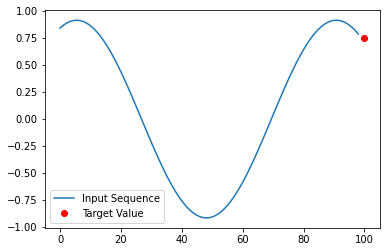

In [10]:
# Generate Sinusoidal Wave Dataset

def generate_sine_wave_data(num_samples, num_timesteps, freq_range, amp_range):
    """
    Generate sine wave data with varying frequencies, amplitudes, and random phase shifts.
    The last value in each sequence is used as the target prediction.

    Parameters:
    - num_samples: Number of samples to generate.
    - num_timesteps: Number of timesteps for each sample.
    - freq_range: Tuple of floor and ceiling of frequency range.
    - amp_range: Tuple of floor and ceiling of amplitude range.

    Returns:
    - X: Generated sine wave data of shape (num_samples, num_timesteps - 1).
    - y: Target values of shape (num_samples,).
    """
    X = np.zeros((num_samples, num_timesteps - 1))
    y = np.zeros(num_samples)
    for i in range(num_samples):
        ### START CODE HERE ###
        # Choose the frequency, amplitude and shift phase value.
        freq = np.random.uniform(*freq_range)                   # Random choose from freq_range.
        amp = np.random.uniform(*amp_range)     # Random choose from amp_range.
        phase_shift = np.random.uniform(0, 2 * np.pi)           # Random choose from (0, 2*pi).
        ### END CODE HERE ###

        t = np.linspace(0, 2 * np.pi, num_timesteps)
        sine_wave = amp * np.sin(freq * t + phase_shift)
        X[i] = sine_wave[:-1]  # All but the last value
        y[i] = sine_wave[-1]   # The last value
    return X, y

### START CODE HERE ###
# You can modify to your preferred range and number of samples. (Note: It's recommended to cover the range of testing data mentioned above.)
num_samples = 6400
num_timesteps = 100
freq_range = (0.5, 5.0)  # Frequency range
amp_range = (0.5, 5.0)   # Amplitude range
### END CODE HERE ###

X, y = generate_sine_wave_data(num_samples, num_timesteps, freq_range, amp_range)

### START CODE HERE ###
# Split data into training and validation sets
split_ratio = 0.8
split_idx = int(num_samples * split_ratio)
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]
### END CODE HERE ###

# Plot an example sequence
plt.plot(X_train[0], label='Input Sequence')
plt.plot(np.arange(num_timesteps, num_timesteps + 1), y_train[0], 'ro', label='Target Value')
plt.legend()
plt.show()


### Construct the model with Dense layer only
Here, we want you to construct the model with **Dense layer only** like you did in Lab4. You may modify the model structure and parameters in the way you like.

Epoch 1/20: 100%|██████████| 640/640 [00:05<00:00, 106.70batch/s, loss=0.442]


Epoch 1/20, Training Loss: 0.44197539140602793
Epoch 1/20, Validation Loss: 0.023366433573829053


Epoch 2/20: 100%|██████████| 640/640 [00:03<00:00, 161.02batch/s, loss=0.0105]


Epoch 2/20, Training Loss: 0.010524541497631937
Epoch 2/20, Validation Loss: 0.01034575344902839


Epoch 3/20: 100%|██████████| 640/640 [00:04<00:00, 144.88batch/s, loss=0.0056] 


Epoch 3/20, Training Loss: 0.005598332842896711
Epoch 3/20, Validation Loss: 0.006822578868390325


Epoch 4/20: 100%|██████████| 640/640 [00:03<00:00, 165.38batch/s, loss=0.00383]


Epoch 4/20, Training Loss: 0.0038296994680222913
Epoch 4/20, Validation Loss: 0.005099472258318744


Epoch 5/20: 100%|██████████| 640/640 [00:05<00:00, 125.75batch/s, loss=0.00288]


Epoch 5/20, Training Loss: 0.002879929360110418
Epoch 5/20, Validation Loss: 0.004036353435505241


Epoch 6/20: 100%|██████████| 640/640 [00:03<00:00, 160.91batch/s, loss=0.00229]


Epoch 6/20, Training Loss: 0.0022933331862168113
Epoch 6/20, Validation Loss: 0.003358383214362659


Epoch 7/20: 100%|██████████| 640/640 [00:03<00:00, 160.01batch/s, loss=0.0019] 


Epoch 7/20, Training Loss: 0.0018974267185018555
Epoch 7/20, Validation Loss: 0.002881846520229229


Epoch 8/20: 100%|██████████| 640/640 [00:04<00:00, 139.48batch/s, loss=0.00162]


Epoch 8/20, Training Loss: 0.0016156740660020752
Epoch 8/20, Validation Loss: 0.002528373025256033


Epoch 9/20: 100%|██████████| 640/640 [00:04<00:00, 159.10batch/s, loss=0.0014] 


Epoch 9/20, Training Loss: 0.0014046041845130434
Epoch 9/20, Validation Loss: 0.002255990764445639


Epoch 10/20: 100%|██████████| 640/640 [00:04<00:00, 141.39batch/s, loss=0.00124]


Epoch 10/20, Training Loss: 0.0012411140507113633
Epoch 10/20, Validation Loss: 0.002048277559848385


Epoch 11/20: 100%|██████████| 640/640 [00:03<00:00, 165.69batch/s, loss=0.00111]


Epoch 11/20, Training Loss: 0.0011100035060977096
Epoch 11/20, Validation Loss: 0.0018810991096014113


Epoch 12/20: 100%|██████████| 640/640 [00:03<00:00, 160.54batch/s, loss=0.001]   


Epoch 12/20, Training Loss: 0.00100291981609713
Epoch 12/20, Validation Loss: 0.0017385914743004178


Epoch 13/20: 100%|██████████| 640/640 [00:04<00:00, 148.53batch/s, loss=0.000913]


Epoch 13/20, Training Loss: 0.0009133023613662337
Epoch 13/20, Validation Loss: 0.0016248418109074477


Epoch 14/20: 100%|██████████| 640/640 [00:03<00:00, 163.82batch/s, loss=0.000839]


Epoch 14/20, Training Loss: 0.0008386439240433178
Epoch 14/20, Validation Loss: 0.001516001009809562


Epoch 15/20: 100%|██████████| 640/640 [00:04<00:00, 145.68batch/s, loss=0.000774]


Epoch 15/20, Training Loss: 0.0007743021911754103
Epoch 15/20, Validation Loss: 0.0014317828394260668


Epoch 16/20: 100%|██████████| 640/640 [00:04<00:00, 129.73batch/s, loss=0.000719]


Epoch 16/20, Training Loss: 0.000719180148842359
Epoch 16/20, Validation Loss: 0.0013522117524433469


Epoch 17/20: 100%|██████████| 640/640 [00:04<00:00, 144.43batch/s, loss=0.00067] 


Epoch 17/20, Training Loss: 0.0006704968591902318
Epoch 17/20, Validation Loss: 0.0012870973595920168


Epoch 18/20: 100%|██████████| 640/640 [00:03<00:00, 163.99batch/s, loss=0.000628]


Epoch 18/20, Training Loss: 0.0006281250389051836
Epoch 18/20, Validation Loss: 0.0012251901369684022


Epoch 19/20: 100%|██████████| 640/640 [00:03<00:00, 165.66batch/s, loss=0.000591]


Epoch 19/20, Training Loss: 0.0005906526931595419
Epoch 19/20, Validation Loss: 0.0011733707906263816


Epoch 20/20: 100%|██████████| 640/640 [00:04<00:00, 139.72batch/s, loss=0.000558]


Epoch 20/20, Training Loss: 0.0005578376055536604
Epoch 20/20, Validation Loss: 0.001123348128008205
Mean Absolute Error: 0.022185942495230003


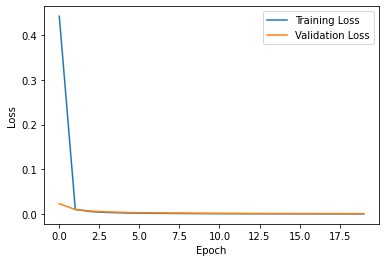

In [11]:
### START CODE HERE ###
# Change the structure and parameters to train your own model (Only contain Dense layer here!!!)
# Reshape the input data to fit Dense model
input_size = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])
y_val = y_val.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
# Construct the model with Dense layers

model = Model()
model.add(Dense(input_size, 1024))
model.add(Activation("relu", None))
model.add(Dense(1024, 256))
model.add(Activation("relu", None))
model.add(Dense(256, 64))
model.add(Activation("relu", None))
model.add(Dense(64, 1))
model.add(Activation("linear", None))

# Train the model
model.train(X_train, y_train, X_val, y_val, epochs=20, learning_rate=0.004, batch_size=8, loss_function='mse')

# Predict the validation set
y_pred = model.predict(X_val)
# MAE
mae = np.mean(np.abs(y_pred - y_val))
print(f"Mean Absolute Error: {mae}")

### END CODE HERE ###

# Plot the training and validation losses
model.plot_losses()

#### Predict testing data & Save the answer (For Dense model)
For this prediction of Dense model, you can choose not to submit it to Kaggle if its performance is not better.

In [12]:
### START CODE HERE ###
# Read the X_test.csv file into a DataFrame
# Change the path if needed
# download
X_test_df = pd.read_csv('dataset/basic/X_test.csv')
### END CODE HERE ###

# Do not modify this part to get the correct output format!!
# Drop the 'Id' column if it exists
if 'Id' in X_test_df.columns:
    X_test_df = X_test_df.drop(columns=['Id'])

# Convert the DataFrame to a numpy array
X_test = X_test_df.values
y_pred = model.predict(X_test)

# Convert the list of predictions to a numpy array
y_pred = np.array(y_pred)
y_pred_df = pd.DataFrame(y_pred, columns=['answer'])
y_pred_df.insert(0, 'Id', range(1, 1 + len(y_pred_df)))
y_pred_df.to_csv('y_pred_basic.csv', index=False)

print('Prediction data has been saved.')

Prediction data has been saved.


### Construct the model with RNN layer
Then, we can integrate our custom-built RNN layer into the model to evaluate whether it improves performance on the sequential inputs.

Epoch 1/20: 100%|██████████| 640/640 [00:03<00:00, 183.44batch/s, loss=0.765]


Epoch 1/20, Training Loss: 0.7654369578823526
Epoch 1/20, Validation Loss: 0.1983235957462519


Epoch 2/20: 100%|██████████| 640/640 [00:03<00:00, 177.96batch/s, loss=0.137]


Epoch 2/20, Training Loss: 0.13719048269587839
Epoch 2/20, Validation Loss: 0.09880388985098787


Epoch 3/20: 100%|██████████| 640/640 [00:03<00:00, 180.25batch/s, loss=0.0612]


Epoch 3/20, Training Loss: 0.06122325790088594
Epoch 3/20, Validation Loss: 0.03767655742838629


Epoch 4/20: 100%|██████████| 640/640 [00:03<00:00, 180.12batch/s, loss=0.0204]


Epoch 4/20, Training Loss: 0.020361894057245845
Epoch 4/20, Validation Loss: 0.013255332178904317


Epoch 5/20: 100%|██████████| 640/640 [00:03<00:00, 181.41batch/s, loss=0.00862]


Epoch 5/20, Training Loss: 0.008623460361771293
Epoch 5/20, Validation Loss: 0.00782311188302432


Epoch 6/20: 100%|██████████| 640/640 [00:03<00:00, 181.15batch/s, loss=0.00628]


Epoch 6/20, Training Loss: 0.0062836142298441046
Epoch 6/20, Validation Loss: 0.006411990912977536


Epoch 7/20: 100%|██████████| 640/640 [00:03<00:00, 181.09batch/s, loss=0.00555]


Epoch 7/20, Training Loss: 0.005548083297399786
Epoch 7/20, Validation Loss: 0.005744707450485092


Epoch 8/20: 100%|██████████| 640/640 [00:03<00:00, 179.40batch/s, loss=0.00512]


Epoch 8/20, Training Loss: 0.005124734489008923
Epoch 8/20, Validation Loss: 0.005322685981225637


Epoch 9/20: 100%|██████████| 640/640 [00:03<00:00, 179.28batch/s, loss=0.00482]


Epoch 9/20, Training Loss: 0.00482377696778344
Epoch 9/20, Validation Loss: 0.005017544723294586


Epoch 10/20: 100%|██████████| 640/640 [00:03<00:00, 178.57batch/s, loss=0.00458]


Epoch 10/20, Training Loss: 0.0045842807244977305
Epoch 10/20, Validation Loss: 0.004779542693471426


Epoch 11/20: 100%|██████████| 640/640 [00:03<00:00, 179.39batch/s, loss=0.00439]


Epoch 11/20, Training Loss: 0.00438820012659026
Epoch 11/20, Validation Loss: 0.004581469189975913


Epoch 12/20: 100%|██████████| 640/640 [00:03<00:00, 180.34batch/s, loss=0.00422]


Epoch 12/20, Training Loss: 0.004219782976652274
Epoch 12/20, Validation Loss: 0.0044094204329699046


Epoch 13/20: 100%|██████████| 640/640 [00:03<00:00, 177.66batch/s, loss=0.00407]


Epoch 13/20, Training Loss: 0.004070089112456488
Epoch 13/20, Validation Loss: 0.004255403389988194


Epoch 14/20: 100%|██████████| 640/640 [00:03<00:00, 178.92batch/s, loss=0.00394]


Epoch 14/20, Training Loss: 0.003935469947459939
Epoch 14/20, Validation Loss: 0.0041172668758653495


Epoch 15/20: 100%|██████████| 640/640 [00:03<00:00, 179.06batch/s, loss=0.00381]


Epoch 15/20, Training Loss: 0.003812086556907042
Epoch 15/20, Validation Loss: 0.003989267699661563


Epoch 16/20: 100%|██████████| 640/640 [00:03<00:00, 177.78batch/s, loss=0.0037] 


Epoch 16/20, Training Loss: 0.0036982809232342607
Epoch 16/20, Validation Loss: 0.003870175154476531


Epoch 17/20: 100%|██████████| 640/640 [00:03<00:00, 181.36batch/s, loss=0.00359]


Epoch 17/20, Training Loss: 0.003592481303377782
Epoch 17/20, Validation Loss: 0.0037587623891769005


Epoch 18/20: 100%|██████████| 640/640 [00:03<00:00, 178.58batch/s, loss=0.00349]


Epoch 18/20, Training Loss: 0.003494450915720609
Epoch 18/20, Validation Loss: 0.003654178277953625


Epoch 19/20: 100%|██████████| 640/640 [00:03<00:00, 180.38batch/s, loss=0.0034] 


Epoch 19/20, Training Loss: 0.00340321384232039
Epoch 19/20, Validation Loss: 0.003559151993577528


Epoch 20/20: 100%|██████████| 640/640 [00:03<00:00, 180.05batch/s, loss=0.00332]


Epoch 20/20, Training Loss: 0.00331877215537595
Epoch 20/20, Validation Loss: 0.003469609847070256
Mean Absolute Error: 0.04217908660760613


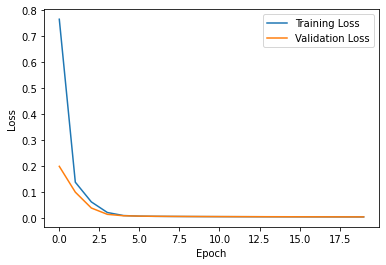

In [13]:
### START CODE HERE ###
# Change the structure and parameters to train your own model (Can add RNN layer here)
# Reshape X_train and X_val to fit the RNN layer input shape.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
y_val = y_val.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

# Construct the model & Set the parameters.
input_size = 1  # Number of input features (1 for single sine wave value)
rnn_units = 128  # Number of units in the RNN layer
dense_units = 64  # Number of units in the Dense layer
output_size = 1  # Number of output classes (1 for single sine wave value)

model = Model()
model.add(RNN(input_size, rnn_units))
model.add(Dense(rnn_units, dense_units))
model.add(Activation("relu", None))
model.add(Dense(dense_units, dense_units))
model.add(Activation("relu", None))
model.add(Dense(dense_units, output_size))
model.add(Activation("linear", None))

# Train the model
model.train(X_train, y_train, X_val, y_val, epochs=20, learning_rate=0.01, batch_size=8, loss_function='mse')

# Predict the validation set
y_pred = model.predict(X_val)
# MAE
mae = np.mean(np.abs(y_pred - y_val))
print(f"Mean Absolute Error: {mae}")

### END CODE HERE ###

# Plot the training and validation losses
model.plot_losses()

#### Predict testing data & Save the answer (For RNN model)
Remember to submit your prediction to Kaggle!

In [14]:
### START CODE HERE ###
# Read the X_test.csv file into a DataFrame
# Change the path if needed
X_test_df = pd.read_csv('dataset/basic/X_test.csv')
### END CODE HERE ###


# Do not modify this part to get the correct output format!!
# Drop the 'Id' column if it exists
if 'Id' in X_test_df.columns:
    X_test_df = X_test_df.drop(columns=['Id'])

# Convert the DataFrame to a numpy array
X_test = X_test_df.values
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # reshape the X_test to fit RNN layer input shape.
y_pred = model.predict(X_test)


# Convert the list of predictions to a numpy array
y_pred = np.array(y_pred)
y_pred_df = pd.DataFrame(y_pred, columns=['answer'])
y_pred_df.insert(0, 'Id', range(1, 1 + len(y_pred_df)))
y_pred_df.to_csv('y_pred_basic.csv', index=False)

print('Prediction data has been saved.')

Prediction data has been saved.


# Advance part (35%)






## Accelerometer and Gyroscope dataset
- ⚠⚠ You need to download the training & testing data from Kaggle. ⚠⚠ (Put it into the directory name `Activity data`, or your need to change the path in template.)
- In this dataset, we provide the time-series Accelerometer and Gyroscope data each with 3-axial (x, y, z) (total 6 channels).
- We classified the activity into 3 different classes:
    Activity 1, 2, 3\
    You have to build a RNN model using these time-series data to predict the activity class.
- Steps:
    1. Load the provided `X_train.npy`, `y_train.npy` and `X_test.npy` and split the part of training data to validation.\
    Note: `y_train.npy` is already one-hot encoded.
    2. Visualize the `X_train.npy`.
    3. One-hot encode the `y_train.npy` for three classes: Activity 1, Activity 2, Activity 3.
    4. Build your own RNN model and train it.
    5. Predict with the `X_test.npy` and generate `y_test.csv` then **submit it to Kaggle**!
- We have set 3 baselines on public score:
    * Accuracy >= 0.65 -> 10 points
    * Accuracy >= 0.7  -> 20 points
    * Accuracy >= 0.75 -> 25 points
- Kaggle link: https://www.kaggle.com/t/95e0b11f63e74566802b0dea5ec4f1b4


### 1. Load training & testing data
Load the training and testing data, then split the training data into a validation set using your preferred ratio.

In [15]:
### START CODE HERE ###
# Load X_train, y_train and X_test data
# Change the path if needed
X_train = np.load('dataset/advanced/X_train.npy')
y_train = np.load('dataset/advanced/y_train.npy')
X_test = np.load('dataset/advanced/X_test.npy')
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
### END CODE HERE ###

### START CODE HERE ###
# Define the validation ratio in your preferred way
# 1. One-hot encode y_train. (3 classes)
# 2. Split the X_train, y_train data into train & validation set.
num_classes = 3
y_train = np.eye(num_classes)[y_train] # one-hot encode y_train

validation_ratio = 0.1
split_idx = int(X_train.shape[0] * (1 - validation_ratio))
X_train, X_val = X_train[:split_idx], X_train[split_idx:]
y_train, y_val = y_train[:split_idx], y_train[split_idx:]
### END CODE HERE ###

X_train shape: (7352, 128, 6)
y_train shape: (7352, 1)
X_test shape: (2947, 128, 6)


### 2. Visualize the training data

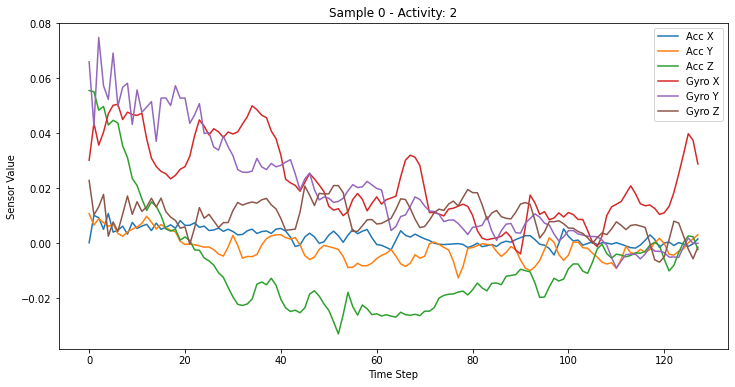

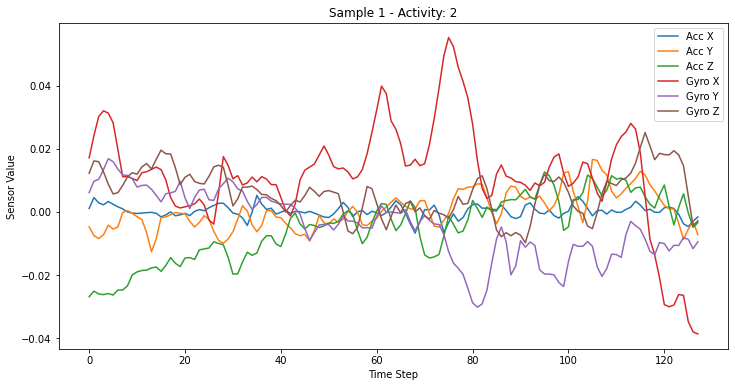

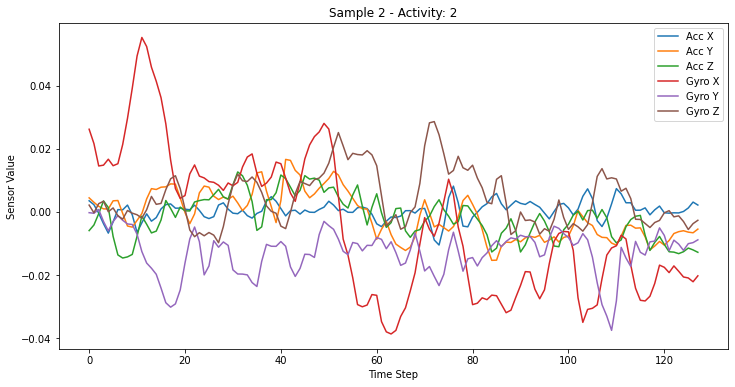

In [16]:
# Function to plot a single sample
def plot_sample(X, y, sample_index):
    plt.figure(figsize=(12, 6))
    plt.plot(X[sample_index, :, 0], label='Acc X')
    plt.plot(X[sample_index, :, 1], label='Acc Y')
    plt.plot(X[sample_index, :, 2], label='Acc Z')
    plt.plot(X[sample_index, :, 3], label='Gyro X')
    plt.plot(X[sample_index, :, 4], label='Gyro Y')
    plt.plot(X[sample_index, :, 5], label='Gyro Z')
    plt.title(f'Sample {sample_index} - Activity: {np.argmax(y[sample_index])}')
    plt.xlabel('Time Step')
    plt.ylabel('Sensor Value')
    plt.legend()
    plt.show()

### START CODE HERE ###
# Plot a few samples
for i in range(3):              # Change the range to visualize more samples
    plot_sample(X_train, y_train, i)
 ### END CODE HERE ###

### 3. Contruct and train the model

Epoch 1/20: 100%|██████████| 413/413 [00:04<00:00, 89.87batch/s, loss=0.976]


Epoch 1/20, Training Loss: 0.9800776769989205
Epoch 1/20, Validation Loss: 0.9576708220188105


Epoch 2/20: 100%|██████████| 413/413 [00:04<00:00, 89.36batch/s, loss=0.9]  


Epoch 2/20, Training Loss: 0.9033501431030581
Epoch 2/20, Validation Loss: 0.7964651686462593


Epoch 3/20: 100%|██████████| 413/413 [00:04<00:00, 90.15batch/s, loss=0.68] 


Epoch 3/20, Training Loss: 0.6834019443414132
Epoch 3/20, Validation Loss: 0.5550710473330388


Epoch 4/20: 100%|██████████| 413/413 [00:04<00:00, 90.24batch/s, loss=0.545]


Epoch 4/20, Training Loss: 0.5485495879465064
Epoch 4/20, Validation Loss: 0.46543967002118175


Epoch 5/20: 100%|██████████| 413/413 [00:04<00:00, 89.24batch/s, loss=0.485]


Epoch 5/20, Training Loss: 0.48765760860284635
Epoch 5/20, Validation Loss: 0.41911944290051556


Epoch 6/20: 100%|██████████| 413/413 [00:04<00:00, 89.45batch/s, loss=0.452]


Epoch 6/20, Training Loss: 0.45372592309819937
Epoch 6/20, Validation Loss: 0.40559739281831675


Epoch 7/20: 100%|██████████| 413/413 [00:04<00:00, 89.49batch/s, loss=0.441]


Epoch 7/20, Training Loss: 0.44341371432521787
Epoch 7/20, Validation Loss: 0.40422097277142416


Epoch 8/20: 100%|██████████| 413/413 [00:04<00:00, 88.54batch/s, loss=0.436]


Epoch 8/20, Training Loss: 0.437840923587317
Epoch 8/20, Validation Loss: 0.40165832734176377


Epoch 9/20: 100%|██████████| 413/413 [00:04<00:00, 90.22batch/s, loss=0.431]


Epoch 9/20, Training Loss: 0.43307735235515704
Epoch 9/20, Validation Loss: 0.39903158392007676


Epoch 10/20: 100%|██████████| 413/413 [00:04<00:00, 89.57batch/s, loss=0.426]


Epoch 10/20, Training Loss: 0.42814021452511536
Epoch 10/20, Validation Loss: 0.395107281545831


Epoch 11/20: 100%|██████████| 413/413 [00:04<00:00, 90.07batch/s, loss=0.418]


Epoch 11/20, Training Loss: 0.420745043330083
Epoch 11/20, Validation Loss: 0.39443104950283964


Epoch 12/20: 100%|██████████| 413/413 [00:04<00:00, 82.69batch/s, loss=0.41] 


Epoch 12/20, Training Loss: 0.4123020620283934
Epoch 12/20, Validation Loss: 0.39321835996520865


Epoch 13/20: 100%|██████████| 413/413 [00:04<00:00, 90.47batch/s, loss=0.401]


Epoch 13/20, Training Loss: 0.4031489774171365
Epoch 13/20, Validation Loss: 0.38717409578571504


Epoch 14/20: 100%|██████████| 413/413 [00:04<00:00, 90.73batch/s, loss=0.392]


Epoch 14/20, Training Loss: 0.3937561460813398
Epoch 14/20, Validation Loss: 0.37925755077790607


Epoch 15/20: 100%|██████████| 413/413 [00:04<00:00, 91.54batch/s, loss=0.383]


Epoch 15/20, Training Loss: 0.3857347970632819
Epoch 15/20, Validation Loss: 0.36678813739345073


Epoch 16/20: 100%|██████████| 413/413 [00:04<00:00, 89.75batch/s, loss=0.376]


Epoch 16/20, Training Loss: 0.37825997369447106
Epoch 16/20, Validation Loss: 0.35560244667027474


Epoch 17/20: 100%|██████████| 413/413 [00:04<00:00, 90.48batch/s, loss=0.37] 


Epoch 17/20, Training Loss: 0.3724017855783324
Epoch 17/20, Validation Loss: 0.3494313201670348


Epoch 18/20: 100%|██████████| 413/413 [00:04<00:00, 89.50batch/s, loss=0.363]


Epoch 18/20, Training Loss: 0.36519078717545217
Epoch 18/20, Validation Loss: 0.3504884281710135


Epoch 19/20: 100%|██████████| 413/413 [00:04<00:00, 90.39batch/s, loss=0.36] 


Epoch 19/20, Training Loss: 0.3619199725718325
Epoch 19/20, Validation Loss: 0.35018258441523975


Epoch 20/20: 100%|██████████| 413/413 [00:04<00:00, 89.62batch/s, loss=0.356]


Epoch 20/20, Training Loss: 0.3584829298637868
Epoch 20/20, Validation Loss: 0.348478657982461


Epoch 1/40: 100%|██████████| 206/206 [00:10<00:00, 20.48batch/s, loss=0.349]


Epoch 1/40, Training Loss: 0.35142169166892534
Epoch 1/40, Validation Loss: 0.34491312804859664


Epoch 2/40: 100%|██████████| 206/206 [00:10<00:00, 18.75batch/s, loss=0.347]


Epoch 2/40, Training Loss: 0.34966605851144483
Epoch 2/40, Validation Loss: 0.3435623401626035


Epoch 3/40: 100%|██████████| 206/206 [00:09<00:00, 22.44batch/s, loss=0.346]


Epoch 3/40, Training Loss: 0.3483266477813458
Epoch 3/40, Validation Loss: 0.3422727635937217


Epoch 4/40: 100%|██████████| 206/206 [00:09<00:00, 22.39batch/s, loss=0.345]


Epoch 4/40, Training Loss: 0.34698235101693514
Epoch 4/40, Validation Loss: 0.3407840535106613


Epoch 5/40: 100%|██████████| 206/206 [00:09<00:00, 22.87batch/s, loss=0.343]


Epoch 5/40, Training Loss: 0.3458146047797711
Epoch 5/40, Validation Loss: 0.3391725439106291


Epoch 6/40: 100%|██████████| 206/206 [00:08<00:00, 23.37batch/s, loss=0.342]


Epoch 6/40, Training Loss: 0.3447027918886563
Epoch 6/40, Validation Loss: 0.3379564472988291


Epoch 7/40: 100%|██████████| 206/206 [00:12<00:00, 16.36batch/s, loss=0.341]


Epoch 7/40, Training Loss: 0.3437789288421379
Epoch 7/40, Validation Loss: 0.33679577517661696


Epoch 8/40: 100%|██████████| 206/206 [00:10<00:00, 19.42batch/s, loss=0.34] 


Epoch 8/40, Training Loss: 0.3427160669793373
Epoch 8/40, Validation Loss: 0.33538570034862686


Epoch 9/40: 100%|██████████| 206/206 [00:10<00:00, 20.52batch/s, loss=0.339]


Epoch 9/40, Training Loss: 0.34161977648824526
Epoch 9/40, Validation Loss: 0.3340080470001434


Epoch 10/40: 100%|██████████| 206/206 [00:08<00:00, 23.27batch/s, loss=0.338]


Epoch 10/40, Training Loss: 0.340669698371043
Epoch 10/40, Validation Loss: 0.3324416902592202


Epoch 11/40: 100%|██████████| 206/206 [00:08<00:00, 25.21batch/s, loss=0.337]


Epoch 11/40, Training Loss: 0.3397183415854943
Epoch 11/40, Validation Loss: 0.33139438603134586


Epoch 12/40: 100%|██████████| 206/206 [00:08<00:00, 23.74batch/s, loss=0.336]


Epoch 12/40, Training Loss: 0.33872996008737466
Epoch 12/40, Validation Loss: 0.3302753210231984


Epoch 13/40: 100%|██████████| 206/206 [00:10<00:00, 20.60batch/s, loss=0.335]


Epoch 13/40, Training Loss: 0.3377621027278005
Epoch 13/40, Validation Loss: 0.32933993133875206


Epoch 14/40: 100%|██████████| 206/206 [00:09<00:00, 21.20batch/s, loss=0.334]


Epoch 14/40, Training Loss: 0.3368226494742333
Epoch 14/40, Validation Loss: 0.32842815490661437


Epoch 15/40: 100%|██████████| 206/206 [00:09<00:00, 21.83batch/s, loss=0.333]


Epoch 15/40, Training Loss: 0.3358412570205187
Epoch 15/40, Validation Loss: 0.3276085549255779


Epoch 16/40: 100%|██████████| 206/206 [00:09<00:00, 21.54batch/s, loss=0.332]


Epoch 16/40, Training Loss: 0.33497779094912983
Epoch 16/40, Validation Loss: 0.3268596412831738


Epoch 17/40: 100%|██████████| 206/206 [00:09<00:00, 22.77batch/s, loss=0.332]


Epoch 17/40, Training Loss: 0.33411076266288287
Epoch 17/40, Validation Loss: 0.32639337496417525


Epoch 18/40: 100%|██████████| 206/206 [00:09<00:00, 21.22batch/s, loss=0.331]


Epoch 18/40, Training Loss: 0.3333979347774176
Epoch 18/40, Validation Loss: 0.32596957647765074


Epoch 19/40: 100%|██████████| 206/206 [00:09<00:00, 21.23batch/s, loss=0.33] 


Epoch 19/40, Training Loss: 0.3325460162946033
Epoch 19/40, Validation Loss: 0.32531208367893166


Epoch 20/40: 100%|██████████| 206/206 [00:09<00:00, 22.14batch/s, loss=0.329]


Epoch 20/40, Training Loss: 0.33168887810902786
Epoch 20/40, Validation Loss: 0.32464189191831944


Epoch 21/40: 100%|██████████| 206/206 [00:10<00:00, 19.65batch/s, loss=0.328]


Epoch 21/40, Training Loss: 0.33091065270334236
Epoch 21/40, Validation Loss: 0.32417346475129494


Epoch 22/40: 100%|██████████| 206/206 [00:09<00:00, 21.81batch/s, loss=0.328]


Epoch 22/40, Training Loss: 0.3299717204410724
Epoch 22/40, Validation Loss: 0.323562488212258


Epoch 23/40: 100%|██████████| 206/206 [00:09<00:00, 22.37batch/s, loss=0.327]


Epoch 23/40, Training Loss: 0.3290450230442355
Epoch 23/40, Validation Loss: 0.32283629692982674


Epoch 24/40: 100%|██████████| 206/206 [00:09<00:00, 22.12batch/s, loss=0.326]


Epoch 24/40, Training Loss: 0.32821359158719865
Epoch 24/40, Validation Loss: 0.3223034386645381


Epoch 25/40: 100%|██████████| 206/206 [00:09<00:00, 21.49batch/s, loss=0.325]


Epoch 25/40, Training Loss: 0.32727270540535147
Epoch 25/40, Validation Loss: 0.321591571533368


Epoch 26/40: 100%|██████████| 206/206 [00:10<00:00, 19.90batch/s, loss=0.324]


Epoch 26/40, Training Loss: 0.32639345565733846
Epoch 26/40, Validation Loss: 0.32086956332780225


Epoch 27/40: 100%|██████████| 206/206 [00:09<00:00, 21.90batch/s, loss=0.323]


Epoch 27/40, Training Loss: 0.32546337459215574
Epoch 27/40, Validation Loss: 0.3202005778045815


Epoch 28/40: 100%|██████████| 206/206 [00:09<00:00, 21.43batch/s, loss=0.322]


Epoch 28/40, Training Loss: 0.32435914281547656
Epoch 28/40, Validation Loss: 0.31947887620131593


Epoch 29/40: 100%|██████████| 206/206 [00:10<00:00, 20.10batch/s, loss=0.321]


Epoch 29/40, Training Loss: 0.3233140465262223
Epoch 29/40, Validation Loss: 0.3192358558149454


Epoch 30/40: 100%|██████████| 206/206 [00:09<00:00, 21.84batch/s, loss=0.32] 


Epoch 30/40, Training Loss: 0.32212958418245724
Epoch 30/40, Validation Loss: 0.316924484822541


Epoch 31/40: 100%|██████████| 206/206 [00:09<00:00, 21.57batch/s, loss=0.319]


Epoch 31/40, Training Loss: 0.3208381365140951
Epoch 31/40, Validation Loss: 0.3161614249989259


Epoch 32/40: 100%|██████████| 206/206 [00:09<00:00, 22.29batch/s, loss=0.317]


Epoch 32/40, Training Loss: 0.31963968681449545
Epoch 32/40, Validation Loss: 0.31511165192656065


Epoch 33/40: 100%|██████████| 206/206 [00:09<00:00, 21.31batch/s, loss=0.316]


Epoch 33/40, Training Loss: 0.3182181503067773
Epoch 33/40, Validation Loss: 0.31362310178478486


Epoch 34/40: 100%|██████████| 206/206 [00:09<00:00, 22.13batch/s, loss=0.315]


Epoch 34/40, Training Loss: 0.31686040851476754
Epoch 34/40, Validation Loss: 0.31262765009868565


Epoch 35/40: 100%|██████████| 206/206 [00:08<00:00, 23.60batch/s, loss=0.313]


Epoch 35/40, Training Loss: 0.31544273931500355
Epoch 35/40, Validation Loss: 0.31118051258041435


Epoch 36/40: 100%|██████████| 206/206 [00:09<00:00, 22.14batch/s, loss=0.311]


Epoch 36/40, Training Loss: 0.31337460427008274
Epoch 36/40, Validation Loss: 0.30902190101286664


Epoch 37/40: 100%|██████████| 206/206 [00:09<00:00, 22.56batch/s, loss=0.308]


Epoch 37/40, Training Loss: 0.310401193087147
Epoch 37/40, Validation Loss: 0.307351115180322


Epoch 38/40: 100%|██████████| 206/206 [00:09<00:00, 22.56batch/s, loss=0.304]


Epoch 38/40, Training Loss: 0.3065106678015997
Epoch 38/40, Validation Loss: 0.30497444862768847


Epoch 39/40: 100%|██████████| 206/206 [00:09<00:00, 21.96batch/s, loss=0.3]  


Epoch 39/40, Training Loss: 0.30215580251680974
Epoch 39/40, Validation Loss: 0.30055598839252


Epoch 40/40: 100%|██████████| 206/206 [00:09<00:00, 22.47batch/s, loss=0.295]


Epoch 40/40, Training Loss: 0.29699299668637374
Epoch 40/40, Validation Loss: 0.29318822134554406


Epoch 1/40: 100%|██████████| 137/137 [00:11<00:00, 11.69batch/s, loss=0.286]


Epoch 1/40, Training Loss: 0.2865980803770223
Epoch 1/40, Validation Loss: 0.2879667983817196


Epoch 2/40: 100%|██████████| 137/137 [00:11<00:00, 11.59batch/s, loss=0.284]


Epoch 2/40, Training Loss: 0.2841220969966874
Epoch 2/40, Validation Loss: 0.28517363143658964


Epoch 3/40: 100%|██████████| 137/137 [00:13<00:00,  9.86batch/s, loss=0.281]


Epoch 3/40, Training Loss: 0.28173002124988533
Epoch 3/40, Validation Loss: 0.2827192136789848


Epoch 4/40: 100%|██████████| 137/137 [00:13<00:00, 10.03batch/s, loss=0.279]


Epoch 4/40, Training Loss: 0.27933934438484104
Epoch 4/40, Validation Loss: 0.28019021186035764


Epoch 5/40: 100%|██████████| 137/137 [00:15<00:00,  9.03batch/s, loss=0.276]


Epoch 5/40, Training Loss: 0.2767895013534298
Epoch 5/40, Validation Loss: 0.2779092833525789


Epoch 6/40: 100%|██████████| 137/137 [00:12<00:00, 10.96batch/s, loss=0.274]


Epoch 6/40, Training Loss: 0.2741537951044551
Epoch 6/40, Validation Loss: 0.27513856083203597


Epoch 7/40: 100%|██████████| 137/137 [00:12<00:00, 11.16batch/s, loss=0.27] 


Epoch 7/40, Training Loss: 0.2709941894183024
Epoch 7/40, Validation Loss: 0.27231330410571497


Epoch 8/40: 100%|██████████| 137/137 [00:12<00:00, 10.94batch/s, loss=0.267]


Epoch 8/40, Training Loss: 0.26757154175342124
Epoch 8/40, Validation Loss: 0.2695932028744479


Epoch 9/40: 100%|██████████| 137/137 [00:13<00:00, 10.16batch/s, loss=0.263]


Epoch 9/40, Training Loss: 0.26383047944480054
Epoch 9/40, Validation Loss: 0.26671499781827923


Epoch 10/40: 100%|██████████| 137/137 [00:11<00:00, 11.66batch/s, loss=0.259]


Epoch 10/40, Training Loss: 0.2602749364065697
Epoch 10/40, Validation Loss: 0.26385456283711134


Epoch 11/40: 100%|██████████| 137/137 [00:13<00:00, 10.38batch/s, loss=0.255]


Epoch 11/40, Training Loss: 0.25672121236001494
Epoch 11/40, Validation Loss: 0.26115740870180015


Epoch 12/40: 100%|██████████| 137/137 [00:13<00:00, 10.09batch/s, loss=0.252]


Epoch 12/40, Training Loss: 0.2531442424030003
Epoch 12/40, Validation Loss: 0.2576109439278353


Epoch 13/40: 100%|██████████| 137/137 [00:12<00:00, 11.38batch/s, loss=0.248]


Epoch 13/40, Training Loss: 0.24986414372546584
Epoch 13/40, Validation Loss: 0.2534554844914596


Epoch 14/40: 100%|██████████| 137/137 [00:12<00:00, 11.27batch/s, loss=0.245]


Epoch 14/40, Training Loss: 0.24660999462461894
Epoch 14/40, Validation Loss: 0.2486287051548322


Epoch 15/40: 100%|██████████| 137/137 [00:12<00:00, 11.37batch/s, loss=0.242]


Epoch 15/40, Training Loss: 0.243164235930984
Epoch 15/40, Validation Loss: 0.24376853924582292


Epoch 16/40: 100%|██████████| 137/137 [00:12<00:00, 11.14batch/s, loss=0.238]


Epoch 16/40, Training Loss: 0.23969523387578545
Epoch 16/40, Validation Loss: 0.23817598110161667


Epoch 17/40: 100%|██████████| 137/137 [00:12<00:00, 10.70batch/s, loss=0.235]


Epoch 17/40, Training Loss: 0.23625238677953672
Epoch 17/40, Validation Loss: 0.23222960896843314


Epoch 18/40: 100%|██████████| 137/137 [00:12<00:00, 11.10batch/s, loss=0.231]


Epoch 18/40, Training Loss: 0.23246649142951242
Epoch 18/40, Validation Loss: 0.22495213680152285


Epoch 19/40: 100%|██████████| 137/137 [00:11<00:00, 11.50batch/s, loss=0.227]


Epoch 19/40, Training Loss: 0.22854070776669
Epoch 19/40, Validation Loss: 0.21802212243464128


Epoch 20/40: 100%|██████████| 137/137 [00:11<00:00, 11.61batch/s, loss=0.223]


Epoch 20/40, Training Loss: 0.22417794199868263
Epoch 20/40, Validation Loss: 0.21105340668274014


Epoch 21/40: 100%|██████████| 137/137 [00:12<00:00, 11.36batch/s, loss=0.218]


Epoch 21/40, Training Loss: 0.21962545442221862
Epoch 21/40, Validation Loss: 0.20335187963695836


Epoch 22/40: 100%|██████████| 137/137 [00:11<00:00, 11.47batch/s, loss=0.213]


Epoch 22/40, Training Loss: 0.2142985464192655
Epoch 22/40, Validation Loss: 0.1949292232020764


Epoch 23/40: 100%|██████████| 137/137 [00:11<00:00, 11.69batch/s, loss=0.207]


Epoch 23/40, Training Loss: 0.2085923893960592
Epoch 23/40, Validation Loss: 0.1880350469161905


Epoch 24/40: 100%|██████████| 137/137 [00:11<00:00, 11.65batch/s, loss=0.202]


Epoch 24/40, Training Loss: 0.203569885433509
Epoch 24/40, Validation Loss: 0.18259273707334472


Epoch 25/40: 100%|██████████| 137/137 [00:11<00:00, 11.59batch/s, loss=0.198]


Epoch 25/40, Training Loss: 0.1991736648841994
Epoch 25/40, Validation Loss: 0.17752022849297913


Epoch 26/40: 100%|██████████| 137/137 [00:12<00:00, 10.95batch/s, loss=0.193]


Epoch 26/40, Training Loss: 0.19410894394344325
Epoch 26/40, Validation Loss: 0.1743324264483766


Epoch 27/40: 100%|██████████| 137/137 [00:11<00:00, 11.58batch/s, loss=0.188]


Epoch 27/40, Training Loss: 0.1895118392820269
Epoch 27/40, Validation Loss: 0.16995284560514506


Epoch 28/40: 100%|██████████| 137/137 [00:11<00:00, 11.95batch/s, loss=0.189]


Epoch 28/40, Training Loss: 0.1901241106266964
Epoch 28/40, Validation Loss: 0.17096880837908363


Epoch 29/40: 100%|██████████| 137/137 [00:12<00:00, 11.20batch/s, loss=0.184]


Epoch 29/40, Training Loss: 0.18490920644619316
Epoch 29/40, Validation Loss: 0.16216066311865293


Epoch 30/40: 100%|██████████| 137/137 [00:11<00:00, 11.64batch/s, loss=0.233]


Epoch 30/40, Training Loss: 0.23462083562872169
Epoch 30/40, Validation Loss: 0.3248093923533195


Epoch 31/40: 100%|██████████| 137/137 [00:14<00:00,  9.78batch/s, loss=0.251]


Epoch 31/40, Training Loss: 0.25121640153013897
Epoch 31/40, Validation Loss: 0.2108803874396559


Epoch 32/40: 100%|██████████| 137/137 [00:11<00:00, 11.83batch/s, loss=0.195]


Epoch 32/40, Training Loss: 0.19571381869550084
Epoch 32/40, Validation Loss: 0.17725212677492766


Epoch 33/40: 100%|██████████| 137/137 [00:11<00:00, 12.15batch/s, loss=0.177]


Epoch 33/40, Training Loss: 0.17831146596786288
Epoch 33/40, Validation Loss: 0.15758854446424977


Epoch 34/40: 100%|██████████| 137/137 [00:11<00:00, 12.20batch/s, loss=0.177]


Epoch 34/40, Training Loss: 0.1778108283514655
Epoch 34/40, Validation Loss: 0.15584903639628972


Epoch 35/40: 100%|██████████| 137/137 [00:13<00:00, 10.28batch/s, loss=0.172]


Epoch 35/40, Training Loss: 0.17231938736106617
Epoch 35/40, Validation Loss: 0.1464983240446085


Epoch 36/40: 100%|██████████| 137/137 [00:11<00:00, 11.90batch/s, loss=0.17] 


Epoch 36/40, Training Loss: 0.1704558005728244
Epoch 36/40, Validation Loss: 0.14361523022185896


Epoch 37/40: 100%|██████████| 137/137 [00:11<00:00, 11.72batch/s, loss=0.192]


Epoch 37/40, Training Loss: 0.192541668059984
Epoch 37/40, Validation Loss: 0.19100054981678075


Epoch 38/40: 100%|██████████| 137/137 [00:11<00:00, 11.79batch/s, loss=0.169]


Epoch 38/40, Training Loss: 0.1697247192111584
Epoch 38/40, Validation Loss: 0.1392902773559968


Epoch 39/40: 100%|██████████| 137/137 [00:11<00:00, 11.43batch/s, loss=0.201]


Epoch 39/40, Training Loss: 0.20236553771889973
Epoch 39/40, Validation Loss: 0.26259385596091644


Epoch 40/40: 100%|██████████| 137/137 [00:11<00:00, 11.50batch/s, loss=0.188]


Epoch 40/40, Training Loss: 0.1880166980507077
Epoch 40/40, Validation Loss: 0.15609670882481122


Epoch 1/40: 100%|██████████| 103/103 [00:09<00:00, 10.70batch/s, loss=0.146]


Epoch 1/40, Training Loss: 0.14611467854414364
Epoch 1/40, Validation Loss: 0.13065956423841496


Epoch 2/40: 100%|██████████| 103/103 [00:08<00:00, 12.40batch/s, loss=0.14]


Epoch 2/40, Training Loss: 0.13993384947173584
Epoch 2/40, Validation Loss: 0.12265229234623991


Epoch 3/40: 100%|██████████| 103/103 [00:08<00:00, 11.74batch/s, loss=0.139]


Epoch 3/40, Training Loss: 0.1387391521798286
Epoch 3/40, Validation Loss: 0.11998106477324022


Epoch 4/40: 100%|██████████| 103/103 [00:08<00:00, 12.77batch/s, loss=0.137]


Epoch 4/40, Training Loss: 0.13699339770902302
Epoch 4/40, Validation Loss: 0.11784570950566092


Epoch 5/40: 100%|██████████| 103/103 [00:08<00:00, 11.51batch/s, loss=0.136]


Epoch 5/40, Training Loss: 0.1359500895625055
Epoch 5/40, Validation Loss: 0.11672743994291705


Epoch 6/40: 100%|██████████| 103/103 [00:09<00:00, 11.36batch/s, loss=0.135]


Epoch 6/40, Training Loss: 0.1350911709489801
Epoch 6/40, Validation Loss: 0.11550939145897696


Epoch 7/40: 100%|██████████| 103/103 [00:09<00:00, 11.44batch/s, loss=0.135]


Epoch 7/40, Training Loss: 0.13438076888062422
Epoch 7/40, Validation Loss: 0.11488887304861191


Epoch 8/40: 100%|██████████| 103/103 [00:08<00:00, 11.97batch/s, loss=0.134]


Epoch 8/40, Training Loss: 0.13355029712098251
Epoch 8/40, Validation Loss: 0.11411892959505378


Epoch 9/40: 100%|██████████| 103/103 [00:09<00:00, 10.53batch/s, loss=0.133]


Epoch 9/40, Training Loss: 0.13253921174514544
Epoch 9/40, Validation Loss: 0.11295641657351697


Epoch 10/40: 100%|██████████| 103/103 [00:08<00:00, 12.49batch/s, loss=0.132]


Epoch 10/40, Training Loss: 0.1317505093142502
Epoch 10/40, Validation Loss: 0.11193149804432423


Epoch 11/40: 100%|██████████| 103/103 [00:08<00:00, 12.29batch/s, loss=0.131]


Epoch 11/40, Training Loss: 0.13087144293610412
Epoch 11/40, Validation Loss: 0.11096060313565513


Epoch 12/40: 100%|██████████| 103/103 [00:10<00:00, 10.20batch/s, loss=0.131]


Epoch 12/40, Training Loss: 0.1300426202754291
Epoch 12/40, Validation Loss: 0.1098369978310529


Epoch 13/40: 100%|██████████| 103/103 [00:09<00:00, 10.79batch/s, loss=0.13]


Epoch 13/40, Training Loss: 0.12907756278611893
Epoch 13/40, Validation Loss: 0.10887440176170297


Epoch 14/40: 100%|██████████| 103/103 [00:09<00:00, 10.37batch/s, loss=0.129]


Epoch 14/40, Training Loss: 0.12820066469338603
Epoch 14/40, Validation Loss: 0.1076838195385012


Epoch 15/40: 100%|██████████| 103/103 [00:08<00:00, 12.31batch/s, loss=0.128]


Epoch 15/40, Training Loss: 0.12744210575805906
Epoch 15/40, Validation Loss: 0.10661648174699426


Epoch 16/40: 100%|██████████| 103/103 [00:08<00:00, 12.24batch/s, loss=0.128]


Epoch 16/40, Training Loss: 0.1268558316083202
Epoch 16/40, Validation Loss: 0.10587977714391172


Epoch 17/40: 100%|██████████| 103/103 [00:08<00:00, 12.34batch/s, loss=0.127]


Epoch 17/40, Training Loss: 0.1261239731230424
Epoch 17/40, Validation Loss: 0.10490139403497416


Epoch 18/40: 100%|██████████| 103/103 [00:08<00:00, 11.86batch/s, loss=0.126]


Epoch 18/40, Training Loss: 0.12559272160264137
Epoch 18/40, Validation Loss: 0.10423631495478274


Epoch 19/40: 100%|██████████| 103/103 [00:08<00:00, 12.82batch/s, loss=0.126]


Epoch 19/40, Training Loss: 0.12481577505179797
Epoch 19/40, Validation Loss: 0.10319228636644119


Epoch 20/40: 100%|██████████| 103/103 [00:08<00:00, 11.55batch/s, loss=0.125]


Epoch 20/40, Training Loss: 0.12441836609351568
Epoch 20/40, Validation Loss: 0.10262620915018911


Epoch 21/40: 100%|██████████| 103/103 [00:08<00:00, 11.68batch/s, loss=0.125]


Epoch 21/40, Training Loss: 0.1237621701505191
Epoch 21/40, Validation Loss: 0.10157857045718549


Epoch 22/40: 100%|██████████| 103/103 [00:09<00:00, 10.51batch/s, loss=0.124]


Epoch 22/40, Training Loss: 0.12333476424987021
Epoch 22/40, Validation Loss: 0.10086122444411154


Epoch 23/40: 100%|██████████| 103/103 [00:08<00:00, 11.67batch/s, loss=0.124]


Epoch 23/40, Training Loss: 0.1226922573027581
Epoch 23/40, Validation Loss: 0.0995537594481737


Epoch 24/40: 100%|██████████| 103/103 [00:08<00:00, 12.27batch/s, loss=0.123]


Epoch 24/40, Training Loss: 0.12237754271198521
Epoch 24/40, Validation Loss: 0.10081421411234333


Epoch 25/40: 100%|██████████| 103/103 [00:08<00:00, 11.64batch/s, loss=0.123]


Epoch 25/40, Training Loss: 0.12172474947668184
Epoch 25/40, Validation Loss: 0.09974066815169971


Epoch 26/40: 100%|██████████| 103/103 [00:08<00:00, 11.86batch/s, loss=0.122]


Epoch 26/40, Training Loss: 0.12119067460823263
Epoch 26/40, Validation Loss: 0.0991636732570275


Epoch 27/40: 100%|██████████| 103/103 [00:09<00:00, 11.17batch/s, loss=0.122]


Epoch 27/40, Training Loss: 0.12071099218171742
Epoch 27/40, Validation Loss: 0.09853179669212603


Epoch 28/40: 100%|██████████| 103/103 [00:08<00:00, 12.20batch/s, loss=0.121]


Epoch 28/40, Training Loss: 0.11996066696481703
Epoch 28/40, Validation Loss: 0.09766652299931336


Epoch 29/40: 100%|██████████| 103/103 [00:07<00:00, 13.12batch/s, loss=0.12]


Epoch 29/40, Training Loss: 0.11948443245403087
Epoch 29/40, Validation Loss: 0.09653290457667967


Epoch 30/40: 100%|██████████| 103/103 [00:09<00:00, 10.60batch/s, loss=0.12]


Epoch 30/40, Training Loss: 0.11902188197275425
Epoch 30/40, Validation Loss: 0.09583725368626514


Epoch 31/40: 100%|██████████| 103/103 [00:08<00:00, 12.03batch/s, loss=0.119]


Epoch 31/40, Training Loss: 0.1183911130791931
Epoch 31/40, Validation Loss: 0.09508843949227243


Epoch 32/40: 100%|██████████| 103/103 [00:08<00:00, 12.03batch/s, loss=0.119]


Epoch 32/40, Training Loss: 0.1178101992040671
Epoch 32/40, Validation Loss: 0.09438902274694562


Epoch 33/40: 100%|██████████| 103/103 [00:08<00:00, 11.74batch/s, loss=0.119]


Epoch 33/40, Training Loss: 0.11751056728749062
Epoch 33/40, Validation Loss: 0.09341927313453438


Epoch 34/40: 100%|██████████| 103/103 [00:08<00:00, 11.71batch/s, loss=0.118]


Epoch 34/40, Training Loss: 0.11725421709103696
Epoch 34/40, Validation Loss: 0.09298562646116727


Epoch 35/40: 100%|██████████| 103/103 [00:08<00:00, 11.90batch/s, loss=0.118]


Epoch 35/40, Training Loss: 0.11671728759957042
Epoch 35/40, Validation Loss: 0.09200862676142071


Epoch 36/40: 100%|██████████| 103/103 [00:08<00:00, 11.93batch/s, loss=0.117]


Epoch 36/40, Training Loss: 0.1163097929348314
Epoch 36/40, Validation Loss: 0.09122548904035219


Epoch 37/40: 100%|██████████| 103/103 [00:07<00:00, 12.89batch/s, loss=0.117]


Epoch 37/40, Training Loss: 0.11543244621442178
Epoch 37/40, Validation Loss: 0.08917951469998353


Epoch 38/40: 100%|██████████| 103/103 [00:09<00:00, 10.48batch/s, loss=0.116]


Epoch 38/40, Training Loss: 0.11522358024963866
Epoch 38/40, Validation Loss: 0.08966283640369344


Epoch 39/40: 100%|██████████| 103/103 [00:08<00:00, 11.92batch/s, loss=0.116]


Epoch 39/40, Training Loss: 0.11455332185248487
Epoch 39/40, Validation Loss: 0.08779711186992793


Epoch 40/40: 100%|██████████| 103/103 [00:08<00:00, 12.34batch/s, loss=0.115]


Epoch 40/40, Training Loss: 0.11421982420815326
Epoch 40/40, Validation Loss: 0.08752824497034448


Epoch 1/80: 100%|██████████| 82/82 [00:09<00:00,  8.90batch/s, loss=0.104]


Epoch 1/80, Training Loss: 0.10296381376748871
Epoch 1/80, Validation Loss: 0.08368300394200409


Epoch 2/80: 100%|██████████| 82/82 [00:08<00:00,  9.48batch/s, loss=0.103]


Epoch 2/80, Training Loss: 0.10189229426742943
Epoch 2/80, Validation Loss: 0.08246339276950819


Epoch 3/80: 100%|██████████| 82/82 [00:08<00:00,  9.46batch/s, loss=0.102]


Epoch 3/80, Training Loss: 0.10140732811150072
Epoch 3/80, Validation Loss: 0.0818249313050166


Epoch 4/80: 100%|██████████| 82/82 [00:08<00:00,  9.25batch/s, loss=0.102] 


Epoch 4/80, Training Loss: 0.10109982997252248
Epoch 4/80, Validation Loss: 0.081352632620482


Epoch 5/80: 100%|██████████| 82/82 [00:08<00:00,  9.71batch/s, loss=0.102] 


Epoch 5/80, Training Loss: 0.10081972606777506
Epoch 5/80, Validation Loss: 0.08102509541246672


Epoch 6/80: 100%|██████████| 82/82 [00:08<00:00,  9.26batch/s, loss=0.102] 


Epoch 6/80, Training Loss: 0.1006125551048297
Epoch 6/80, Validation Loss: 0.08073705454408174


Epoch 7/80: 100%|██████████| 82/82 [00:09<00:00,  8.35batch/s, loss=0.101] 


Epoch 7/80, Training Loss: 0.10044319198858381
Epoch 7/80, Validation Loss: 0.08051394340018542


Epoch 8/80: 100%|██████████| 82/82 [00:09<00:00,  8.65batch/s, loss=0.101] 


Epoch 8/80, Training Loss: 0.10024630260925446
Epoch 8/80, Validation Loss: 0.08036102790459836


Epoch 9/80: 100%|██████████| 82/82 [00:08<00:00,  9.18batch/s, loss=0.101] 


Epoch 9/80, Training Loss: 0.10005340598454429
Epoch 9/80, Validation Loss: 0.08015977065767381


Epoch 10/80: 100%|██████████| 82/82 [00:08<00:00,  9.48batch/s, loss=0.101] 


Epoch 10/80, Training Loss: 0.09991048425765316
Epoch 10/80, Validation Loss: 0.07997732561910709


Epoch 11/80: 100%|██████████| 82/82 [00:08<00:00,  9.42batch/s, loss=0.101] 


Epoch 11/80, Training Loss: 0.09972127496010452
Epoch 11/80, Validation Loss: 0.07966981983452742


Epoch 12/80: 100%|██████████| 82/82 [00:08<00:00,  9.20batch/s, loss=0.1]   


Epoch 12/80, Training Loss: 0.09954842048199516
Epoch 12/80, Validation Loss: 0.07959296822184125


Epoch 13/80: 100%|██████████| 82/82 [00:08<00:00,  9.32batch/s, loss=0.1]   


Epoch 13/80, Training Loss: 0.09937672989477163
Epoch 13/80, Validation Loss: 0.07947872559850032


Epoch 14/80: 100%|██████████| 82/82 [00:08<00:00,  9.18batch/s, loss=0.1]   


Epoch 14/80, Training Loss: 0.09920934102752567
Epoch 14/80, Validation Loss: 0.07932531567363224


Epoch 15/80: 100%|██████████| 82/82 [00:10<00:00,  7.62batch/s, loss=0.0999]


Epoch 15/80, Training Loss: 0.09902217859291926
Epoch 15/80, Validation Loss: 0.07912242525262796


Epoch 16/80: 100%|██████████| 82/82 [00:09<00:00,  8.81batch/s, loss=0.0998]


Epoch 16/80, Training Loss: 0.09883502598818909
Epoch 16/80, Validation Loss: 0.07886326039214145


Epoch 17/80: 100%|██████████| 82/82 [00:08<00:00,  9.36batch/s, loss=0.0996]


Epoch 17/80, Training Loss: 0.09866349131165397
Epoch 17/80, Validation Loss: 0.07874005662209649


Epoch 18/80: 100%|██████████| 82/82 [00:08<00:00,  9.37batch/s, loss=0.0994]


Epoch 18/80, Training Loss: 0.09849145055222569
Epoch 18/80, Validation Loss: 0.07845960053460709


Epoch 19/80: 100%|██████████| 82/82 [00:09<00:00,  9.07batch/s, loss=0.0992]


Epoch 19/80, Training Loss: 0.09831388129314209
Epoch 19/80, Validation Loss: 0.07828560551168524


Epoch 20/80: 100%|██████████| 82/82 [00:08<00:00,  9.49batch/s, loss=0.0991]


Epoch 20/80, Training Loss: 0.09814801050801496
Epoch 20/80, Validation Loss: 0.0779987039676


Epoch 21/80: 100%|██████████| 82/82 [00:08<00:00,  9.20batch/s, loss=0.0989]


Epoch 21/80, Training Loss: 0.097991221489721
Epoch 21/80, Validation Loss: 0.0779742356089603


Epoch 22/80: 100%|██████████| 82/82 [00:09<00:00,  9.08batch/s, loss=0.0988]


Epoch 22/80, Training Loss: 0.09782490668289975
Epoch 22/80, Validation Loss: 0.07791150049477158


Epoch 23/80: 100%|██████████| 82/82 [00:09<00:00,  9.00batch/s, loss=0.0986]


Epoch 23/80, Training Loss: 0.0976511071069558
Epoch 23/80, Validation Loss: 0.07761101520919457


Epoch 24/80: 100%|██████████| 82/82 [00:10<00:00,  8.18batch/s, loss=0.0985]


Epoch 24/80, Training Loss: 0.09751264119811395
Epoch 24/80, Validation Loss: 0.07761653436025513


Epoch 25/80: 100%|██████████| 82/82 [00:09<00:00,  9.06batch/s, loss=0.0983]


Epoch 25/80, Training Loss: 0.09738601322972532
Epoch 25/80, Validation Loss: 0.07763210395461638


Epoch 26/80: 100%|██████████| 82/82 [00:08<00:00,  9.54batch/s, loss=0.0982]


Epoch 26/80, Training Loss: 0.09722529878745462
Epoch 26/80, Validation Loss: 0.07756625457605293


Epoch 27/80: 100%|██████████| 82/82 [00:08<00:00,  9.11batch/s, loss=0.098] 


Epoch 27/80, Training Loss: 0.09706071323191376
Epoch 27/80, Validation Loss: 0.07742867968218256


Epoch 28/80: 100%|██████████| 82/82 [00:08<00:00,  9.63batch/s, loss=0.0979]


Epoch 28/80, Training Loss: 0.09691692945921254
Epoch 28/80, Validation Loss: 0.07724740279490913


Epoch 29/80: 100%|██████████| 82/82 [00:08<00:00,  9.30batch/s, loss=0.0977]


Epoch 29/80, Training Loss: 0.09676915138642692
Epoch 29/80, Validation Loss: 0.0771067283072915


Epoch 30/80: 100%|██████████| 82/82 [00:09<00:00,  8.45batch/s, loss=0.0976]


Epoch 30/80, Training Loss: 0.09660375308767453
Epoch 30/80, Validation Loss: 0.0769609250344674


Epoch 31/80: 100%|██████████| 82/82 [00:08<00:00,  9.22batch/s, loss=0.0974]


Epoch 31/80, Training Loss: 0.09645388812035058
Epoch 31/80, Validation Loss: 0.07672249375258633


Epoch 32/80: 100%|██████████| 82/82 [00:10<00:00,  7.91batch/s, loss=0.0973]


Epoch 32/80, Training Loss: 0.09630440730365544
Epoch 32/80, Validation Loss: 0.07657699773996073


Epoch 33/80: 100%|██████████| 82/82 [00:09<00:00,  9.04batch/s, loss=0.0971]


Epoch 33/80, Training Loss: 0.09613259329966356
Epoch 33/80, Validation Loss: 0.07638041758676697


Epoch 34/80: 100%|██████████| 82/82 [00:09<00:00,  8.63batch/s, loss=0.0969]


Epoch 34/80, Training Loss: 0.09597529589274287
Epoch 34/80, Validation Loss: 0.07625308131411619


Epoch 35/80: 100%|██████████| 82/82 [00:09<00:00,  8.55batch/s, loss=0.0968]


Epoch 35/80, Training Loss: 0.09586233530255797
Epoch 35/80, Validation Loss: 0.07606374768084652


Epoch 36/80: 100%|██████████| 82/82 [00:08<00:00,  9.18batch/s, loss=0.0967]


Epoch 36/80, Training Loss: 0.09569976876450728
Epoch 36/80, Validation Loss: 0.0758087399312428


Epoch 37/80: 100%|██████████| 82/82 [00:09<00:00,  8.66batch/s, loss=0.0965]


Epoch 37/80, Training Loss: 0.09556016559451833
Epoch 37/80, Validation Loss: 0.07573516528387567


Epoch 38/80: 100%|██████████| 82/82 [00:09<00:00,  8.81batch/s, loss=0.0964]


Epoch 38/80, Training Loss: 0.09540868906487507
Epoch 38/80, Validation Loss: 0.07552090845204346


Epoch 39/80: 100%|██████████| 82/82 [00:10<00:00,  8.02batch/s, loss=0.0962]


Epoch 39/80, Training Loss: 0.09523652676228507
Epoch 39/80, Validation Loss: 0.07541524318603123


Epoch 40/80: 100%|██████████| 82/82 [00:09<00:00,  8.99batch/s, loss=0.096] 


Epoch 40/80, Training Loss: 0.09506941315346189
Epoch 40/80, Validation Loss: 0.07528397277734152


Epoch 41/80: 100%|██████████| 82/82 [00:09<00:00,  8.80batch/s, loss=0.0959]


Epoch 41/80, Training Loss: 0.09491739525066821
Epoch 41/80, Validation Loss: 0.07520278714610572


Epoch 42/80: 100%|██████████| 82/82 [00:09<00:00,  9.00batch/s, loss=0.0957]


Epoch 42/80, Training Loss: 0.09474297851513
Epoch 42/80, Validation Loss: 0.07506647099534076


Epoch 43/80: 100%|██████████| 82/82 [00:09<00:00,  9.07batch/s, loss=0.0956]


Epoch 43/80, Training Loss: 0.09460517985864537
Epoch 43/80, Validation Loss: 0.07494575160564325


Epoch 44/80: 100%|██████████| 82/82 [00:09<00:00,  8.82batch/s, loss=0.0954]


Epoch 44/80, Training Loss: 0.09447499252005379
Epoch 44/80, Validation Loss: 0.07482854915273221


Epoch 45/80: 100%|██████████| 82/82 [00:09<00:00,  8.61batch/s, loss=0.0953]


Epoch 45/80, Training Loss: 0.09432805487083745
Epoch 45/80, Validation Loss: 0.07488442068941134


Epoch 46/80: 100%|██████████| 82/82 [00:08<00:00,  9.71batch/s, loss=0.0952]


Epoch 46/80, Training Loss: 0.0941878899745725
Epoch 46/80, Validation Loss: 0.07468954831167068


Epoch 47/80: 100%|██████████| 82/82 [00:11<00:00,  7.36batch/s, loss=0.095] 


Epoch 47/80, Training Loss: 0.09405176899258613
Epoch 47/80, Validation Loss: 0.07453697583480788


Epoch 48/80: 100%|██████████| 82/82 [00:08<00:00,  9.48batch/s, loss=0.0949]


Epoch 48/80, Training Loss: 0.09390687747657193
Epoch 48/80, Validation Loss: 0.07441618844472832


Epoch 49/80: 100%|██████████| 82/82 [00:08<00:00,  9.27batch/s, loss=0.0947]


Epoch 49/80, Training Loss: 0.09373238708194201
Epoch 49/80, Validation Loss: 0.07427124869602225


Epoch 50/80: 100%|██████████| 82/82 [00:09<00:00,  8.63batch/s, loss=0.0945]


Epoch 50/80, Training Loss: 0.09357886477822566
Epoch 50/80, Validation Loss: 0.07410615014367909


Epoch 51/80: 100%|██████████| 82/82 [00:09<00:00,  9.10batch/s, loss=0.0944]


Epoch 51/80, Training Loss: 0.0934249913529404
Epoch 51/80, Validation Loss: 0.07404831399351519


Epoch 52/80: 100%|██████████| 82/82 [00:08<00:00,  9.41batch/s, loss=0.0942]


Epoch 52/80, Training Loss: 0.09327466944294115
Epoch 52/80, Validation Loss: 0.0737375509581915


Epoch 53/80: 100%|██████████| 82/82 [00:08<00:00,  9.12batch/s, loss=0.0941]


Epoch 53/80, Training Loss: 0.0931342707572821
Epoch 53/80, Validation Loss: 0.07361128968721597


Epoch 54/80: 100%|██████████| 82/82 [00:10<00:00,  7.89batch/s, loss=0.0939]


Epoch 54/80, Training Loss: 0.09298555437411175
Epoch 54/80, Validation Loss: 0.07342164820029569


Epoch 55/80: 100%|██████████| 82/82 [00:09<00:00,  8.95batch/s, loss=0.0938]


Epoch 55/80, Training Loss: 0.0928386751596212
Epoch 55/80, Validation Loss: 0.07335764041858202


Epoch 56/80: 100%|██████████| 82/82 [00:08<00:00,  9.51batch/s, loss=0.0937]


Epoch 56/80, Training Loss: 0.09271203070423925
Epoch 56/80, Validation Loss: 0.07318516263909221


Epoch 57/80: 100%|██████████| 82/82 [00:09<00:00,  9.10batch/s, loss=0.0935]


Epoch 57/80, Training Loss: 0.09256404779447049
Epoch 57/80, Validation Loss: 0.07303382893052285


Epoch 58/80: 100%|██████████| 82/82 [00:09<00:00,  8.24batch/s, loss=0.0934]


Epoch 58/80, Training Loss: 0.09242197895670735
Epoch 58/80, Validation Loss: 0.0727668515586813


Epoch 59/80: 100%|██████████| 82/82 [00:09<00:00,  8.98batch/s, loss=0.0933]


Epoch 59/80, Training Loss: 0.09230308811589737
Epoch 59/80, Validation Loss: 0.07258937837862732


Epoch 60/80: 100%|██████████| 82/82 [00:09<00:00,  9.00batch/s, loss=0.0931]


Epoch 60/80, Training Loss: 0.09215702334587271
Epoch 60/80, Validation Loss: 0.07241206427076002


Epoch 61/80: 100%|██████████| 82/82 [00:09<00:00,  9.03batch/s, loss=0.093] 


Epoch 61/80, Training Loss: 0.09201870548157128
Epoch 61/80, Validation Loss: 0.07220982523886378


Epoch 62/80: 100%|██████████| 82/82 [00:08<00:00,  9.90batch/s, loss=0.0929]


Epoch 62/80, Training Loss: 0.0919100261490516
Epoch 62/80, Validation Loss: 0.0721049461471175


Epoch 63/80: 100%|██████████| 82/82 [00:08<00:00,  9.43batch/s, loss=0.0927]


Epoch 63/80, Training Loss: 0.09177978249879105
Epoch 63/80, Validation Loss: 0.07184829677737344


Epoch 64/80: 100%|██████████| 82/82 [00:09<00:00,  8.34batch/s, loss=0.0926]


Epoch 64/80, Training Loss: 0.09163601488044583
Epoch 64/80, Validation Loss: 0.07167906813978171


Epoch 65/80: 100%|██████████| 82/82 [00:08<00:00,  9.20batch/s, loss=0.0925]


Epoch 65/80, Training Loss: 0.09150865290953757
Epoch 65/80, Validation Loss: 0.07154201506802522


Epoch 66/80: 100%|██████████| 82/82 [00:10<00:00,  7.86batch/s, loss=0.0923]


Epoch 66/80, Training Loss: 0.09137825083546913
Epoch 66/80, Validation Loss: 0.07131518776479105


Epoch 67/80: 100%|██████████| 82/82 [00:08<00:00,  9.46batch/s, loss=0.0922]


Epoch 67/80, Training Loss: 0.0912760739312578
Epoch 67/80, Validation Loss: 0.07122651033402354


Epoch 68/80: 100%|██████████| 82/82 [00:08<00:00,  9.28batch/s, loss=0.0921]


Epoch 68/80, Training Loss: 0.09114952286230305
Epoch 68/80, Validation Loss: 0.07109589132489155


Epoch 69/80: 100%|██████████| 82/82 [00:09<00:00,  8.75batch/s, loss=0.0919]


Epoch 69/80, Training Loss: 0.09099260256290556
Epoch 69/80, Validation Loss: 0.07094064328544189


Epoch 70/80: 100%|██████████| 82/82 [00:09<00:00,  9.06batch/s, loss=0.0918]


Epoch 70/80, Training Loss: 0.09086594751918971
Epoch 70/80, Validation Loss: 0.07062870066667039


Epoch 71/80: 100%|██████████| 82/82 [00:11<00:00,  7.04batch/s, loss=0.0917]


Epoch 71/80, Training Loss: 0.09075255229051353
Epoch 71/80, Validation Loss: 0.07112466397348667


Epoch 72/80: 100%|██████████| 82/82 [00:08<00:00,  9.38batch/s, loss=0.0915]


Epoch 72/80, Training Loss: 0.09060841035819586
Epoch 72/80, Validation Loss: 0.07030870955533812


Epoch 73/80: 100%|██████████| 82/82 [00:09<00:00,  8.35batch/s, loss=0.0915]


Epoch 73/80, Training Loss: 0.09050967195391255
Epoch 73/80, Validation Loss: 0.07071182460163106


Epoch 74/80: 100%|██████████| 82/82 [00:09<00:00,  8.68batch/s, loss=0.0913]


Epoch 74/80, Training Loss: 0.09038746328226262
Epoch 74/80, Validation Loss: 0.07040053139369994


Epoch 75/80: 100%|██████████| 82/82 [00:09<00:00,  9.08batch/s, loss=0.0912]


Epoch 75/80, Training Loss: 0.09026597948007797
Epoch 75/80, Validation Loss: 0.07020061698524029


Epoch 76/80: 100%|██████████| 82/82 [00:08<00:00,  9.13batch/s, loss=0.0911]


Epoch 76/80, Training Loss: 0.0901321276678658
Epoch 76/80, Validation Loss: 0.07000434275882228


Epoch 77/80: 100%|██████████| 82/82 [00:08<00:00,  9.35batch/s, loss=0.0909]


Epoch 77/80, Training Loss: 0.08999719202895247
Epoch 77/80, Validation Loss: 0.0698353183373883


Epoch 78/80: 100%|██████████| 82/82 [00:10<00:00,  8.02batch/s, loss=0.0908]


Epoch 78/80, Training Loss: 0.08983262471874015
Epoch 78/80, Validation Loss: 0.06970682651606089


Epoch 79/80: 100%|██████████| 82/82 [00:08<00:00,  9.70batch/s, loss=0.0906]


Epoch 79/80, Training Loss: 0.08968508338606034
Epoch 79/80, Validation Loss: 0.06957784829463803


Epoch 80/80: 100%|██████████| 82/82 [00:08<00:00,  9.21batch/s, loss=0.0905]


Epoch 80/80, Training Loss: 0.08958213229757267
Epoch 80/80, Validation Loss: 0.06937999902092883


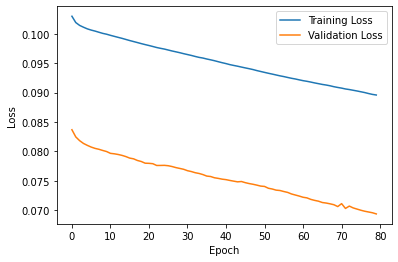

In [21]:
### START CODE HERE ###
# Construct the model & Set the parameters.
input_size = 6  # Number of input features (1 for single sine wave value)
rnn_units = 128  # Number of units in the RNN layer
dense_units = 128  # Number of units in the Dense layer
output_size = 3  # Number of output classes

model = Model()
model.add(RNN(input_size, rnn_units))
model.add(Dense(rnn_units, dense_units))
model.add(Activation("relu", None))
model.add(Dense(dense_units, 64))
model.add(Activation("relu", None))
model.add(Dense(64, 8))
model.add(Activation("relu", None))
model.add(Dense(8, output_size))
model.add(Activation("softmax", None))

# Train the model
model.train(X_train, y_train, X_val, y_val, epochs=20, learning_rate=0.01, batch_size=16, loss_function='cce')
model.train(X_train, y_train, X_val, y_val, epochs=40, learning_rate=0.008, batch_size=32, loss_function='cce')
model.train(X_train, y_train, X_val, y_val, epochs=40, learning_rate=0.004, batch_size=48, loss_function='cce')
model.train(X_train, y_train, X_val, y_val, epochs=40, learning_rate=0.002, batch_size=64, loss_function='cce')
model.train(X_train, y_train, X_val, y_val, epochs=80, learning_rate=0.0008, batch_size=80, loss_function='cce')
### END CODE HERE ###
# Plot the training and validation losses
model.plot_losses()

In [24]:
### START CODE HERE ###
model.train(X_train, y_train, X_val, y_val, epochs=80, learning_rate=0.0008, batch_size=108, loss_function='cce')
model.train(X_train, y_train, X_val, y_val, epochs=160, learning_rate=0.0004, batch_size=132, loss_function='cce')
model.train(X_train, y_train, X_val, y_val, epochs=160, learning_rate=0.0002, batch_size=160, loss_function='cce')
### END CODE HERE ###

Epoch 1/80: 100%|██████████| 61/61 [00:09<00:00,  6.61batch/s, loss=0.088] 


Epoch 1/80, Training Loss: 0.08735020099527477
Epoch 1/80, Validation Loss: 0.06669483856613112


Epoch 2/80: 100%|██████████| 61/61 [00:07<00:00,  8.08batch/s, loss=0.0877]


Epoch 2/80, Training Loss: 0.0870358886551839
Epoch 2/80, Validation Loss: 0.06657251039892297


Epoch 3/80: 100%|██████████| 61/61 [00:06<00:00,  8.83batch/s, loss=0.0875]


Epoch 3/80, Training Loss: 0.08691037080831426
Epoch 3/80, Validation Loss: 0.06643111943755757


Epoch 4/80: 100%|██████████| 61/61 [00:07<00:00,  8.70batch/s, loss=0.0874]


Epoch 4/80, Training Loss: 0.08679979112512037
Epoch 4/80, Validation Loss: 0.0662356633745002


Epoch 5/80: 100%|██████████| 61/61 [00:07<00:00,  8.53batch/s, loss=0.0873]


Epoch 5/80, Training Loss: 0.0867039087853241
Epoch 5/80, Validation Loss: 0.06610556137890523


Epoch 6/80: 100%|██████████| 61/61 [00:07<00:00,  7.71batch/s, loss=0.0872]


Epoch 6/80, Training Loss: 0.08660376317781224
Epoch 6/80, Validation Loss: 0.06608396920203555


Epoch 7/80: 100%|██████████| 61/61 [00:06<00:00,  8.93batch/s, loss=0.0871]


Epoch 7/80, Training Loss: 0.0864792029366204
Epoch 7/80, Validation Loss: 0.06594055048686727


Epoch 8/80: 100%|██████████| 61/61 [00:06<00:00,  9.36batch/s, loss=0.087] 


Epoch 8/80, Training Loss: 0.0863825134231246
Epoch 8/80, Validation Loss: 0.06583760325481346


Epoch 9/80: 100%|██████████| 61/61 [00:06<00:00,  8.82batch/s, loss=0.0869]


Epoch 9/80, Training Loss: 0.08626382926131942
Epoch 9/80, Validation Loss: 0.0657081007960873


Epoch 10/80: 100%|██████████| 61/61 [00:07<00:00,  8.31batch/s, loss=0.0868]


Epoch 10/80, Training Loss: 0.08617463437917267
Epoch 10/80, Validation Loss: 0.06562428619196972


Epoch 11/80: 100%|██████████| 61/61 [00:06<00:00,  8.97batch/s, loss=0.0867]


Epoch 11/80, Training Loss: 0.08606744995167678
Epoch 11/80, Validation Loss: 0.0653874285168473


Epoch 12/80: 100%|██████████| 61/61 [00:06<00:00,  8.79batch/s, loss=0.0866]


Epoch 12/80, Training Loss: 0.08597158446219774
Epoch 12/80, Validation Loss: 0.06529124510375926


Epoch 13/80: 100%|██████████| 61/61 [00:07<00:00,  7.96batch/s, loss=0.0865]


Epoch 13/80, Training Loss: 0.08586357603625998
Epoch 13/80, Validation Loss: 0.06516463458165377


Epoch 14/80: 100%|██████████| 61/61 [00:11<00:00,  5.45batch/s, loss=0.0864]


Epoch 14/80, Training Loss: 0.08573736638566669
Epoch 14/80, Validation Loss: 0.06506350913891629


Epoch 15/80: 100%|██████████| 61/61 [00:07<00:00,  7.84batch/s, loss=0.0863]


Epoch 15/80, Training Loss: 0.08564019602777248
Epoch 15/80, Validation Loss: 0.06495799168609863


Epoch 16/80: 100%|██████████| 61/61 [00:08<00:00,  7.03batch/s, loss=0.0862]


Epoch 16/80, Training Loss: 0.08552954822337028
Epoch 16/80, Validation Loss: 0.06490721776537925


Epoch 17/80: 100%|██████████| 61/61 [00:07<00:00,  8.32batch/s, loss=0.0861]


Epoch 17/80, Training Loss: 0.08541562259646915
Epoch 17/80, Validation Loss: 0.06479360708253822


Epoch 18/80: 100%|██████████| 61/61 [00:07<00:00,  8.66batch/s, loss=0.086] 


Epoch 18/80, Training Loss: 0.08533751229659109
Epoch 18/80, Validation Loss: 0.06473703643636285


Epoch 19/80: 100%|██████████| 61/61 [00:07<00:00,  8.03batch/s, loss=0.0859]


Epoch 19/80, Training Loss: 0.08525005631532782
Epoch 19/80, Validation Loss: 0.06462008852159724


Epoch 20/80: 100%|██████████| 61/61 [00:07<00:00,  7.92batch/s, loss=0.0858]


Epoch 20/80, Training Loss: 0.08513559667001917
Epoch 20/80, Validation Loss: 0.0644240435453313


Epoch 21/80: 100%|██████████| 61/61 [00:08<00:00,  7.16batch/s, loss=0.0857]


Epoch 21/80, Training Loss: 0.08505881510872848
Epoch 21/80, Validation Loss: 0.06443639361814334


Epoch 22/80: 100%|██████████| 61/61 [00:06<00:00,  8.92batch/s, loss=0.0856]


Epoch 22/80, Training Loss: 0.0849233514796751
Epoch 22/80, Validation Loss: 0.06422002665713164


Epoch 23/80: 100%|██████████| 61/61 [00:08<00:00,  6.95batch/s, loss=0.0855]


Epoch 23/80, Training Loss: 0.08482316060268494
Epoch 23/80, Validation Loss: 0.06410803138109787


Epoch 24/80: 100%|██████████| 61/61 [00:09<00:00,  6.58batch/s, loss=0.0854]


Epoch 24/80, Training Loss: 0.08471531076308626
Epoch 24/80, Validation Loss: 0.06397607072480684


Epoch 25/80: 100%|██████████| 61/61 [00:09<00:00,  6.49batch/s, loss=0.0853]


Epoch 25/80, Training Loss: 0.0846144307317623
Epoch 25/80, Validation Loss: 0.06388769878757239


Epoch 26/80: 100%|██████████| 61/61 [00:07<00:00,  8.00batch/s, loss=0.0852]


Epoch 26/80, Training Loss: 0.0845178669752383
Epoch 26/80, Validation Loss: 0.0637003426083884


Epoch 27/80: 100%|██████████| 61/61 [00:08<00:00,  7.02batch/s, loss=0.0851]


Epoch 27/80, Training Loss: 0.08441790042898924
Epoch 27/80, Validation Loss: 0.06369272554254653


Epoch 28/80: 100%|██████████| 61/61 [00:09<00:00,  6.51batch/s, loss=0.085] 


Epoch 28/80, Training Loss: 0.08432797550920344
Epoch 28/80, Validation Loss: 0.063601964257558


Epoch 29/80: 100%|██████████| 61/61 [00:06<00:00,  9.00batch/s, loss=0.0849]


Epoch 29/80, Training Loss: 0.08423638431564681
Epoch 29/80, Validation Loss: 0.06344442855107103


Epoch 30/80: 100%|██████████| 61/61 [00:08<00:00,  7.20batch/s, loss=0.0848]


Epoch 30/80, Training Loss: 0.0841393399575089
Epoch 30/80, Validation Loss: 0.06332441219786067


Epoch 31/80: 100%|██████████| 61/61 [00:07<00:00,  8.36batch/s, loss=0.0847]


Epoch 31/80, Training Loss: 0.08404165300131505
Epoch 31/80, Validation Loss: 0.06318326415318315


Epoch 32/80: 100%|██████████| 61/61 [00:08<00:00,  6.99batch/s, loss=0.0846]


Epoch 32/80, Training Loss: 0.0839528551210944
Epoch 32/80, Validation Loss: 0.06301669708928213


Epoch 33/80: 100%|██████████| 61/61 [00:07<00:00,  7.77batch/s, loss=0.0845]


Epoch 33/80, Training Loss: 0.08385840767414339
Epoch 33/80, Validation Loss: 0.06291182336331608


Epoch 34/80: 100%|██████████| 61/61 [00:07<00:00,  8.56batch/s, loss=0.0844]


Epoch 34/80, Training Loss: 0.08375454467231604
Epoch 34/80, Validation Loss: 0.06280336623991006


Epoch 35/80: 100%|██████████| 61/61 [00:08<00:00,  7.34batch/s, loss=0.0843]


Epoch 35/80, Training Loss: 0.08367162341669815
Epoch 35/80, Validation Loss: 0.0626610693415183


Epoch 36/80: 100%|██████████| 61/61 [00:07<00:00,  7.83batch/s, loss=0.0842]


Epoch 36/80, Training Loss: 0.08358342738967081
Epoch 36/80, Validation Loss: 0.06256565803365072


Epoch 37/80: 100%|██████████| 61/61 [00:06<00:00,  8.86batch/s, loss=0.0841]


Epoch 37/80, Training Loss: 0.08347872365958002
Epoch 37/80, Validation Loss: 0.06246881269545206


Epoch 38/80: 100%|██████████| 61/61 [00:07<00:00,  8.37batch/s, loss=0.0841]


Epoch 38/80, Training Loss: 0.08340062083099829
Epoch 38/80, Validation Loss: 0.062394700090673584


Epoch 39/80: 100%|██████████| 61/61 [00:11<00:00,  5.38batch/s, loss=0.084] 


Epoch 39/80, Training Loss: 0.08331937378610053
Epoch 39/80, Validation Loss: 0.06219978720861271


Epoch 40/80: 100%|██████████| 61/61 [00:08<00:00,  7.00batch/s, loss=0.0839]


Epoch 40/80, Training Loss: 0.08322651964328198
Epoch 40/80, Validation Loss: 0.062120262431590065


Epoch 41/80: 100%|██████████| 61/61 [00:07<00:00,  8.47batch/s, loss=0.0838]


Epoch 41/80, Training Loss: 0.08316624864481967
Epoch 41/80, Validation Loss: 0.062025495874586396


Epoch 42/80: 100%|██████████| 61/61 [00:08<00:00,  7.32batch/s, loss=0.0837]


Epoch 42/80, Training Loss: 0.08306319016812741
Epoch 42/80, Validation Loss: 0.06194938317346944


Epoch 43/80: 100%|██████████| 61/61 [00:08<00:00,  7.54batch/s, loss=0.0836]


Epoch 43/80, Training Loss: 0.08298395192929799
Epoch 43/80, Validation Loss: 0.06181460123293507


Epoch 44/80: 100%|██████████| 61/61 [00:09<00:00,  6.64batch/s, loss=0.0836]


Epoch 44/80, Training Loss: 0.0829066423382915
Epoch 44/80, Validation Loss: 0.061703530037457516


Epoch 45/80: 100%|██████████| 61/61 [00:10<00:00,  5.95batch/s, loss=0.0835]


Epoch 45/80, Training Loss: 0.08283443319838613
Epoch 45/80, Validation Loss: 0.06160944334851246


Epoch 46/80: 100%|██████████| 61/61 [00:07<00:00,  8.30batch/s, loss=0.0834]


Epoch 46/80, Training Loss: 0.08275588130587667
Epoch 46/80, Validation Loss: 0.06156405906585526


Epoch 47/80: 100%|██████████| 61/61 [00:06<00:00,  8.97batch/s, loss=0.0833]


Epoch 47/80, Training Loss: 0.08268251190984156
Epoch 47/80, Validation Loss: 0.06140651439242202


Epoch 48/80: 100%|██████████| 61/61 [00:06<00:00,  8.88batch/s, loss=0.0833]


Epoch 48/80, Training Loss: 0.08260217608177488
Epoch 48/80, Validation Loss: 0.06130962047278427


Epoch 49/80: 100%|██████████| 61/61 [00:08<00:00,  6.84batch/s, loss=0.0832]


Epoch 49/80, Training Loss: 0.08251300263522883
Epoch 49/80, Validation Loss: 0.061219680967758004


Epoch 50/80: 100%|██████████| 61/61 [00:08<00:00,  6.93batch/s, loss=0.0831]


Epoch 50/80, Training Loss: 0.08243541656141996
Epoch 50/80, Validation Loss: 0.061088051276977196


Epoch 51/80: 100%|██████████| 61/61 [00:09<00:00,  6.43batch/s, loss=0.083] 


Epoch 51/80, Training Loss: 0.08236541924234003
Epoch 51/80, Validation Loss: 0.06099399295756694


Epoch 52/80: 100%|██████████| 61/61 [00:07<00:00,  7.63batch/s, loss=0.0829]


Epoch 52/80, Training Loss: 0.08227535465840204
Epoch 52/80, Validation Loss: 0.06087607818608684


Epoch 53/80: 100%|██████████| 61/61 [00:09<00:00,  6.38batch/s, loss=0.0829]


Epoch 53/80, Training Loss: 0.08220137262901818
Epoch 53/80, Validation Loss: 0.060763079864407016


Epoch 54/80: 100%|██████████| 61/61 [00:08<00:00,  7.18batch/s, loss=0.0828]


Epoch 54/80, Training Loss: 0.0821177261722073
Epoch 54/80, Validation Loss: 0.060653339267509015


Epoch 55/80: 100%|██████████| 61/61 [00:09<00:00,  6.24batch/s, loss=0.0827]


Epoch 55/80, Training Loss: 0.08203368408022436
Epoch 55/80, Validation Loss: 0.06055459369982631


Epoch 56/80: 100%|██████████| 61/61 [00:07<00:00,  8.41batch/s, loss=0.0826]


Epoch 56/80, Training Loss: 0.0819433578767748
Epoch 56/80, Validation Loss: 0.060493450432035745


Epoch 57/80: 100%|██████████| 61/61 [00:09<00:00,  6.47batch/s, loss=0.0825]


Epoch 57/80, Training Loss: 0.08187153091167891
Epoch 57/80, Validation Loss: 0.0604102777657596


Epoch 58/80: 100%|██████████| 61/61 [00:07<00:00,  7.82batch/s, loss=0.0825]


Epoch 58/80, Training Loss: 0.08179038826117715
Epoch 58/80, Validation Loss: 0.06029336848872493


Epoch 59/80: 100%|██████████| 61/61 [00:07<00:00,  7.94batch/s, loss=0.0824]


Epoch 59/80, Training Loss: 0.08169629762515324
Epoch 59/80, Validation Loss: 0.06019172229923536


Epoch 60/80: 100%|██████████| 61/61 [00:08<00:00,  7.27batch/s, loss=0.0823]


Epoch 60/80, Training Loss: 0.08161288760795589
Epoch 60/80, Validation Loss: 0.060104733863171673


Epoch 61/80: 100%|██████████| 61/61 [00:11<00:00,  5.33batch/s, loss=0.0822]


Epoch 61/80, Training Loss: 0.0815429681015888
Epoch 61/80, Validation Loss: 0.05997367144127004


Epoch 62/80: 100%|██████████| 61/61 [00:07<00:00,  7.67batch/s, loss=0.0821]


Epoch 62/80, Training Loss: 0.08147177426511724
Epoch 62/80, Validation Loss: 0.059891263998048616


Epoch 63/80: 100%|██████████| 61/61 [00:08<00:00,  7.35batch/s, loss=0.0821]


Epoch 63/80, Training Loss: 0.08139235803290544
Epoch 63/80, Validation Loss: 0.05982960964287074


Epoch 64/80: 100%|██████████| 61/61 [00:07<00:00,  7.94batch/s, loss=0.082] 


Epoch 64/80, Training Loss: 0.08131095334135838
Epoch 64/80, Validation Loss: 0.05978521458092215


Epoch 65/80: 100%|██████████| 61/61 [00:07<00:00,  7.76batch/s, loss=0.0819]


Epoch 65/80, Training Loss: 0.0812373246318261
Epoch 65/80, Validation Loss: 0.05978983216097578


Epoch 66/80: 100%|██████████| 61/61 [00:10<00:00,  5.98batch/s, loss=0.0818]


Epoch 66/80, Training Loss: 0.08117469089792011
Epoch 66/80, Validation Loss: 0.059703341721561436


Epoch 67/80: 100%|██████████| 61/61 [00:10<00:00,  5.85batch/s, loss=0.0817]


Epoch 67/80, Training Loss: 0.0810821857785996
Epoch 67/80, Validation Loss: 0.05961005855806083


Epoch 68/80: 100%|██████████| 61/61 [00:08<00:00,  7.49batch/s, loss=0.0817]


Epoch 68/80, Training Loss: 0.08103298133079342
Epoch 68/80, Validation Loss: 0.05951928241834086


Epoch 69/80: 100%|██████████| 61/61 [00:09<00:00,  6.22batch/s, loss=0.0816]


Epoch 69/80, Training Loss: 0.08095260240103916
Epoch 69/80, Validation Loss: 0.05947750411202875


Epoch 70/80: 100%|██████████| 61/61 [00:11<00:00,  5.20batch/s, loss=0.0815]


Epoch 70/80, Training Loss: 0.08086866453743752
Epoch 70/80, Validation Loss: 0.059377384894142134


Epoch 71/80: 100%|██████████| 61/61 [00:10<00:00,  6.06batch/s, loss=0.0814]


Epoch 71/80, Training Loss: 0.08073800166777644
Epoch 71/80, Validation Loss: 0.059151376583716476


Epoch 72/80: 100%|██████████| 61/61 [00:08<00:00,  7.02batch/s, loss=0.0814]


Epoch 72/80, Training Loss: 0.080702105210557
Epoch 72/80, Validation Loss: 0.05911146982682183


Epoch 73/80: 100%|██████████| 61/61 [00:07<00:00,  7.72batch/s, loss=0.0813]


Epoch 73/80, Training Loss: 0.08059478902457114
Epoch 73/80, Validation Loss: 0.059001670292390146


Epoch 74/80: 100%|██████████| 61/61 [00:07<00:00,  8.54batch/s, loss=0.0812]


Epoch 74/80, Training Loss: 0.0805217014120362
Epoch 74/80, Validation Loss: 0.05889452174328872


Epoch 75/80: 100%|██████████| 61/61 [00:09<00:00,  6.56batch/s, loss=0.0811]


Epoch 75/80, Training Loss: 0.08045593096520755
Epoch 75/80, Validation Loss: 0.05865969501220865


Epoch 76/80: 100%|██████████| 61/61 [00:07<00:00,  8.40batch/s, loss=0.0811]


Epoch 76/80, Training Loss: 0.08041233584833278
Epoch 76/80, Validation Loss: 0.05854177605555421


Epoch 77/80: 100%|██████████| 61/61 [00:08<00:00,  7.35batch/s, loss=0.081] 


Epoch 77/80, Training Loss: 0.08030828442333908
Epoch 77/80, Validation Loss: 0.05844844995893827


Epoch 78/80: 100%|██████████| 61/61 [00:10<00:00,  6.07batch/s, loss=0.0809]


Epoch 78/80, Training Loss: 0.08024398740979442
Epoch 78/80, Validation Loss: 0.05834112630836123


Epoch 79/80: 100%|██████████| 61/61 [00:07<00:00,  8.30batch/s, loss=0.0808]


Epoch 79/80, Training Loss: 0.08018341760327308
Epoch 79/80, Validation Loss: 0.058233898447903144


Epoch 80/80: 100%|██████████| 61/61 [00:07<00:00,  8.35batch/s, loss=0.0807]


Epoch 80/80, Training Loss: 0.08007533741733351
Epoch 80/80, Validation Loss: 0.05812734660891714


Epoch 1/160: 100%|██████████| 50/50 [00:07<00:00,  6.85batch/s, loss=0.0794]


Epoch 1/160, Training Loss: 0.0792961129918271
Epoch 1/160, Validation Loss: 0.058254357607442346


Epoch 2/160: 100%|██████████| 50/50 [00:07<00:00,  7.08batch/s, loss=0.0792]


Epoch 2/160, Training Loss: 0.07905692698566381
Epoch 2/160, Validation Loss: 0.05833760579252457


Epoch 3/160: 100%|██████████| 50/50 [00:07<00:00,  6.48batch/s, loss=0.0791]


Epoch 3/160, Training Loss: 0.07895054515521834
Epoch 3/160, Validation Loss: 0.05844177500717195


Epoch 4/160: 100%|██████████| 50/50 [00:10<00:00,  4.56batch/s, loss=0.079] 


Epoch 4/160, Training Loss: 0.07887049742934465
Epoch 4/160, Validation Loss: 0.05848226816656401


Epoch 5/160: 100%|██████████| 50/50 [00:06<00:00,  7.58batch/s, loss=0.0789]


Epoch 5/160, Training Loss: 0.07881685365367953
Epoch 5/160, Validation Loss: 0.05837554753697174


Epoch 6/160: 100%|██████████| 50/50 [00:07<00:00,  7.02batch/s, loss=0.0789]


Epoch 6/160, Training Loss: 0.07875457238606341
Epoch 6/160, Validation Loss: 0.05839883845636384


Epoch 7/160: 100%|██████████| 50/50 [00:06<00:00,  7.66batch/s, loss=0.0788]


Epoch 7/160, Training Loss: 0.07869430800707297
Epoch 7/160, Validation Loss: 0.05836482328016539


Epoch 8/160: 100%|██████████| 50/50 [00:09<00:00,  5.28batch/s, loss=0.0788]


Epoch 8/160, Training Loss: 0.07864083998992796
Epoch 8/160, Validation Loss: 0.058293581926597386


Epoch 9/160: 100%|██████████| 50/50 [00:06<00:00,  7.78batch/s, loss=0.0787]


Epoch 9/160, Training Loss: 0.07860706439009708
Epoch 9/160, Validation Loss: 0.058236799894528846


Epoch 10/160: 100%|██████████| 50/50 [00:06<00:00,  7.16batch/s, loss=0.0787]


Epoch 10/160, Training Loss: 0.07856395778399156
Epoch 10/160, Validation Loss: 0.05820398068447588


Epoch 11/160: 100%|██████████| 50/50 [00:06<00:00,  8.13batch/s, loss=0.0787]


Epoch 11/160, Training Loss: 0.07852945272612662
Epoch 11/160, Validation Loss: 0.05816404770276251


Epoch 12/160: 100%|██████████| 50/50 [00:07<00:00,  6.93batch/s, loss=0.0786]


Epoch 12/160, Training Loss: 0.07848905256261954
Epoch 12/160, Validation Loss: 0.05820091710479917


Epoch 13/160: 100%|██████████| 50/50 [00:06<00:00,  7.62batch/s, loss=0.0786]


Epoch 13/160, Training Loss: 0.07844358049445685
Epoch 13/160, Validation Loss: 0.05821694625515864


Epoch 14/160: 100%|██████████| 50/50 [00:06<00:00,  7.59batch/s, loss=0.0785]


Epoch 14/160, Training Loss: 0.07840545590070268
Epoch 14/160, Validation Loss: 0.058156196761960974


Epoch 15/160: 100%|██████████| 50/50 [00:06<00:00,  7.60batch/s, loss=0.0785]


Epoch 15/160, Training Loss: 0.0783727811085395
Epoch 15/160, Validation Loss: 0.05814220787313782


Epoch 16/160: 100%|██████████| 50/50 [00:06<00:00,  8.24batch/s, loss=0.0785]


Epoch 16/160, Training Loss: 0.07833962997080629
Epoch 16/160, Validation Loss: 0.058120817871889746


Epoch 17/160: 100%|██████████| 50/50 [00:05<00:00,  8.98batch/s, loss=0.0784]


Epoch 17/160, Training Loss: 0.07830824961262595
Epoch 17/160, Validation Loss: 0.05809525254119941


Epoch 18/160: 100%|██████████| 50/50 [00:06<00:00,  7.57batch/s, loss=0.0784]


Epoch 18/160, Training Loss: 0.07828380805353452
Epoch 18/160, Validation Loss: 0.058024076970588936


Epoch 19/160: 100%|██████████| 50/50 [00:07<00:00,  7.12batch/s, loss=0.0784]


Epoch 19/160, Training Loss: 0.07823992604694584
Epoch 19/160, Validation Loss: 0.05800991669997046


Epoch 20/160: 100%|██████████| 50/50 [00:06<00:00,  8.30batch/s, loss=0.0783]


Epoch 20/160, Training Loss: 0.07821612935042767
Epoch 20/160, Validation Loss: 0.05794105908395732


Epoch 21/160: 100%|██████████| 50/50 [00:06<00:00,  7.94batch/s, loss=0.0783]


Epoch 21/160, Training Loss: 0.0781716098598848
Epoch 21/160, Validation Loss: 0.05790897245774896


Epoch 22/160: 100%|██████████| 50/50 [00:06<00:00,  7.38batch/s, loss=0.0783]


Epoch 22/160, Training Loss: 0.07814023226951254
Epoch 22/160, Validation Loss: 0.057890153924894994


Epoch 23/160: 100%|██████████| 50/50 [00:06<00:00,  7.98batch/s, loss=0.0782]


Epoch 23/160, Training Loss: 0.07812014301039304
Epoch 23/160, Validation Loss: 0.05783953879989202


Epoch 24/160: 100%|██████████| 50/50 [00:07<00:00,  6.32batch/s, loss=0.0782]


Epoch 24/160, Training Loss: 0.07808061143734867
Epoch 24/160, Validation Loss: 0.057819192042462275


Epoch 25/160: 100%|██████████| 50/50 [00:07<00:00,  6.39batch/s, loss=0.0782]


Epoch 25/160, Training Loss: 0.07805771244637505
Epoch 25/160, Validation Loss: 0.057767194315003365


Epoch 26/160: 100%|██████████| 50/50 [00:06<00:00,  8.12batch/s, loss=0.0781]


Epoch 26/160, Training Loss: 0.07801450430006163
Epoch 26/160, Validation Loss: 0.05773135686670233


Epoch 27/160: 100%|██████████| 50/50 [00:05<00:00,  8.43batch/s, loss=0.0781]


Epoch 27/160, Training Loss: 0.07798921157840688
Epoch 27/160, Validation Loss: 0.05769473308288767


Epoch 28/160: 100%|██████████| 50/50 [00:07<00:00,  7.12batch/s, loss=0.0781]


Epoch 28/160, Training Loss: 0.07795857234855
Epoch 28/160, Validation Loss: 0.05764472371588216


Epoch 29/160: 100%|██████████| 50/50 [00:06<00:00,  8.15batch/s, loss=0.0781]


Epoch 29/160, Training Loss: 0.0779263046653941
Epoch 29/160, Validation Loss: 0.05760600027834085


Epoch 30/160: 100%|██████████| 50/50 [00:06<00:00,  7.18batch/s, loss=0.078] 


Epoch 30/160, Training Loss: 0.07789506614361623
Epoch 30/160, Validation Loss: 0.05757172392977762


Epoch 31/160: 100%|██████████| 50/50 [00:06<00:00,  7.22batch/s, loss=0.078] 


Epoch 31/160, Training Loss: 0.07786396076635217
Epoch 31/160, Validation Loss: 0.05753272032766356


Epoch 32/160: 100%|██████████| 50/50 [00:09<00:00,  5.23batch/s, loss=0.078] 


Epoch 32/160, Training Loss: 0.07783119553189882
Epoch 32/160, Validation Loss: 0.05748937919212282


Epoch 33/160: 100%|██████████| 50/50 [00:08<00:00,  5.82batch/s, loss=0.0779]


Epoch 33/160, Training Loss: 0.07779768850862331
Epoch 33/160, Validation Loss: 0.05747266660849


Epoch 34/160: 100%|██████████| 50/50 [00:09<00:00,  5.02batch/s, loss=0.0779]


Epoch 34/160, Training Loss: 0.07776884783058956
Epoch 34/160, Validation Loss: 0.05743716072753896


Epoch 35/160: 100%|██████████| 50/50 [00:07<00:00,  6.29batch/s, loss=0.0779]


Epoch 35/160, Training Loss: 0.07773934891406248
Epoch 35/160, Validation Loss: 0.05740708866545753


Epoch 36/160: 100%|██████████| 50/50 [00:06<00:00,  7.43batch/s, loss=0.0778]


Epoch 36/160, Training Loss: 0.07770815581360452
Epoch 36/160, Validation Loss: 0.05736952718267006


Epoch 37/160: 100%|██████████| 50/50 [00:08<00:00,  6.19batch/s, loss=0.0778]


Epoch 37/160, Training Loss: 0.07767440020683185
Epoch 37/160, Validation Loss: 0.057327760178146135


Epoch 38/160: 100%|██████████| 50/50 [00:08<00:00,  6.14batch/s, loss=0.0778]


Epoch 38/160, Training Loss: 0.07764148409804719
Epoch 38/160, Validation Loss: 0.05729629687061129


Epoch 39/160: 100%|██████████| 50/50 [00:07<00:00,  6.74batch/s, loss=0.0777]


Epoch 39/160, Training Loss: 0.07761212351393937
Epoch 39/160, Validation Loss: 0.05726664097390846


Epoch 40/160: 100%|██████████| 50/50 [00:07<00:00,  6.92batch/s, loss=0.0777]


Epoch 40/160, Training Loss: 0.07758546319074407
Epoch 40/160, Validation Loss: 0.05724245493459766


Epoch 41/160: 100%|██████████| 50/50 [00:07<00:00,  6.66batch/s, loss=0.0777]


Epoch 41/160, Training Loss: 0.07753830303290882
Epoch 41/160, Validation Loss: 0.057208173896252525


Epoch 42/160: 100%|██████████| 50/50 [00:06<00:00,  8.30batch/s, loss=0.0776]


Epoch 42/160, Training Loss: 0.07750889950072176
Epoch 42/160, Validation Loss: 0.057165049015961464


Epoch 43/160: 100%|██████████| 50/50 [00:05<00:00,  9.26batch/s, loss=0.0776]


Epoch 43/160, Training Loss: 0.07747963775080068
Epoch 43/160, Validation Loss: 0.05713621010625733


Epoch 44/160: 100%|██████████| 50/50 [00:07<00:00,  6.45batch/s, loss=0.0776]


Epoch 44/160, Training Loss: 0.07744640129589604
Epoch 44/160, Validation Loss: 0.05709542970931873


Epoch 45/160: 100%|██████████| 50/50 [00:07<00:00,  6.36batch/s, loss=0.0776]


Epoch 45/160, Training Loss: 0.07742623787528403
Epoch 45/160, Validation Loss: 0.05707299866877371


Epoch 46/160: 100%|██████████| 50/50 [00:05<00:00,  9.21batch/s, loss=0.0775]


Epoch 46/160, Training Loss: 0.07738046734045598
Epoch 46/160, Validation Loss: 0.05702447745740657


Epoch 47/160: 100%|██████████| 50/50 [00:06<00:00,  8.12batch/s, loss=0.0775]


Epoch 47/160, Training Loss: 0.07736511853021116
Epoch 47/160, Validation Loss: 0.05700142107322987


Epoch 48/160: 100%|██████████| 50/50 [00:06<00:00,  7.78batch/s, loss=0.0775]


Epoch 48/160, Training Loss: 0.07733244869288639
Epoch 48/160, Validation Loss: 0.056952867551831654


Epoch 49/160: 100%|██████████| 50/50 [00:05<00:00,  8.68batch/s, loss=0.0774]


Epoch 49/160, Training Loss: 0.07728428690170665
Epoch 49/160, Validation Loss: 0.056921388468657706


Epoch 50/160: 100%|██████████| 50/50 [00:08<00:00,  6.22batch/s, loss=0.0774]


Epoch 50/160, Training Loss: 0.07726949507150736
Epoch 50/160, Validation Loss: 0.05690368579701024


Epoch 51/160: 100%|██████████| 50/50 [00:07<00:00,  6.75batch/s, loss=0.0773]


Epoch 51/160, Training Loss: 0.07722063625518473
Epoch 51/160, Validation Loss: 0.056862561605466454


Epoch 52/160: 100%|██████████| 50/50 [00:08<00:00,  5.69batch/s, loss=0.0773]


Epoch 52/160, Training Loss: 0.07720247448279303
Epoch 52/160, Validation Loss: 0.056831750032773964


Epoch 53/160: 100%|██████████| 50/50 [00:06<00:00,  7.53batch/s, loss=0.0773]


Epoch 53/160, Training Loss: 0.07717005163550997
Epoch 53/160, Validation Loss: 0.05681454936776384


Epoch 54/160: 100%|██████████| 50/50 [00:10<00:00,  4.96batch/s, loss=0.0773]


Epoch 54/160, Training Loss: 0.0771406524332532
Epoch 54/160, Validation Loss: 0.05678684965693477


Epoch 55/160: 100%|██████████| 50/50 [00:07<00:00,  6.61batch/s, loss=0.0772]


Epoch 55/160, Training Loss: 0.07710731526025115
Epoch 55/160, Validation Loss: 0.05673911580806838


Epoch 56/160: 100%|██████████| 50/50 [00:07<00:00,  6.37batch/s, loss=0.0772]


Epoch 56/160, Training Loss: 0.07707660452126297
Epoch 56/160, Validation Loss: 0.05670266291436767


Epoch 57/160: 100%|██████████| 50/50 [00:08<00:00,  6.07batch/s, loss=0.0772]


Epoch 57/160, Training Loss: 0.07704894788122955
Epoch 57/160, Validation Loss: 0.056661830440777286


Epoch 58/160: 100%|██████████| 50/50 [00:07<00:00,  6.38batch/s, loss=0.0771]


Epoch 58/160, Training Loss: 0.07702096825665182
Epoch 58/160, Validation Loss: 0.05663264813094009


Epoch 59/160: 100%|██████████| 50/50 [00:09<00:00,  5.49batch/s, loss=0.0771]


Epoch 59/160, Training Loss: 0.07698980326301924
Epoch 59/160, Validation Loss: 0.05659738596208501


Epoch 60/160: 100%|██████████| 50/50 [00:06<00:00,  7.84batch/s, loss=0.0771]


Epoch 60/160, Training Loss: 0.07696174995888398
Epoch 60/160, Validation Loss: 0.05657067909718565


Epoch 61/160: 100%|██████████| 50/50 [00:06<00:00,  8.10batch/s, loss=0.0771]


Epoch 61/160, Training Loss: 0.07692908358655105
Epoch 61/160, Validation Loss: 0.05653654401228486


Epoch 62/160: 100%|██████████| 50/50 [00:05<00:00,  9.14batch/s, loss=0.077] 


Epoch 62/160, Training Loss: 0.07690078103621957
Epoch 62/160, Validation Loss: 0.05650522582774791


Epoch 63/160: 100%|██████████| 50/50 [00:06<00:00,  8.07batch/s, loss=0.077] 


Epoch 63/160, Training Loss: 0.07687452102856367
Epoch 63/160, Validation Loss: 0.056480090599872634


Epoch 64/160: 100%|██████████| 50/50 [00:08<00:00,  5.95batch/s, loss=0.077] 


Epoch 64/160, Training Loss: 0.07684020360225371
Epoch 64/160, Validation Loss: 0.05642146789394455


Epoch 65/160: 100%|██████████| 50/50 [00:05<00:00,  8.79batch/s, loss=0.0769]


Epoch 65/160, Training Loss: 0.07680682126623821
Epoch 65/160, Validation Loss: 0.056383971515853705


Epoch 66/160: 100%|██████████| 50/50 [00:06<00:00,  7.96batch/s, loss=0.0769]


Epoch 66/160, Training Loss: 0.07677674519697336
Epoch 66/160, Validation Loss: 0.056359036103587126


Epoch 67/160: 100%|██████████| 50/50 [00:07<00:00,  7.08batch/s, loss=0.0769]


Epoch 67/160, Training Loss: 0.07674571880128904
Epoch 67/160, Validation Loss: 0.05633272614405831


Epoch 68/160: 100%|██████████| 50/50 [00:06<00:00,  8.19batch/s, loss=0.0768]


Epoch 68/160, Training Loss: 0.07671552848991292
Epoch 68/160, Validation Loss: 0.056307186566758156


Epoch 69/160: 100%|██████████| 50/50 [00:06<00:00,  7.80batch/s, loss=0.0768]


Epoch 69/160, Training Loss: 0.0767005100386483
Epoch 69/160, Validation Loss: 0.05629210040533001


Epoch 70/160: 100%|██████████| 50/50 [00:06<00:00,  7.49batch/s, loss=0.0768]


Epoch 70/160, Training Loss: 0.07665987001898832
Epoch 70/160, Validation Loss: 0.05627204348908312


Epoch 71/160: 100%|██████████| 50/50 [00:05<00:00,  9.07batch/s, loss=0.0768]


Epoch 71/160, Training Loss: 0.07662612245972471
Epoch 71/160, Validation Loss: 0.05624382676320496


Epoch 72/160: 100%|██████████| 50/50 [00:06<00:00,  8.14batch/s, loss=0.0767]


Epoch 72/160, Training Loss: 0.07659807495157
Epoch 72/160, Validation Loss: 0.056223754027524865


Epoch 73/160: 100%|██████████| 50/50 [00:05<00:00,  8.52batch/s, loss=0.0767]


Epoch 73/160, Training Loss: 0.0765657042661272
Epoch 73/160, Validation Loss: 0.05620423592131054


Epoch 74/160: 100%|██████████| 50/50 [00:07<00:00,  7.07batch/s, loss=0.0767]


Epoch 74/160, Training Loss: 0.07653625070510953
Epoch 74/160, Validation Loss: 0.056182642594756665


Epoch 75/160: 100%|██████████| 50/50 [00:06<00:00,  8.04batch/s, loss=0.0766]


Epoch 75/160, Training Loss: 0.0765084800820465
Epoch 75/160, Validation Loss: 0.05615692476184777


Epoch 76/160: 100%|██████████| 50/50 [00:05<00:00,  8.93batch/s, loss=0.0766]


Epoch 76/160, Training Loss: 0.07647523896486166
Epoch 76/160, Validation Loss: 0.056127304828723946


Epoch 77/160: 100%|██████████| 50/50 [00:06<00:00,  7.87batch/s, loss=0.0766]


Epoch 77/160, Training Loss: 0.07644740217118742
Epoch 77/160, Validation Loss: 0.05611392346846545


Epoch 78/160: 100%|██████████| 50/50 [00:08<00:00,  6.15batch/s, loss=0.0765]


Epoch 78/160, Training Loss: 0.07641781779504886
Epoch 78/160, Validation Loss: 0.05607478525545228


Epoch 79/160: 100%|██████████| 50/50 [00:06<00:00,  7.18batch/s, loss=0.0765]


Epoch 79/160, Training Loss: 0.07638429963075673
Epoch 79/160, Validation Loss: 0.056046551717097375


Epoch 80/160: 100%|██████████| 50/50 [00:05<00:00,  8.83batch/s, loss=0.0765]


Epoch 80/160, Training Loss: 0.07635521498742658
Epoch 80/160, Validation Loss: 0.056015071260690684


Epoch 81/160: 100%|██████████| 50/50 [00:06<00:00,  8.07batch/s, loss=0.0765]


Epoch 81/160, Training Loss: 0.07632831681314278
Epoch 81/160, Validation Loss: 0.0559864959500579


Epoch 82/160: 100%|██████████| 50/50 [00:05<00:00,  8.60batch/s, loss=0.0764]


Epoch 82/160, Training Loss: 0.07630034966751001
Epoch 82/160, Validation Loss: 0.055950095458341204


Epoch 83/160: 100%|██████████| 50/50 [00:08<00:00,  5.56batch/s, loss=0.0764]


Epoch 83/160, Training Loss: 0.07626235747410398
Epoch 83/160, Validation Loss: 0.05590665496844673


Epoch 84/160: 100%|██████████| 50/50 [00:06<00:00,  7.21batch/s, loss=0.0764]


Epoch 84/160, Training Loss: 0.07624522427350967
Epoch 84/160, Validation Loss: 0.05587267230430321


Epoch 85/160: 100%|██████████| 50/50 [00:06<00:00,  8.12batch/s, loss=0.0763]


Epoch 85/160, Training Loss: 0.07621153653924535
Epoch 85/160, Validation Loss: 0.05578350373013192


Epoch 86/160: 100%|██████████| 50/50 [00:07<00:00,  6.92batch/s, loss=0.0763]


Epoch 86/160, Training Loss: 0.07618462608042315
Epoch 86/160, Validation Loss: 0.05575463496945362


Epoch 87/160: 100%|██████████| 50/50 [00:10<00:00,  4.76batch/s, loss=0.0763]


Epoch 87/160, Training Loss: 0.07615671407478865
Epoch 87/160, Validation Loss: 0.05573512749012968


Epoch 88/160: 100%|██████████| 50/50 [00:07<00:00,  6.96batch/s, loss=0.0763]


Epoch 88/160, Training Loss: 0.07612558138244314
Epoch 88/160, Validation Loss: 0.05571701738656492


Epoch 89/160: 100%|██████████| 50/50 [00:05<00:00,  8.36batch/s, loss=0.0762]


Epoch 89/160, Training Loss: 0.07610098735144756
Epoch 89/160, Validation Loss: 0.055692370623886614


Epoch 90/160: 100%|██████████| 50/50 [00:05<00:00,  8.47batch/s, loss=0.0762]


Epoch 90/160, Training Loss: 0.0760715949826867
Epoch 90/160, Validation Loss: 0.05568035565599376


Epoch 91/160: 100%|██████████| 50/50 [00:06<00:00,  7.95batch/s, loss=0.0762]


Epoch 91/160, Training Loss: 0.07604239704864357
Epoch 91/160, Validation Loss: 0.055643934254765444


Epoch 92/160: 100%|██████████| 50/50 [00:06<00:00,  7.75batch/s, loss=0.0761]


Epoch 92/160, Training Loss: 0.07601485117361632
Epoch 92/160, Validation Loss: 0.0556141862032445


Epoch 93/160: 100%|██████████| 50/50 [00:05<00:00,  9.12batch/s, loss=0.0761]


Epoch 93/160, Training Loss: 0.07598559151137202
Epoch 93/160, Validation Loss: 0.05558767616580622


Epoch 94/160: 100%|██████████| 50/50 [00:06<00:00,  7.16batch/s, loss=0.0761]


Epoch 94/160, Training Loss: 0.07597181308215513
Epoch 94/160, Validation Loss: 0.055567719234927246


Epoch 95/160: 100%|██████████| 50/50 [00:05<00:00,  8.98batch/s, loss=0.0761]


Epoch 95/160, Training Loss: 0.07594318809999084
Epoch 95/160, Validation Loss: 0.05554591294246558


Epoch 96/160: 100%|██████████| 50/50 [00:06<00:00,  7.77batch/s, loss=0.076] 


Epoch 96/160, Training Loss: 0.075914458902455
Epoch 96/160, Validation Loss: 0.055504092732253534


Epoch 97/160: 100%|██████████| 50/50 [00:06<00:00,  7.85batch/s, loss=0.076] 


Epoch 97/160, Training Loss: 0.07588020198222116
Epoch 97/160, Validation Loss: 0.055458816209825484


Epoch 98/160: 100%|██████████| 50/50 [00:05<00:00,  8.94batch/s, loss=0.076] 


Epoch 98/160, Training Loss: 0.0758578152078627
Epoch 98/160, Validation Loss: 0.05543990211178469


Epoch 99/160: 100%|██████████| 50/50 [00:06<00:00,  8.12batch/s, loss=0.076] 


Epoch 99/160, Training Loss: 0.07582418128067976
Epoch 99/160, Validation Loss: 0.05539972693165294


Epoch 100/160: 100%|██████████| 50/50 [00:05<00:00,  8.63batch/s, loss=0.0759]


Epoch 100/160, Training Loss: 0.07580379603068112
Epoch 100/160, Validation Loss: 0.055369737655472435


Epoch 101/160: 100%|██████████| 50/50 [00:06<00:00,  7.93batch/s, loss=0.0759]


Epoch 101/160, Training Loss: 0.0757694472928422
Epoch 101/160, Validation Loss: 0.05534904435890133


Epoch 102/160: 100%|██████████| 50/50 [00:06<00:00,  8.01batch/s, loss=0.0759]


Epoch 102/160, Training Loss: 0.07574830093885121
Epoch 102/160, Validation Loss: 0.055359868513338004


Epoch 103/160: 100%|██████████| 50/50 [00:05<00:00,  9.06batch/s, loss=0.0758]


Epoch 103/160, Training Loss: 0.07571430909903981
Epoch 103/160, Validation Loss: 0.055333738996521206


Epoch 104/160: 100%|██████████| 50/50 [00:06<00:00,  8.00batch/s, loss=0.0758]


Epoch 104/160, Training Loss: 0.07568863348217182
Epoch 104/160, Validation Loss: 0.05529888126742496


Epoch 105/160: 100%|██████████| 50/50 [00:05<00:00,  8.98batch/s, loss=0.0758]


Epoch 105/160, Training Loss: 0.0756642814087937
Epoch 105/160, Validation Loss: 0.05527102766411413


Epoch 106/160: 100%|██████████| 50/50 [00:06<00:00,  8.31batch/s, loss=0.0758]


Epoch 106/160, Training Loss: 0.07563275572036987
Epoch 106/160, Validation Loss: 0.05524220699548787


Epoch 107/160: 100%|██████████| 50/50 [00:05<00:00,  8.50batch/s, loss=0.0757]


Epoch 107/160, Training Loss: 0.07560356827207687
Epoch 107/160, Validation Loss: 0.05521395600703354


Epoch 108/160: 100%|██████████| 50/50 [00:05<00:00,  8.41batch/s, loss=0.0757]


Epoch 108/160, Training Loss: 0.0755768652998713
Epoch 108/160, Validation Loss: 0.055181165408383984


Epoch 109/160: 100%|██████████| 50/50 [00:06<00:00,  8.25batch/s, loss=0.0757]


Epoch 109/160, Training Loss: 0.0755383335134944
Epoch 109/160, Validation Loss: 0.055129301729284694


Epoch 110/160: 100%|██████████| 50/50 [00:06<00:00,  8.04batch/s, loss=0.0756]


Epoch 110/160, Training Loss: 0.07551275011993648
Epoch 110/160, Validation Loss: 0.05509521379811705


Epoch 111/160: 100%|██████████| 50/50 [00:05<00:00,  9.02batch/s, loss=0.0756]


Epoch 111/160, Training Loss: 0.07548600716731421
Epoch 111/160, Validation Loss: 0.055063596885559056


Epoch 112/160: 100%|██████████| 50/50 [00:06<00:00,  7.94batch/s, loss=0.0756]


Epoch 112/160, Training Loss: 0.07545802064285165
Epoch 112/160, Validation Loss: 0.05504148537855885


Epoch 113/160: 100%|██████████| 50/50 [00:05<00:00,  8.67batch/s, loss=0.0756]


Epoch 113/160, Training Loss: 0.07542691399870506
Epoch 113/160, Validation Loss: 0.055017019967443376


Epoch 114/160: 100%|██████████| 50/50 [00:06<00:00,  7.90batch/s, loss=0.0755]


Epoch 114/160, Training Loss: 0.07539936458876902
Epoch 114/160, Validation Loss: 0.05498681298099912


Epoch 115/160: 100%|██████████| 50/50 [00:06<00:00,  8.04batch/s, loss=0.0755]


Epoch 115/160, Training Loss: 0.07537026010692792
Epoch 115/160, Validation Loss: 0.05493013629148357


Epoch 116/160: 100%|██████████| 50/50 [00:05<00:00,  8.76batch/s, loss=0.0755]


Epoch 116/160, Training Loss: 0.07534444504197707
Epoch 116/160, Validation Loss: 0.05491261633203858


Epoch 117/160: 100%|██████████| 50/50 [00:06<00:00,  7.57batch/s, loss=0.0754]


Epoch 117/160, Training Loss: 0.07531193806489571
Epoch 117/160, Validation Loss: 0.054873080753752246


Epoch 118/160: 100%|██████████| 50/50 [00:05<00:00,  8.62batch/s, loss=0.0754]


Epoch 118/160, Training Loss: 0.07528735318465662
Epoch 118/160, Validation Loss: 0.05484616808723141


Epoch 119/160: 100%|██████████| 50/50 [00:05<00:00,  8.39batch/s, loss=0.0754]


Epoch 119/160, Training Loss: 0.07526132219654838
Epoch 119/160, Validation Loss: 0.05481378476375351


Epoch 120/160: 100%|██████████| 50/50 [00:06<00:00,  8.09batch/s, loss=0.0754]


Epoch 120/160, Training Loss: 0.07523274367690407
Epoch 120/160, Validation Loss: 0.05477632521629889


Epoch 121/160: 100%|██████████| 50/50 [00:05<00:00,  9.00batch/s, loss=0.0753]


Epoch 121/160, Training Loss: 0.07520752038235677
Epoch 121/160, Validation Loss: 0.054738251329019376


Epoch 122/160: 100%|██████████| 50/50 [00:06<00:00,  8.25batch/s, loss=0.0753]


Epoch 122/160, Training Loss: 0.07517755397874276
Epoch 122/160, Validation Loss: 0.054721604401977174


Epoch 123/160: 100%|██████████| 50/50 [00:05<00:00,  8.71batch/s, loss=0.0753]


Epoch 123/160, Training Loss: 0.07514633214066732
Epoch 123/160, Validation Loss: 0.05471427452817727


Epoch 124/160: 100%|██████████| 50/50 [00:05<00:00,  8.34batch/s, loss=0.0753]


Epoch 124/160, Training Loss: 0.07512121954547511
Epoch 124/160, Validation Loss: 0.054640526879525024


Epoch 125/160: 100%|██████████| 50/50 [00:06<00:00,  7.90batch/s, loss=0.0752]


Epoch 125/160, Training Loss: 0.07509362949710485
Epoch 125/160, Validation Loss: 0.054628282340366444


Epoch 126/160: 100%|██████████| 50/50 [00:05<00:00,  8.71batch/s, loss=0.0752]


Epoch 126/160, Training Loss: 0.07506379686903468
Epoch 126/160, Validation Loss: 0.0546061203480332


Epoch 127/160: 100%|██████████| 50/50 [00:06<00:00,  7.84batch/s, loss=0.0752]


Epoch 127/160, Training Loss: 0.07503241132116628
Epoch 127/160, Validation Loss: 0.054553099758913405


Epoch 128/160: 100%|██████████| 50/50 [00:06<00:00,  7.83batch/s, loss=0.0751]


Epoch 128/160, Training Loss: 0.0750059925235377
Epoch 128/160, Validation Loss: 0.054542530755675334


Epoch 129/160: 100%|██████████| 50/50 [00:05<00:00,  8.43batch/s, loss=0.0751]


Epoch 129/160, Training Loss: 0.0749725031565643
Epoch 129/160, Validation Loss: 0.054482553188341075


Epoch 130/160: 100%|██████████| 50/50 [00:06<00:00,  7.83batch/s, loss=0.0751]


Epoch 130/160, Training Loss: 0.07495010639264295
Epoch 130/160, Validation Loss: 0.05444885643347173


Epoch 131/160: 100%|██████████| 50/50 [00:05<00:00,  9.29batch/s, loss=0.075] 


Epoch 131/160, Training Loss: 0.07491773284867789
Epoch 131/160, Validation Loss: 0.05442533857234702


Epoch 132/160: 100%|██████████| 50/50 [00:06<00:00,  7.95batch/s, loss=0.075] 


Epoch 132/160, Training Loss: 0.07488353831044513
Epoch 132/160, Validation Loss: 0.05440153004359346


Epoch 133/160: 100%|██████████| 50/50 [00:06<00:00,  8.11batch/s, loss=0.075] 


Epoch 133/160, Training Loss: 0.07486119690111383
Epoch 133/160, Validation Loss: 0.05437831193571653


Epoch 134/160: 100%|██████████| 50/50 [00:05<00:00,  8.94batch/s, loss=0.075] 


Epoch 134/160, Training Loss: 0.07483374990615553
Epoch 134/160, Validation Loss: 0.054338999258271195


Epoch 135/160: 100%|██████████| 50/50 [00:06<00:00,  8.07batch/s, loss=0.0749]


Epoch 135/160, Training Loss: 0.07480469253201391
Epoch 135/160, Validation Loss: 0.054303660850464695


Epoch 136/160: 100%|██████████| 50/50 [00:05<00:00,  8.74batch/s, loss=0.0749]


Epoch 136/160, Training Loss: 0.07477955260889949
Epoch 136/160, Validation Loss: 0.054277698505265363


Epoch 137/160: 100%|██████████| 50/50 [00:06<00:00,  7.89batch/s, loss=0.0749]


Epoch 137/160, Training Loss: 0.0747553241647372
Epoch 137/160, Validation Loss: 0.05423249250398544


Epoch 138/160: 100%|██████████| 50/50 [00:06<00:00,  7.76batch/s, loss=0.0749]


Epoch 138/160, Training Loss: 0.07472662856146661
Epoch 138/160, Validation Loss: 0.05419871017576537


Epoch 139/160: 100%|██████████| 50/50 [00:05<00:00,  8.79batch/s, loss=0.0748]


Epoch 139/160, Training Loss: 0.07469505669259578
Epoch 139/160, Validation Loss: 0.05420766671722623


Epoch 140/160: 100%|██████████| 50/50 [00:06<00:00,  7.50batch/s, loss=0.0748]


Epoch 140/160, Training Loss: 0.07466868999891652
Epoch 140/160, Validation Loss: 0.05415805262294094


Epoch 141/160: 100%|██████████| 50/50 [00:05<00:00,  9.20batch/s, loss=0.0748]


Epoch 141/160, Training Loss: 0.07464318139291796
Epoch 141/160, Validation Loss: 0.05418018999886137


Epoch 142/160: 100%|██████████| 50/50 [00:06<00:00,  7.70batch/s, loss=0.0747]


Epoch 142/160, Training Loss: 0.0746063730650969
Epoch 142/160, Validation Loss: 0.054192212111103866


Epoch 143/160: 100%|██████████| 50/50 [00:06<00:00,  7.89batch/s, loss=0.0747]


Epoch 143/160, Training Loss: 0.07457633917773765
Epoch 143/160, Validation Loss: 0.054164376778555866


Epoch 144/160: 100%|██████████| 50/50 [00:05<00:00,  8.37batch/s, loss=0.0747]


Epoch 144/160, Training Loss: 0.07455029073766568
Epoch 144/160, Validation Loss: 0.05412995890052234


Epoch 145/160: 100%|██████████| 50/50 [00:06<00:00,  8.05batch/s, loss=0.0747]


Epoch 145/160, Training Loss: 0.07452480410585333
Epoch 145/160, Validation Loss: 0.054103997899649994


Epoch 146/160: 100%|██████████| 50/50 [00:06<00:00,  8.19batch/s, loss=0.0746]


Epoch 146/160, Training Loss: 0.07451284814029664
Epoch 146/160, Validation Loss: 0.054079815152713116


Epoch 147/160: 100%|██████████| 50/50 [00:05<00:00,  8.81batch/s, loss=0.0746]


Epoch 147/160, Training Loss: 0.07448608815243232
Epoch 147/160, Validation Loss: 0.05407117840581936


Epoch 148/160: 100%|██████████| 50/50 [00:06<00:00,  7.80batch/s, loss=0.0746]


Epoch 148/160, Training Loss: 0.07445536700553446
Epoch 148/160, Validation Loss: 0.05404576273157745


Epoch 149/160: 100%|██████████| 50/50 [00:05<00:00,  8.61batch/s, loss=0.0746]


Epoch 149/160, Training Loss: 0.0744213568765988
Epoch 149/160, Validation Loss: 0.05401596193485113


Epoch 150/160: 100%|██████████| 50/50 [00:06<00:00,  7.97batch/s, loss=0.0745]


Epoch 150/160, Training Loss: 0.07439826565998428
Epoch 150/160, Validation Loss: 0.05399711228859829


Epoch 151/160: 100%|██████████| 50/50 [00:06<00:00,  8.08batch/s, loss=0.0745]


Epoch 151/160, Training Loss: 0.07436976995415953
Epoch 151/160, Validation Loss: 0.0539608067188403


Epoch 152/160: 100%|██████████| 50/50 [00:05<00:00,  8.64batch/s, loss=0.0745]


Epoch 152/160, Training Loss: 0.07434356692399044
Epoch 152/160, Validation Loss: 0.05392899776184178


Epoch 153/160: 100%|██████████| 50/50 [00:06<00:00,  8.23batch/s, loss=0.0744]


Epoch 153/160, Training Loss: 0.0743137101037737
Epoch 153/160, Validation Loss: 0.05388145398046441


Epoch 154/160: 100%|██████████| 50/50 [00:05<00:00,  8.91batch/s, loss=0.0744]


Epoch 154/160, Training Loss: 0.0742891975517522
Epoch 154/160, Validation Loss: 0.053846888718695564


Epoch 155/160: 100%|██████████| 50/50 [00:06<00:00,  7.84batch/s, loss=0.0744]


Epoch 155/160, Training Loss: 0.0742613762177344
Epoch 155/160, Validation Loss: 0.05381523283728715


Epoch 156/160: 100%|██████████| 50/50 [00:06<00:00,  8.16batch/s, loss=0.0744]


Epoch 156/160, Training Loss: 0.07423653276302376
Epoch 156/160, Validation Loss: 0.05377619771605607


Epoch 157/160: 100%|██████████| 50/50 [00:05<00:00,  9.43batch/s, loss=0.0743]


Epoch 157/160, Training Loss: 0.0742056588942478
Epoch 157/160, Validation Loss: 0.053740714946245556


Epoch 158/160: 100%|██████████| 50/50 [00:06<00:00,  7.61batch/s, loss=0.0743]


Epoch 158/160, Training Loss: 0.0741784270396509
Epoch 158/160, Validation Loss: 0.053702433443348956


Epoch 159/160: 100%|██████████| 50/50 [00:05<00:00,  8.57batch/s, loss=0.0743]


Epoch 159/160, Training Loss: 0.07415396467804418
Epoch 159/160, Validation Loss: 0.05365930920334693


Epoch 160/160: 100%|██████████| 50/50 [00:06<00:00,  8.30batch/s, loss=0.0743]


Epoch 160/160, Training Loss: 0.07412818089636694
Epoch 160/160, Validation Loss: 0.053617816253404664


Epoch 1/160: 100%|██████████| 41/41 [00:06<00:00,  6.43batch/s, loss=0.0748]


Epoch 1/160, Training Loss: 0.0738250709529759
Epoch 1/160, Validation Loss: 0.0538385932042719


Epoch 2/160: 100%|██████████| 41/41 [00:06<00:00,  6.26batch/s, loss=0.0747]


Epoch 2/160, Training Loss: 0.07374602139240678
Epoch 2/160, Validation Loss: 0.05406975317353484


Epoch 3/160: 100%|██████████| 41/41 [00:06<00:00,  6.61batch/s, loss=0.0747]


Epoch 3/160, Training Loss: 0.07371821107479742
Epoch 3/160, Validation Loss: 0.05421145461401069


Epoch 4/160: 100%|██████████| 41/41 [00:05<00:00,  6.90batch/s, loss=0.0746]


Epoch 4/160, Training Loss: 0.07368701995151483
Epoch 4/160, Validation Loss: 0.054275248286732254


Epoch 5/160: 100%|██████████| 41/41 [00:05<00:00,  7.82batch/s, loss=0.0746]


Epoch 5/160, Training Loss: 0.07367669491964979
Epoch 5/160, Validation Loss: 0.05427061765210851


Epoch 6/160: 100%|██████████| 41/41 [00:05<00:00,  6.84batch/s, loss=0.0746]


Epoch 6/160, Training Loss: 0.0736639119552604
Epoch 6/160, Validation Loss: 0.0542644015941919


Epoch 7/160: 100%|██████████| 41/41 [00:05<00:00,  7.60batch/s, loss=0.0746]


Epoch 7/160, Training Loss: 0.07365227177422436
Epoch 7/160, Validation Loss: 0.054250587168205126


Epoch 8/160: 100%|██████████| 41/41 [00:05<00:00,  6.93batch/s, loss=0.0746]


Epoch 8/160, Training Loss: 0.07364154664045344
Epoch 8/160, Validation Loss: 0.05423975224044562


Epoch 9/160: 100%|██████████| 41/41 [00:05<00:00,  7.29batch/s, loss=0.0746]


Epoch 9/160, Training Loss: 0.07363048925228123
Epoch 9/160, Validation Loss: 0.05423250673085742


Epoch 10/160: 100%|██████████| 41/41 [00:05<00:00,  7.03batch/s, loss=0.0746]


Epoch 10/160, Training Loss: 0.0736200559202284
Epoch 10/160, Validation Loss: 0.054208279910599344


Epoch 11/160: 100%|██████████| 41/41 [00:05<00:00,  7.19batch/s, loss=0.0745]


Epoch 11/160, Training Loss: 0.07360876213281287
Epoch 11/160, Validation Loss: 0.054191083107736356


Epoch 12/160: 100%|██████████| 41/41 [00:05<00:00,  7.84batch/s, loss=0.0745]


Epoch 12/160, Training Loss: 0.07359828331280159
Epoch 12/160, Validation Loss: 0.05417684855075154


Epoch 13/160: 100%|██████████| 41/41 [00:05<00:00,  7.12batch/s, loss=0.0745]


Epoch 13/160, Training Loss: 0.07358538171859999
Epoch 13/160, Validation Loss: 0.054170798959301526


Epoch 14/160: 100%|██████████| 41/41 [00:05<00:00,  7.47batch/s, loss=0.0745]


Epoch 14/160, Training Loss: 0.07357301518181214
Epoch 14/160, Validation Loss: 0.05416286541758124


Epoch 15/160: 100%|██████████| 41/41 [00:06<00:00,  5.99batch/s, loss=0.0745]


Epoch 15/160, Training Loss: 0.07356068251789244
Epoch 15/160, Validation Loss: 0.0541487434613459


Epoch 16/160: 100%|██████████| 41/41 [00:05<00:00,  7.29batch/s, loss=0.0745]


Epoch 16/160, Training Loss: 0.07354898021680346
Epoch 16/160, Validation Loss: 0.05414125218928476


Epoch 17/160: 100%|██████████| 41/41 [00:05<00:00,  7.92batch/s, loss=0.0745]


Epoch 17/160, Training Loss: 0.07353607970811378
Epoch 17/160, Validation Loss: 0.05413360714910927


Epoch 18/160: 100%|██████████| 41/41 [00:05<00:00,  7.22batch/s, loss=0.0745]


Epoch 18/160, Training Loss: 0.07352122199721672
Epoch 18/160, Validation Loss: 0.054120077927326087


Epoch 19/160: 100%|██████████| 41/41 [00:05<00:00,  7.49batch/s, loss=0.0744]


Epoch 19/160, Training Loss: 0.07351035236355047
Epoch 19/160, Validation Loss: 0.05410847058782937


Epoch 20/160: 100%|██████████| 41/41 [00:06<00:00,  6.82batch/s, loss=0.0744]


Epoch 20/160, Training Loss: 0.0734991089373398
Epoch 20/160, Validation Loss: 0.054099866150589634


Epoch 21/160: 100%|██████████| 41/41 [00:05<00:00,  7.75batch/s, loss=0.0744]


Epoch 21/160, Training Loss: 0.07348750164242936
Epoch 21/160, Validation Loss: 0.054086742508301235


Epoch 22/160: 100%|██████████| 41/41 [00:05<00:00,  7.15batch/s, loss=0.0744]


Epoch 22/160, Training Loss: 0.07347589845297857
Epoch 22/160, Validation Loss: 0.05407187067418517


Epoch 23/160: 100%|██████████| 41/41 [00:05<00:00,  7.83batch/s, loss=0.0744]


Epoch 23/160, Training Loss: 0.07346427034527374
Epoch 23/160, Validation Loss: 0.054062129268652497


Epoch 24/160: 100%|██████████| 41/41 [00:05<00:00,  6.91batch/s, loss=0.0744]


Epoch 24/160, Training Loss: 0.0734530365645861
Epoch 24/160, Validation Loss: 0.05405248794358777


Epoch 25/160: 100%|██████████| 41/41 [00:05<00:00,  6.90batch/s, loss=0.0744]


Epoch 25/160, Training Loss: 0.0734416982457664
Epoch 25/160, Validation Loss: 0.05404152680296345


Epoch 26/160: 100%|██████████| 41/41 [00:05<00:00,  7.81batch/s, loss=0.0744]


Epoch 26/160, Training Loss: 0.07343017116206593
Epoch 26/160, Validation Loss: 0.05403163289222914


Epoch 27/160: 100%|██████████| 41/41 [00:05<00:00,  6.95batch/s, loss=0.0744]


Epoch 27/160, Training Loss: 0.07341849211905457
Epoch 27/160, Validation Loss: 0.05402119427232881


Epoch 28/160: 100%|██████████| 41/41 [00:05<00:00,  7.57batch/s, loss=0.0743]


Epoch 28/160, Training Loss: 0.07340701413640374
Epoch 28/160, Validation Loss: 0.054010582241055746


Epoch 29/160: 100%|██████████| 41/41 [00:06<00:00,  6.83batch/s, loss=0.0743]


Epoch 29/160, Training Loss: 0.07339548788224266
Epoch 29/160, Validation Loss: 0.054000605635467054


Epoch 30/160: 100%|██████████| 41/41 [00:05<00:00,  7.05batch/s, loss=0.0743]


Epoch 30/160, Training Loss: 0.07338485136596569
Epoch 30/160, Validation Loss: 0.05399202239763901


Epoch 31/160: 100%|██████████| 41/41 [00:05<00:00,  7.90batch/s, loss=0.0743]


Epoch 31/160, Training Loss: 0.07337128856855611
Epoch 31/160, Validation Loss: 0.05398443663983778


Epoch 32/160: 100%|██████████| 41/41 [00:05<00:00,  7.00batch/s, loss=0.0743]


Epoch 32/160, Training Loss: 0.07335989439531584
Epoch 32/160, Validation Loss: 0.05397038234074363


Epoch 33/160: 100%|██████████| 41/41 [00:05<00:00,  8.13batch/s, loss=0.0743]


Epoch 33/160, Training Loss: 0.07334983887713595
Epoch 33/160, Validation Loss: 0.05396124380170255


Epoch 34/160: 100%|██████████| 41/41 [00:07<00:00,  5.77batch/s, loss=0.0743]


Epoch 34/160, Training Loss: 0.07333651548620754
Epoch 34/160, Validation Loss: 0.053944355865987184


Epoch 35/160: 100%|██████████| 41/41 [00:05<00:00,  7.93batch/s, loss=0.0743]


Epoch 35/160, Training Loss: 0.0733257174968526
Epoch 35/160, Validation Loss: 0.05392441193000782


Epoch 36/160: 100%|██████████| 41/41 [00:05<00:00,  6.90batch/s, loss=0.0743]


Epoch 36/160, Training Loss: 0.07331685333458772
Epoch 36/160, Validation Loss: 0.05390606963321944


Epoch 37/160: 100%|██████████| 41/41 [00:05<00:00,  7.03batch/s, loss=0.0742]


Epoch 37/160, Training Loss: 0.07330385016922904
Epoch 37/160, Validation Loss: 0.05389503156363632


Epoch 38/160: 100%|██████████| 41/41 [00:05<00:00,  7.81batch/s, loss=0.0742]


Epoch 38/160, Training Loss: 0.07329308439527528
Epoch 38/160, Validation Loss: 0.05388415475433034


Epoch 39/160: 100%|██████████| 41/41 [00:05<00:00,  7.04batch/s, loss=0.0742]


Epoch 39/160, Training Loss: 0.07328144168359887
Epoch 39/160, Validation Loss: 0.05386516987700496


Epoch 40/160: 100%|██████████| 41/41 [00:05<00:00,  7.98batch/s, loss=0.0742]


Epoch 40/160, Training Loss: 0.0732711068042175
Epoch 40/160, Validation Loss: 0.05384828786423945


Epoch 41/160: 100%|██████████| 41/41 [00:05<00:00,  7.19batch/s, loss=0.0742]


Epoch 41/160, Training Loss: 0.07325898498674896
Epoch 41/160, Validation Loss: 0.05383201816195168


Epoch 42/160: 100%|██████████| 41/41 [00:05<00:00,  7.77batch/s, loss=0.0742]


Epoch 42/160, Training Loss: 0.0732478681749925
Epoch 42/160, Validation Loss: 0.053818745861885835


Epoch 43/160: 100%|██████████| 41/41 [00:05<00:00,  6.99batch/s, loss=0.0742]


Epoch 43/160, Training Loss: 0.07323695103832288
Epoch 43/160, Validation Loss: 0.053804826350731756


Epoch 44/160: 100%|██████████| 41/41 [00:05<00:00,  7.92batch/s, loss=0.0742]


Epoch 44/160, Training Loss: 0.07322557211780634
Epoch 44/160, Validation Loss: 0.05379330480376943


Epoch 45/160: 100%|██████████| 41/41 [00:06<00:00,  5.90batch/s, loss=0.0741]


Epoch 45/160, Training Loss: 0.07321448260282572
Epoch 45/160, Validation Loss: 0.05378112402926988


Epoch 46/160: 100%|██████████| 41/41 [00:06<00:00,  6.64batch/s, loss=0.0741]


Epoch 46/160, Training Loss: 0.07320268093514969
Epoch 46/160, Validation Loss: 0.053752082875479015


Epoch 47/160: 100%|██████████| 41/41 [00:05<00:00,  7.97batch/s, loss=0.0741]


Epoch 47/160, Training Loss: 0.07319215172867627
Epoch 47/160, Validation Loss: 0.05373257267157198


Epoch 48/160: 100%|██████████| 41/41 [00:05<00:00,  6.88batch/s, loss=0.0741]


Epoch 48/160, Training Loss: 0.07318077804184987
Epoch 48/160, Validation Loss: 0.053714173774195864


Epoch 49/160: 100%|██████████| 41/41 [00:05<00:00,  7.62batch/s, loss=0.0741]


Epoch 49/160, Training Loss: 0.07316960493944243
Epoch 49/160, Validation Loss: 0.05369835433878554


Epoch 50/160: 100%|██████████| 41/41 [00:05<00:00,  7.35batch/s, loss=0.0741]


Epoch 50/160, Training Loss: 0.0731580973175188
Epoch 50/160, Validation Loss: 0.053690633257919694


Epoch 51/160: 100%|██████████| 41/41 [00:05<00:00,  7.16batch/s, loss=0.0741]


Epoch 51/160, Training Loss: 0.0731470292422548
Epoch 51/160, Validation Loss: 0.05366952960960606


Epoch 52/160: 100%|██████████| 41/41 [00:06<00:00,  6.51batch/s, loss=0.0741]


Epoch 52/160, Training Loss: 0.07313596527993017
Epoch 52/160, Validation Loss: 0.05365324275502756


Epoch 53/160: 100%|██████████| 41/41 [00:05<00:00,  7.24batch/s, loss=0.0741]


Epoch 53/160, Training Loss: 0.07312389667186993
Epoch 53/160, Validation Loss: 0.05364662390358545


Epoch 54/160: 100%|██████████| 41/41 [00:05<00:00,  7.62batch/s, loss=0.074] 


Epoch 54/160, Training Loss: 0.07311344395453771
Epoch 54/160, Validation Loss: 0.0536342882642574


Epoch 55/160: 100%|██████████| 41/41 [00:06<00:00,  6.83batch/s, loss=0.074] 


Epoch 55/160, Training Loss: 0.0731029560861851
Epoch 55/160, Validation Loss: 0.05362036692502686


Epoch 56/160: 100%|██████████| 41/41 [00:05<00:00,  7.63batch/s, loss=0.074] 


Epoch 56/160, Training Loss: 0.07309063258759553
Epoch 56/160, Validation Loss: 0.05361672689714557


Epoch 57/160: 100%|██████████| 41/41 [00:06<00:00,  6.79batch/s, loss=0.074] 


Epoch 57/160, Training Loss: 0.07307992311195158
Epoch 57/160, Validation Loss: 0.0536075335235775


Epoch 58/160: 100%|██████████| 41/41 [00:05<00:00,  7.09batch/s, loss=0.074] 


Epoch 58/160, Training Loss: 0.07306847473512376
Epoch 58/160, Validation Loss: 0.05359852024303504


Epoch 59/160: 100%|██████████| 41/41 [00:05<00:00,  7.76batch/s, loss=0.074] 


Epoch 59/160, Training Loss: 0.07305788085005517
Epoch 59/160, Validation Loss: 0.05358077774977657


Epoch 60/160: 100%|██████████| 41/41 [00:06<00:00,  6.01batch/s, loss=0.074] 


Epoch 60/160, Training Loss: 0.07304781322730054
Epoch 60/160, Validation Loss: 0.05356641909971826


Epoch 61/160: 100%|██████████| 41/41 [00:05<00:00,  7.52batch/s, loss=0.074] 


Epoch 61/160, Training Loss: 0.0730355623280985
Epoch 61/160, Validation Loss: 0.05355978732052373


Epoch 62/160: 100%|██████████| 41/41 [00:05<00:00,  6.99batch/s, loss=0.074] 


Epoch 62/160, Training Loss: 0.07302549682998906
Epoch 62/160, Validation Loss: 0.05355582208772551


Epoch 63/160: 100%|██████████| 41/41 [00:05<00:00,  6.95batch/s, loss=0.0739]


Epoch 63/160, Training Loss: 0.07301275204453034
Epoch 63/160, Validation Loss: 0.0535477070020009


Epoch 64/160: 100%|██████████| 41/41 [00:06<00:00,  6.07batch/s, loss=0.0739]


Epoch 64/160, Training Loss: 0.07300273382939765
Epoch 64/160, Validation Loss: 0.05352821780470382


Epoch 65/160: 100%|██████████| 41/41 [00:06<00:00,  6.03batch/s, loss=0.0739]


Epoch 65/160, Training Loss: 0.072994557893212
Epoch 65/160, Validation Loss: 0.053516670395881635


Epoch 66/160: 100%|██████████| 41/41 [00:05<00:00,  7.50batch/s, loss=0.0739]


Epoch 66/160, Training Loss: 0.07298192689355897
Epoch 66/160, Validation Loss: 0.05350738853672975


Epoch 67/160: 100%|██████████| 41/41 [00:05<00:00,  6.93batch/s, loss=0.0739]


Epoch 67/160, Training Loss: 0.0729721046618789
Epoch 67/160, Validation Loss: 0.053493015821694904


Epoch 68/160: 100%|██████████| 41/41 [00:05<00:00,  7.07batch/s, loss=0.0739]


Epoch 68/160, Training Loss: 0.07295991922558373
Epoch 68/160, Validation Loss: 0.053486374707955565


Epoch 69/160: 100%|██████████| 41/41 [00:05<00:00,  7.69batch/s, loss=0.0739]


Epoch 69/160, Training Loss: 0.0729502344111116
Epoch 69/160, Validation Loss: 0.05347282057865319


Epoch 70/160: 100%|██████████| 41/41 [00:05<00:00,  7.08batch/s, loss=0.0739]


Epoch 70/160, Training Loss: 0.0729406433494442
Epoch 70/160, Validation Loss: 0.05345657419876843


Epoch 71/160: 100%|██████████| 41/41 [00:05<00:00,  7.98batch/s, loss=0.0739]


Epoch 71/160, Training Loss: 0.07292919904975212
Epoch 71/160, Validation Loss: 0.053449619979586985


Epoch 72/160: 100%|██████████| 41/41 [00:05<00:00,  6.88batch/s, loss=0.0738]


Epoch 72/160, Training Loss: 0.07291731119120733
Epoch 72/160, Validation Loss: 0.05344367305173907


Epoch 73/160: 100%|██████████| 41/41 [00:05<00:00,  7.68batch/s, loss=0.0738]


Epoch 73/160, Training Loss: 0.07290839498138188
Epoch 73/160, Validation Loss: 0.05342343017385421


Epoch 74/160: 100%|██████████| 41/41 [00:05<00:00,  7.72batch/s, loss=0.0738]


Epoch 74/160, Training Loss: 0.07289567023498211
Epoch 74/160, Validation Loss: 0.05342040542179663


Epoch 75/160: 100%|██████████| 41/41 [00:05<00:00,  7.13batch/s, loss=0.0738]


Epoch 75/160, Training Loss: 0.07288586771222022
Epoch 75/160, Validation Loss: 0.05340591301743109


Epoch 76/160: 100%|██████████| 41/41 [00:06<00:00,  6.22batch/s, loss=0.0738]


Epoch 76/160, Training Loss: 0.07287604070742455
Epoch 76/160, Validation Loss: 0.05338760852061466


Epoch 77/160: 100%|██████████| 41/41 [00:06<00:00,  6.51batch/s, loss=0.0738]


Epoch 77/160, Training Loss: 0.07286359400008155
Epoch 77/160, Validation Loss: 0.053380636427037886


Epoch 78/160: 100%|██████████| 41/41 [00:05<00:00,  7.54batch/s, loss=0.0738]


Epoch 78/160, Training Loss: 0.07285192331633981
Epoch 78/160, Validation Loss: 0.053369827253593065


Epoch 79/160: 100%|██████████| 41/41 [00:05<00:00,  7.01batch/s, loss=0.0738]


Epoch 79/160, Training Loss: 0.07284322555385613
Epoch 79/160, Validation Loss: 0.05334843230958774


Epoch 80/160: 100%|██████████| 41/41 [00:05<00:00,  6.96batch/s, loss=0.0738]


Epoch 80/160, Training Loss: 0.07283254927106582
Epoch 80/160, Validation Loss: 0.05333359992795655


Epoch 81/160: 100%|██████████| 41/41 [00:05<00:00,  7.97batch/s, loss=0.0738]


Epoch 81/160, Training Loss: 0.07282037758341788
Epoch 81/160, Validation Loss: 0.05333192540407592


Epoch 82/160: 100%|██████████| 41/41 [00:05<00:00,  7.13batch/s, loss=0.0737]


Epoch 82/160, Training Loss: 0.07280992179411508
Epoch 82/160, Validation Loss: 0.05331596822639257


Epoch 83/160: 100%|██████████| 41/41 [00:05<00:00,  7.60batch/s, loss=0.0737]


Epoch 83/160, Training Loss: 0.07279825687795086
Epoch 83/160, Validation Loss: 0.05331061070129678


Epoch 84/160: 100%|██████████| 41/41 [00:06<00:00,  6.81batch/s, loss=0.0737]


Epoch 84/160, Training Loss: 0.07278808325457284
Epoch 84/160, Validation Loss: 0.05329484618670359


Epoch 85/160: 100%|██████████| 41/41 [00:05<00:00,  7.15batch/s, loss=0.0737]


Epoch 85/160, Training Loss: 0.07277658606945947
Epoch 85/160, Validation Loss: 0.05329038366477707


Epoch 86/160: 100%|██████████| 41/41 [00:05<00:00,  7.86batch/s, loss=0.0737]


Epoch 86/160, Training Loss: 0.07276679757249026
Epoch 86/160, Validation Loss: 0.053272069708080454


Epoch 87/160: 100%|██████████| 41/41 [00:05<00:00,  7.17batch/s, loss=0.0737]


Epoch 87/160, Training Loss: 0.07275531411090269
Epoch 87/160, Validation Loss: 0.05326472837060447


Epoch 88/160: 100%|██████████| 41/41 [00:05<00:00,  8.04batch/s, loss=0.0737]


Epoch 88/160, Training Loss: 0.07274542413043106
Epoch 88/160, Validation Loss: 0.05325092745275372


Epoch 89/160: 100%|██████████| 41/41 [00:06<00:00,  6.72batch/s, loss=0.0737]


Epoch 89/160, Training Loss: 0.07273368657865875
Epoch 89/160, Validation Loss: 0.053242017860766634


Epoch 90/160: 100%|██████████| 41/41 [00:05<00:00,  7.67batch/s, loss=0.0737]


Epoch 90/160, Training Loss: 0.07272460707720206
Epoch 90/160, Validation Loss: 0.05322356362406821


Epoch 91/160: 100%|██████████| 41/41 [00:05<00:00,  7.12batch/s, loss=0.0736]


Epoch 91/160, Training Loss: 0.07271190230532376
Epoch 91/160, Validation Loss: 0.05321946249109074


Epoch 92/160: 100%|██████████| 41/41 [00:05<00:00,  7.40batch/s, loss=0.0736]


Epoch 92/160, Training Loss: 0.07269967646341263
Epoch 92/160, Validation Loss: 0.05320666413541773


Epoch 93/160: 100%|██████████| 41/41 [00:05<00:00,  6.92batch/s, loss=0.0736]


Epoch 93/160, Training Loss: 0.07269269294266224
Epoch 93/160, Validation Loss: 0.053186434718411515


Epoch 94/160: 100%|██████████| 41/41 [00:05<00:00,  7.06batch/s, loss=0.0736]


Epoch 94/160, Training Loss: 0.07267934225436506
Epoch 94/160, Validation Loss: 0.053177088504967045


Epoch 95/160: 100%|██████████| 41/41 [00:04<00:00,  8.22batch/s, loss=0.0736]


Epoch 95/160, Training Loss: 0.07266761613110638
Epoch 95/160, Validation Loss: 0.05317213388926517


Epoch 96/160: 100%|██████████| 41/41 [00:05<00:00,  7.17batch/s, loss=0.0736]


Epoch 96/160, Training Loss: 0.07265710142845358
Epoch 96/160, Validation Loss: 0.05315731924485453


Epoch 97/160: 100%|██████████| 41/41 [00:05<00:00,  7.78batch/s, loss=0.0736]


Epoch 97/160, Training Loss: 0.07264497326924793
Epoch 97/160, Validation Loss: 0.053141845393524775


Epoch 98/160: 100%|██████████| 41/41 [00:05<00:00,  7.06batch/s, loss=0.0736]


Epoch 98/160, Training Loss: 0.07263698342899748
Epoch 98/160, Validation Loss: 0.05312376290653696


Epoch 99/160: 100%|██████████| 41/41 [00:05<00:00,  7.05batch/s, loss=0.0736]


Epoch 99/160, Training Loss: 0.07262413195326066
Epoch 99/160, Validation Loss: 0.053123022968100654


Epoch 100/160: 100%|██████████| 41/41 [00:05<00:00,  7.20batch/s, loss=0.0735]


Epoch 100/160, Training Loss: 0.07261378216017668
Epoch 100/160, Validation Loss: 0.05311444108447685


Epoch 101/160: 100%|██████████| 41/41 [00:06<00:00,  6.64batch/s, loss=0.0735]


Epoch 101/160, Training Loss: 0.0726030945743608
Epoch 101/160, Validation Loss: 0.0531020944638174


Epoch 102/160: 100%|██████████| 41/41 [00:05<00:00,  7.87batch/s, loss=0.0735]


Epoch 102/160, Training Loss: 0.07259330943797343
Epoch 102/160, Validation Loss: 0.05309401393383149


Epoch 103/160: 100%|██████████| 41/41 [00:05<00:00,  6.87batch/s, loss=0.0735]


Epoch 103/160, Training Loss: 0.07258227502119242
Epoch 103/160, Validation Loss: 0.05308286604978229


Epoch 104/160: 100%|██████████| 41/41 [00:05<00:00,  7.83batch/s, loss=0.0735]


Epoch 104/160, Training Loss: 0.07257124749294193
Epoch 104/160, Validation Loss: 0.05306702932232701


Epoch 105/160: 100%|██████████| 41/41 [00:06<00:00,  6.83batch/s, loss=0.0735]


Epoch 105/160, Training Loss: 0.07256378400678731
Epoch 105/160, Validation Loss: 0.05304718604287083


Epoch 106/160: 100%|██████████| 41/41 [00:05<00:00,  7.14batch/s, loss=0.0735]


Epoch 106/160, Training Loss: 0.07255096999152844
Epoch 106/160, Validation Loss: 0.05303597634105397


Epoch 107/160: 100%|██████████| 41/41 [00:05<00:00,  7.73batch/s, loss=0.0735]


Epoch 107/160, Training Loss: 0.07254008245531937
Epoch 107/160, Validation Loss: 0.05302624180178807


Epoch 108/160: 100%|██████████| 41/41 [00:05<00:00,  7.22batch/s, loss=0.0735]


Epoch 108/160, Training Loss: 0.0725298307886689
Epoch 108/160, Validation Loss: 0.053014417597947276


Epoch 109/160: 100%|██████████| 41/41 [00:05<00:00,  8.03batch/s, loss=0.0734]


Epoch 109/160, Training Loss: 0.07251915674987938
Epoch 109/160, Validation Loss: 0.05300444461737645


Epoch 110/160: 100%|██████████| 41/41 [00:05<00:00,  7.13batch/s, loss=0.0734]


Epoch 110/160, Training Loss: 0.07250829002644271
Epoch 110/160, Validation Loss: 0.05299143083488266


Epoch 111/160: 100%|██████████| 41/41 [00:05<00:00,  8.16batch/s, loss=0.0734]


Epoch 111/160, Training Loss: 0.07249799068920296
Epoch 111/160, Validation Loss: 0.05298021567747279


Epoch 112/160: 100%|██████████| 41/41 [00:05<00:00,  7.04batch/s, loss=0.0734]


Epoch 112/160, Training Loss: 0.07248763317735114
Epoch 112/160, Validation Loss: 0.05296378162611508


Epoch 113/160: 100%|██████████| 41/41 [00:05<00:00,  7.52batch/s, loss=0.0734]


Epoch 113/160, Training Loss: 0.0724766691701078
Epoch 113/160, Validation Loss: 0.05295724074947194


Epoch 114/160: 100%|██████████| 41/41 [00:05<00:00,  7.04batch/s, loss=0.0734]


Epoch 114/160, Training Loss: 0.07246640664190188
Epoch 114/160, Validation Loss: 0.05294392730688272


Epoch 115/160: 100%|██████████| 41/41 [00:05<00:00,  7.49batch/s, loss=0.0734]


Epoch 115/160, Training Loss: 0.07245501684412921
Epoch 115/160, Validation Loss: 0.052935258332984556


Epoch 116/160: 100%|██████████| 41/41 [00:05<00:00,  7.29batch/s, loss=0.0734]


Epoch 116/160, Training Loss: 0.07244532840112639
Epoch 116/160, Validation Loss: 0.052925273714454525


Epoch 117/160: 100%|██████████| 41/41 [00:05<00:00,  7.34batch/s, loss=0.0734]


Epoch 117/160, Training Loss: 0.07243550635702449
Epoch 117/160, Validation Loss: 0.05291614818628474


Epoch 118/160: 100%|██████████| 41/41 [00:05<00:00,  7.71batch/s, loss=0.0734]


Epoch 118/160, Training Loss: 0.0724245493822653
Epoch 118/160, Validation Loss: 0.05290430594070959


Epoch 119/160: 100%|██████████| 41/41 [00:05<00:00,  7.20batch/s, loss=0.0733]


Epoch 119/160, Training Loss: 0.07241582167770037
Epoch 119/160, Validation Loss: 0.052889181379333364


Epoch 120/160: 100%|██████████| 41/41 [00:05<00:00,  7.60batch/s, loss=0.0733]


Epoch 120/160, Training Loss: 0.07240409182508045
Epoch 120/160, Validation Loss: 0.05288356553962808


Epoch 121/160: 100%|██████████| 41/41 [00:05<00:00,  6.86batch/s, loss=0.0733]


Epoch 121/160, Training Loss: 0.07239309204598944
Epoch 121/160, Validation Loss: 0.05287356539895738


Epoch 122/160: 100%|██████████| 41/41 [00:05<00:00,  7.62batch/s, loss=0.0733]


Epoch 122/160, Training Loss: 0.0723816632728633
Epoch 122/160, Validation Loss: 0.05286419471003411


Epoch 123/160: 100%|██████████| 41/41 [00:05<00:00,  6.85batch/s, loss=0.0733]


Epoch 123/160, Training Loss: 0.07237141595428194
Epoch 123/160, Validation Loss: 0.05285380002967623


Epoch 124/160: 100%|██████████| 41/41 [00:06<00:00,  6.65batch/s, loss=0.0733]


Epoch 124/160, Training Loss: 0.07236026712066149
Epoch 124/160, Validation Loss: 0.052843887270240315


Epoch 125/160: 100%|██████████| 41/41 [00:05<00:00,  8.17batch/s, loss=0.0733]


Epoch 125/160, Training Loss: 0.07235008229053967
Epoch 125/160, Validation Loss: 0.05283298207924999


Epoch 126/160: 100%|██████████| 41/41 [00:06<00:00,  6.71batch/s, loss=0.0733]


Epoch 126/160, Training Loss: 0.07234020383557688
Epoch 126/160, Validation Loss: 0.052821010674341286


Epoch 127/160: 100%|██████████| 41/41 [00:05<00:00,  7.33batch/s, loss=0.0733]


Epoch 127/160, Training Loss: 0.07232900707001962
Epoch 127/160, Validation Loss: 0.05281251866489149


Epoch 128/160: 100%|██████████| 41/41 [00:05<00:00,  6.91batch/s, loss=0.0732]


Epoch 128/160, Training Loss: 0.07232080158634621
Epoch 128/160, Validation Loss: 0.05280622016758913


Epoch 129/160: 100%|██████████| 41/41 [00:05<00:00,  7.25batch/s, loss=0.0732]


Epoch 129/160, Training Loss: 0.07230877849172426
Epoch 129/160, Validation Loss: 0.052802039068085324


Epoch 130/160: 100%|██████████| 41/41 [00:05<00:00,  7.14batch/s, loss=0.0732]


Epoch 130/160, Training Loss: 0.07229966338712064
Epoch 130/160, Validation Loss: 0.05278696785060259


Epoch 131/160: 100%|██████████| 41/41 [00:05<00:00,  6.84batch/s, loss=0.0732]


Epoch 131/160, Training Loss: 0.07228742823608861
Epoch 131/160, Validation Loss: 0.052778857807260236


Epoch 132/160: 100%|██████████| 41/41 [00:05<00:00,  7.86batch/s, loss=0.0732]


Epoch 132/160, Training Loss: 0.07227898988560637
Epoch 132/160, Validation Loss: 0.05276921458099018


Epoch 133/160: 100%|██████████| 41/41 [00:05<00:00,  7.15batch/s, loss=0.0732]


Epoch 133/160, Training Loss: 0.07226984074983328
Epoch 133/160, Validation Loss: 0.05274466687131042


Epoch 134/160: 100%|██████████| 41/41 [00:06<00:00,  6.22batch/s, loss=0.0732]


Epoch 134/160, Training Loss: 0.07225829045976465
Epoch 134/160, Validation Loss: 0.05275195337461744


Epoch 135/160: 100%|██████████| 41/41 [00:05<00:00,  6.92batch/s, loss=0.0732]


Epoch 135/160, Training Loss: 0.0722484321000168
Epoch 135/160, Validation Loss: 0.052721308207724076


Epoch 136/160: 100%|██████████| 41/41 [00:06<00:00,  6.79batch/s, loss=0.0732]


Epoch 136/160, Training Loss: 0.07223653630043085
Epoch 136/160, Validation Loss: 0.05270538276461438


Epoch 137/160: 100%|██████████| 41/41 [00:05<00:00,  7.91batch/s, loss=0.0732]


Epoch 137/160, Training Loss: 0.07222736218786337
Epoch 137/160, Validation Loss: 0.052717971227893075


Epoch 138/160: 100%|██████████| 41/41 [00:05<00:00,  7.16batch/s, loss=0.0731]


Epoch 138/160, Training Loss: 0.07221937363907299
Epoch 138/160, Validation Loss: 0.052687268483746184


Epoch 139/160: 100%|██████████| 41/41 [00:05<00:00,  8.09batch/s, loss=0.0731]


Epoch 139/160, Training Loss: 0.07221017888421928
Epoch 139/160, Validation Loss: 0.0526374724170807


Epoch 140/160: 100%|██████████| 41/41 [00:05<00:00,  7.17batch/s, loss=0.0731]


Epoch 140/160, Training Loss: 0.07219990230402927
Epoch 140/160, Validation Loss: 0.05265658244686939


Epoch 141/160: 100%|██████████| 41/41 [00:05<00:00,  7.43batch/s, loss=0.0731]


Epoch 141/160, Training Loss: 0.07219025802116577
Epoch 141/160, Validation Loss: 0.05260846334422034


Epoch 142/160: 100%|██████████| 41/41 [00:05<00:00,  7.24batch/s, loss=0.0731]


Epoch 142/160, Training Loss: 0.07217594334867655
Epoch 142/160, Validation Loss: 0.05264610712623429


Epoch 143/160: 100%|██████████| 41/41 [00:05<00:00,  7.17batch/s, loss=0.0731]


Epoch 143/160, Training Loss: 0.0721675957362675
Epoch 143/160, Validation Loss: 0.05259518743066795


Epoch 144/160: 100%|██████████| 41/41 [00:05<00:00,  7.52batch/s, loss=0.0731]


Epoch 144/160, Training Loss: 0.07215797854003865
Epoch 144/160, Validation Loss: 0.05261455894633461


Epoch 145/160: 100%|██████████| 41/41 [00:05<00:00,  7.21batch/s, loss=0.0731]


Epoch 145/160, Training Loss: 0.07214889782570195
Epoch 145/160, Validation Loss: 0.05259934838500279


Epoch 146/160: 100%|██████████| 41/41 [00:05<00:00,  7.36batch/s, loss=0.0731]


Epoch 146/160, Training Loss: 0.0721382661837419
Epoch 146/160, Validation Loss: 0.05255201941430178


Epoch 147/160: 100%|██████████| 41/41 [00:05<00:00,  7.07batch/s, loss=0.0731]


Epoch 147/160, Training Loss: 0.07212659813083235
Epoch 147/160, Validation Loss: 0.052577471360756245


Epoch 148/160: 100%|██████████| 41/41 [00:05<00:00,  7.83batch/s, loss=0.073] 


Epoch 148/160, Training Loss: 0.07211943585789224
Epoch 148/160, Validation Loss: 0.05253656476541074


Epoch 149/160: 100%|██████████| 41/41 [00:05<00:00,  7.28batch/s, loss=0.073] 


Epoch 149/160, Training Loss: 0.07210877652333417
Epoch 149/160, Validation Loss: 0.0525150665468395


Epoch 150/160: 100%|██████████| 41/41 [00:05<00:00,  7.62batch/s, loss=0.073] 


Epoch 150/160, Training Loss: 0.0720981634723385
Epoch 150/160, Validation Loss: 0.052506801168111995


Epoch 151/160: 100%|██████████| 41/41 [00:06<00:00,  6.22batch/s, loss=0.073] 


Epoch 151/160, Training Loss: 0.07208907858333388
Epoch 151/160, Validation Loss: 0.05249992937292475


Epoch 152/160: 100%|██████████| 41/41 [00:06<00:00,  6.63batch/s, loss=0.073] 


Epoch 152/160, Training Loss: 0.0720772867448132
Epoch 152/160, Validation Loss: 0.05253339720822764


Epoch 153/160: 100%|██████████| 41/41 [00:05<00:00,  7.95batch/s, loss=0.073] 


Epoch 153/160, Training Loss: 0.07206558852195102
Epoch 153/160, Validation Loss: 0.052487528486613214


Epoch 154/160: 100%|██████████| 41/41 [00:05<00:00,  6.96batch/s, loss=0.073] 


Epoch 154/160, Training Loss: 0.07205505349661902
Epoch 154/160, Validation Loss: 0.05247035793749265


Epoch 155/160: 100%|██████████| 41/41 [00:05<00:00,  7.60batch/s, loss=0.073] 


Epoch 155/160, Training Loss: 0.07204889222071957
Epoch 155/160, Validation Loss: 0.05246175708625845


Epoch 156/160: 100%|██████████| 41/41 [00:05<00:00,  6.92batch/s, loss=0.073] 


Epoch 156/160, Training Loss: 0.07203385256502601
Epoch 156/160, Validation Loss: 0.05248679384400985


Epoch 157/160: 100%|██████████| 41/41 [00:05<00:00,  7.07batch/s, loss=0.073] 


Epoch 157/160, Training Loss: 0.07202386900280823
Epoch 157/160, Validation Loss: 0.0524367416669103


Epoch 158/160: 100%|██████████| 41/41 [00:05<00:00,  7.82batch/s, loss=0.0729]


Epoch 158/160, Training Loss: 0.0720135318769385
Epoch 158/160, Validation Loss: 0.05241527066656305


Epoch 159/160: 100%|██████████| 41/41 [00:05<00:00,  7.14batch/s, loss=0.0729]


Epoch 159/160, Training Loss: 0.07200549582568208
Epoch 159/160, Validation Loss: 0.052403176594485845


Epoch 160/160: 100%|██████████| 41/41 [00:05<00:00,  7.66batch/s, loss=0.0729]


Epoch 160/160, Training Loss: 0.07199317061687817
Epoch 160/160, Validation Loss: 0.052387922840219564


In [39]:
# validation set prediction
y_true = np.argmax(y_val, axis=2).reshape(-1, 1)
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1).reshape(-1, 1)
# accuracy
accuracy = np.mean(y_true == y_pred)
print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 0.9796195652173914


### 4. Predict the output and Save it
Remember to submit `y_pred.csv` to Kaggle!

In [40]:
# Do not modify this part to get the correct output format!!
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
# Save the predicted classes to a CSV file
y_pred_df = pd.DataFrame({
    'Id': np.arange(len(y_pred_classes)),
    'Classes': y_pred_classes
})

# Save the DataFrame to a CSV file
y_pred_df.to_csv('y_pred_advanced.csv', index=False)